In [1]:
import os, warnings, json
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Paths — adjust if needed
DF1_PATH   = "df1.csv" # sparse dataset
DF2_PATH   = "df2.csv" # few observations, many features
DFVAL_PATH = "dfval.csv"
XTEST_PATH = "Xtest.csv"

In [3]:
df1   = pd.read_csv(DF1_PATH)
df2   = pd.read_csv(DF2_PATH)
dfval = pd.read_csv(DFVAL_PATH)
Xtest = pd.read_csv(XTEST_PATH)

In [4]:
# All possible features (from problem statement)
ALL_FEATURES = [
    "RhythmScore",
    "AudioLoudness",
    "VocalContent",
    "AcousticQuality",
    "InstrumentalScore",
    "LivePerformanceLikelihood",
    "MoodScore",
    "TrackDurationMs",
    "BeatsPerMinute",
]
TARGET = "Energy"

# Infer feature sets actually present
features_df1 = [c for c in df1.columns if c in ALL_FEATURES]
features_df2 = [c for c in df2.columns if c in ALL_FEATURES]
features_val = [c for c in dfval.columns if c in ALL_FEATURES]
features_tst = [c for c in Xtest.columns if c in ALL_FEATURES]

common_feats = sorted(list(set(features_df1) & set(features_df2) & set(features_val) & set(features_tst)))
full_feats   = sorted(list(set(ALL_FEATURES) & set(features_df2) & set(features_val) & set(features_tst)))
missing_from_df1 = [f for f in full_feats if f not in features_df1]

print("common_feats:", common_feats)
print("full_feats:", full_feats)
print("missing_from_df1:", missing_from_df1)

# Train/val matrices for different strategies
# Strategy 0: only df1 (not used in final comparison)
X_0_train = df1[features_df1]
y_0_train = df1[TARGET]
X_0_val   = dfval[features_df1]
y_0_val   = dfval[TARGET]

# Strategy A: common features on df1 ∪ df2
X_A_train = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
y_A_train = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
X_A_val   = dfval[common_feats]
y_A_val   = dfval[TARGET]

# Strategy B: full features on df2
X_B_train = df2[full_feats]
y_B_train = df2[TARGET]
X_B_val   = dfval[full_feats]
y_B_val   = dfval[TARGET]

# Strategy C prep inputs (imputation needed later)
X_C_df2_common = df2[common_feats].copy()
Y_C_df2_missing = df2[missing_from_df1].copy() if len(missing_from_df1) > 0 else None



common_feats: ['AudioLoudness', 'InstrumentalScore', 'TrackDurationMs', 'VocalContent']
full_feats: ['AcousticQuality', 'AudioLoudness', 'BeatsPerMinute', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore', 'TrackDurationMs', 'VocalContent']
missing_from_df1: ['AcousticQuality', 'BeatsPerMinute', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore']


## Preprocessors


In [5]:

def linear_preproc():
    """
    Pipeline for linear models.
    - Imputes missing values with the column median.
    - Applies StandardScaler to center/scale features for linear estimators.
    Use for Ridge / Lasso / ElasticNet so coefficients are on comparable scales.
    """
    return Pipeline([("imp", SimpleImputer(strategy="median")), # Why median? justification per feature, etc.
                     ("sc", StandardScaler())]) # is this like minmax? why standardscaler?

def tree_preproc():
    """
    Pipeline for tree-based models.
    - Imputes missing values with the column median.
    - Does NOT scale features because tree models are scale-invariant.
    Use for RandomForest / HistGradientBoosting when only imputation is needed.
    """
    return Pipeline([("imp", SimpleImputer(strategy="median"))])

def polynomial_preproc(degree: int = 2,
                       include_bias: bool = False,
                       interaction_only: bool = False):
    """
    Preprocessor pipeline that:
    - median imputes
    - expands features with PolynomialFeatures
    - scales the result for linear models

    degree: polynomial degree (2 = add pairwise interactions + squares)
    interaction_only: if True, produce only interaction terms (no pure powers)
    include_bias: whether to include bias column (usually False)
    """
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("poly", PolynomialFeatures(degree=degree,
                                    interaction_only=interaction_only,
                                    include_bias=include_bias)),
        ("sc", StandardScaler())
    ])
    
def interaction_preproc(degree: int = 2, include_bias: bool = False):
    """
    Convenience for interaction-only expansions (no squared terms).
    Equivalent to polynomial_preproc(..., interaction_only=True).
    """
    return polynomial_preproc(degree=degree, include_bias=include_bias, interaction_only=True)

def apply_log1p(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Apply np.log1p to selected columns in a DataFrame.
    - Clips values at 0 before log1p to guard against negatives.
    - Returns a copy with transformed columns; leaves other columns unchanged.
    - Intended for heavily right-skewed numeric features discovered in EDA.
    """
    df2 = df.copy()
    for c in cols:
        if c in df2.columns:
            # guard against negatives (shouldn't happen per your audit)
            df2[c] = np.log1p(np.clip(df2[c], a_min=0, a_max=None))
    return df2

def detect_skewed_cols(df: pd.DataFrame, candidate_feats: list, thresh: float = 1.0):
    """
    Detect numeric features with absolute skewness > thresh.
    - Uses df.skew() (pandas). Returns intersection with candidate_feats in original order.
    - thresh default = 1.0 (strong skew). Lower if you'd like a gentler detection (e.g., 0.75).
    - Does NOT rely on any manual fallback list; returns empty list if none exceed thresh.
    """
    feats = [c for c in candidate_feats if c in df.columns]
    if len(feats) == 0:
        return []
    # pandas .skew may warn on non-numeric; use numeric_only where available
    try:
        skew_ser = df[feats].skew(numeric_only=True).abs()
    except TypeError:
        skew_ser = df[feats].skew().abs()
    detected = [f for f in feats if (skew_ser.get(f, 0.0) > thresh)]
    # Return in candidate order (may be empty)
    return [f for f in feats if f in detected]

## Utility: metrics

In [6]:
def metrics(y_true, y_pred, label=""):
    # y_true / y_pred to 1D arrays (defensive)
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    # RMSE: prefer squared=False if available; otherwise sqrt(MSE)
    try:
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return {"label": label, "RMSE": rmse, "MAE": mae, "R2": r2}

# Utility: print metrics table
def print_metrics_table(rows, title, output=False):
    dfm = pd.DataFrame(rows).set_index("label").sort_values("RMSE")
    print("\n" + title)
    print(dfm)
    return dfm

# Utility: cross-validated grid-search on *training only*
def cv_grid_search(pipe, param_grid, X, y, splits=5):
    n = len(X)
    n_splits = min(max(2, splits), max(2, n))  # safe for tiny n
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv,
                      scoring="neg_root_mean_squared_error",
                      n_jobs=-1, refit=True)
    gs.fit(X, y)
    return gs

# Storage for results across sections
MODEL_STORE = {}          # name -> fitted estimator (or tuple if blender)
VAL_PRED_STORE = {}       # name -> predictions on dfval
RESULTS = []              # list of metrics dicts (train & dfval)

## EDA

In [7]:
# describe df1 and df2
print("df1.describe():\n", df1.describe().T)
print("df2.describe():\n", df2.describe().T)

df1.describe():
                    count           mean           std           min  \
AudioLoudness      950.0      -8.542833      4.665968    -24.069614   
VocalContent       950.0       0.085846      0.059167      0.023500   
InstrumentalScore  950.0       0.128876      0.158936      0.000001   
TrackDurationMs    950.0  240182.203698  67242.496977  63973.000000   
Energy             950.0       0.495959      0.282304      0.001133   

                             25%            50%            75%            max  
AudioLoudness         -11.707122      -8.368414      -5.069657      -1.357000  
VocalContent            0.023500       0.076906       0.126611       0.289259  
InstrumentalScore       0.000001       0.058247       0.221710       0.808886  
TrackDurationMs    193634.606725  239095.983100  283939.601900  485091.308100  
Energy                  0.262867       0.484467       0.743183       0.999533  
df2.describe():
                            count           mean           s

Features likely unscaled: ['BeatsPerMinute', 'TrackDurationMs']


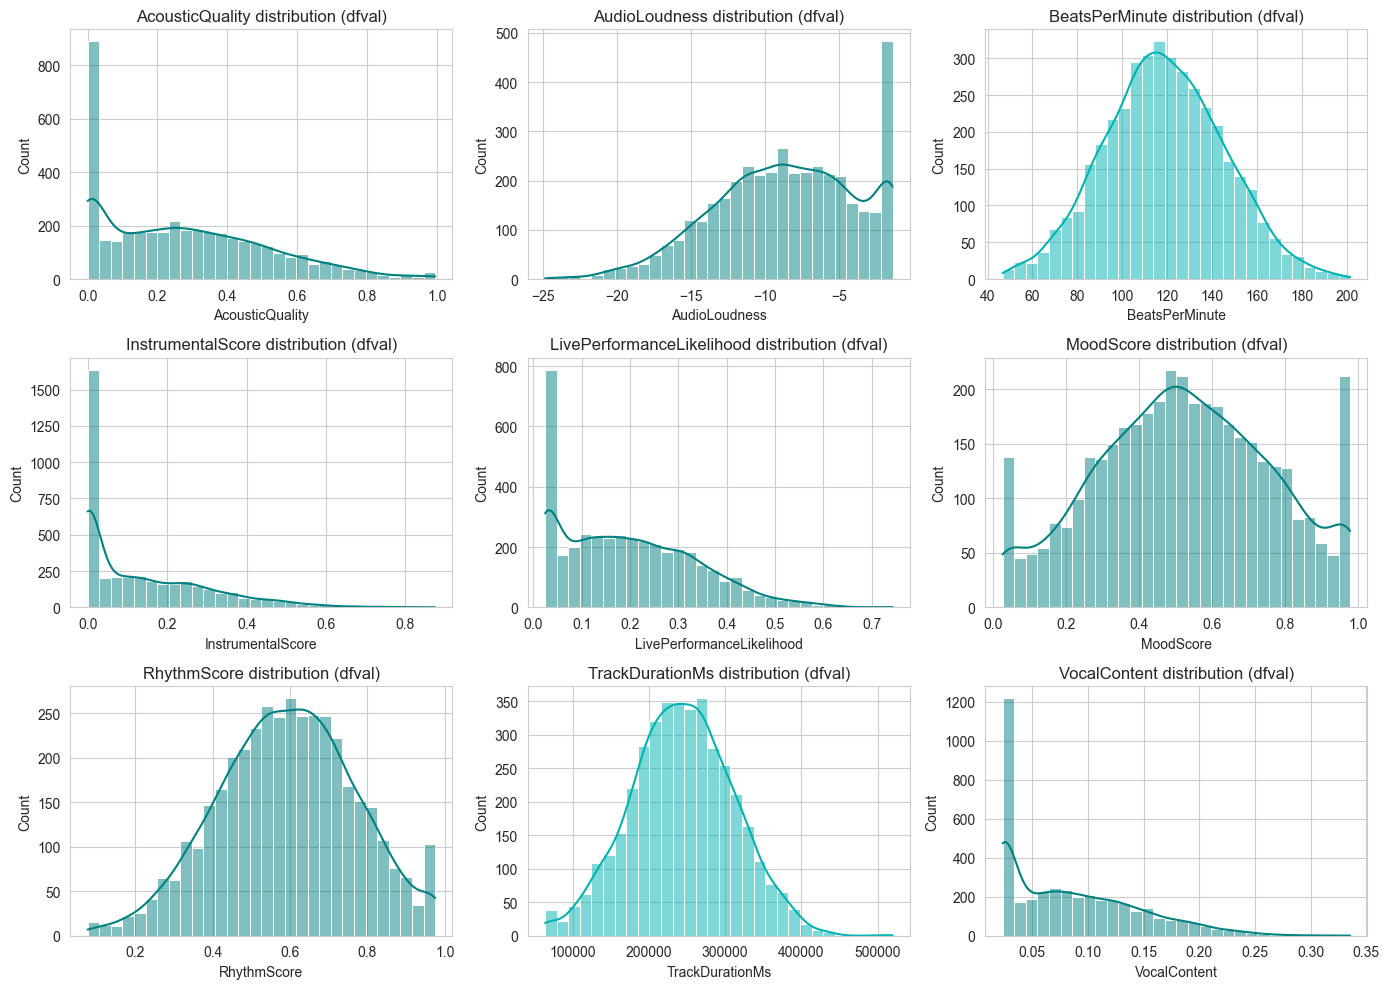

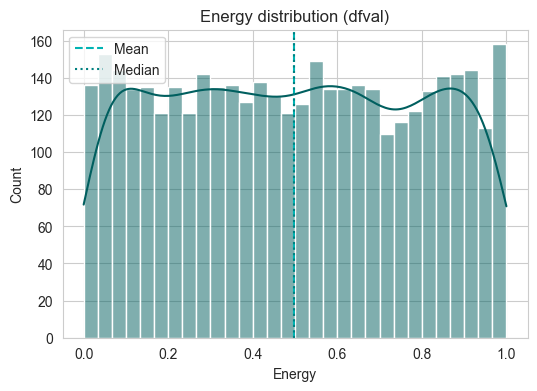

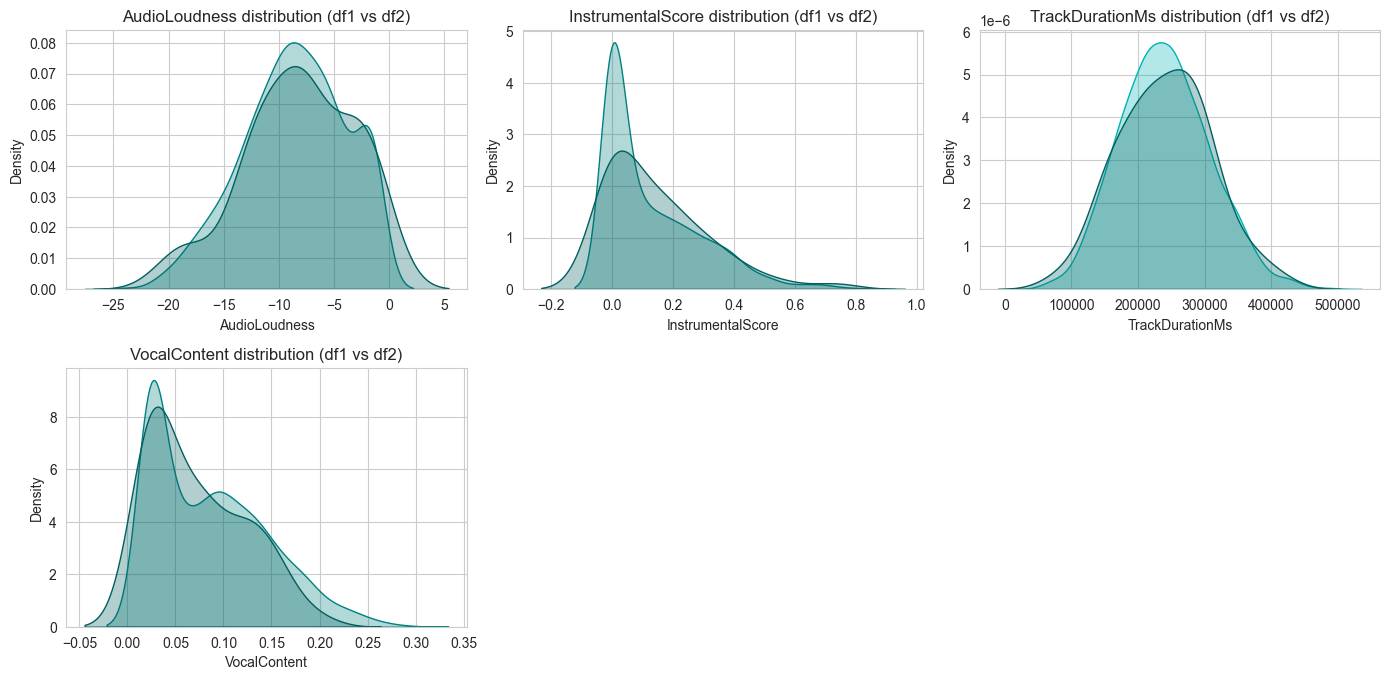

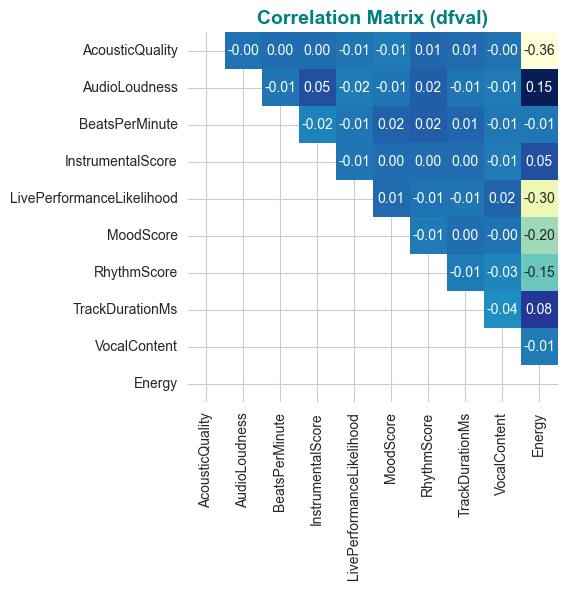

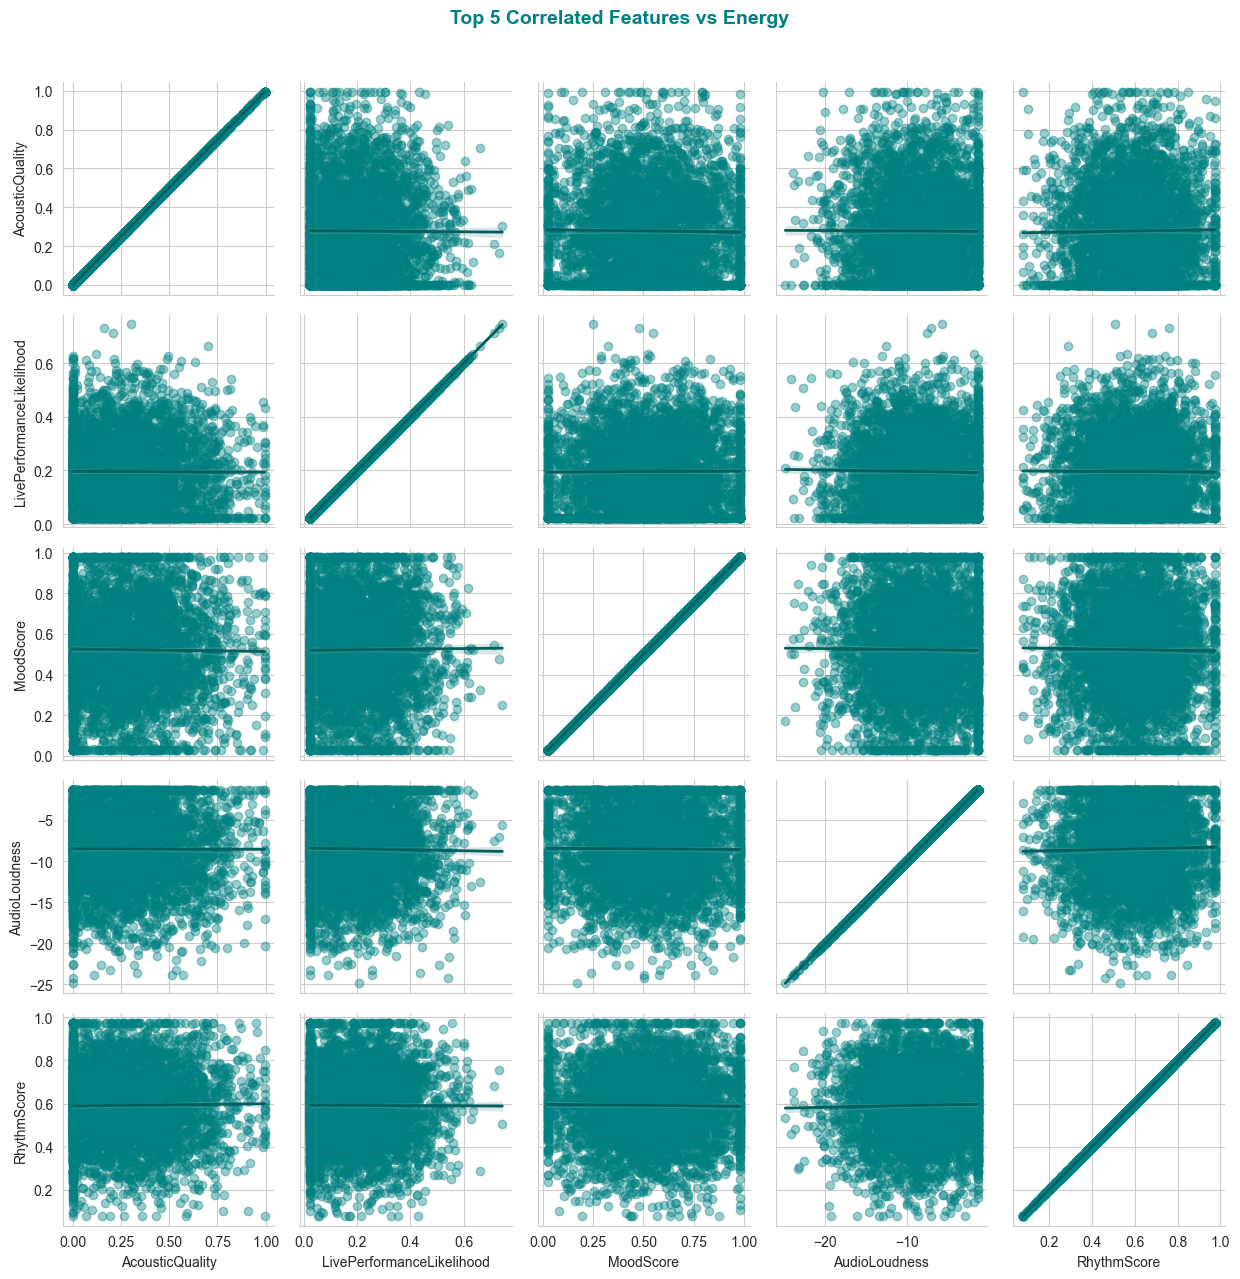

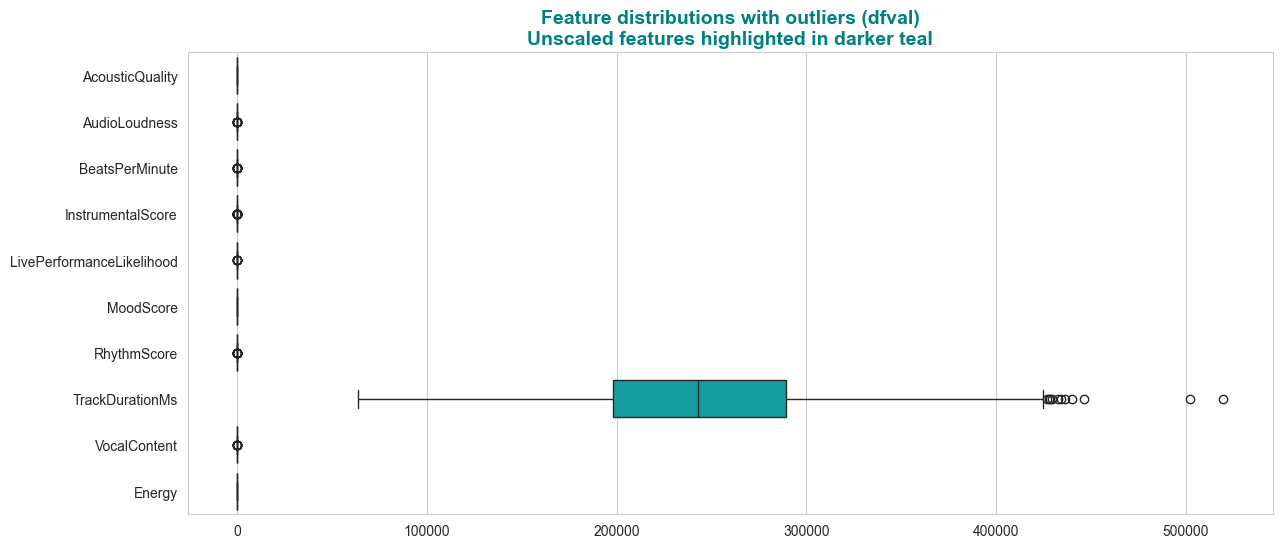

In [8]:
sns.set_style("whitegrid")
palette_teal = ["#008080", "#005f5f", "#00b3b3"]

# Dynamically select features present in dfval
valid_feats_val = [f for f in full_feats if f in dfval.columns]

# Detect likely unscaled features (heuristic: max > 1.5)
unscaled_feats = [f for f in valid_feats_val if dfval[f].max() > 1.5]
print("Features likely unscaled:", unscaled_feats)

# Feature distributions (dfval)
plt.figure(figsize=(14, 10))
for i, col in enumerate(valid_feats_val, 1):
    plt.subplot(3, 3, i)
    color = palette_teal[2] if col in unscaled_feats else palette_teal[0]
    sns.histplot(dfval[col], kde=True, color=color, bins=30)
    plt.title(f"{col} distribution (dfval)")
plt.tight_layout()
plt.show()


# Distribution of Energy
plt.figure(figsize=(6, 4))
sns.histplot(dfval[TARGET], kde=True, color=palette_teal[1], bins=30)
plt.axvline(dfval[TARGET].mean(), color=palette_teal[2], linestyle='--', label='Mean')
plt.axvline(dfval[TARGET].median(), color=palette_teal[0], linestyle=':', label='Median')
plt.title(f"{TARGET} distribution (dfval)")
plt.legend()
plt.show()

# Compare df1 vs df2 feature distributions
# Only keep features that exist in both df1 and df2
common_feats_for_dist = [f for f in full_feats if f in df1.columns and f in df2.columns]

plt.figure(figsize=(14, 10))
for i, col in enumerate(common_feats_for_dist, 1):
    plt.subplot(3, 3, i)
    color1 = palette_teal[2] if col in unscaled_feats else palette_teal[0]
    color2 = palette_teal[1]
    sns.kdeplot(df1[col], label="df1", color=color1, fill=True, alpha=0.3)
    sns.kdeplot(df2[col], label="df2", color=color2, fill=True, alpha=0.3)
    plt.title(f"{col} distribution (df1 vs df2)")
plt.tight_layout()
plt.show()


# Correlation matrix (dfval)
plt.figure(figsize=(8, 6))
corr_val = dfval[valid_feats_val + [TARGET]].corr()
mask = np.tril(np.ones_like(corr_val, dtype=bool))

sns.heatmap(
    corr_val,
    mask=mask,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    square=True,
    cbar=False
)
plt.title("Correlation Matrix (dfval)", fontsize=14, fontweight="bold", color=palette_teal[0])
plt.tight_layout()
plt.show()

# Top 5 correlated features vs Energy
top_corrs_val = corr_val[TARGET].abs().sort_values(ascending=False)[1:6].index

sns.pairplot(
    dfval,
    vars=top_corrs_val,
    y_vars=[TARGET],
    kind="reg",
    diag_kind=None,
    height=2.5,
    plot_kws={"scatter_kws": {"alpha": 0.4, "color": palette_teal[0]},
              "line_kws": {"color": palette_teal[1], "lw": 2}}
)
plt.suptitle("Top 5 Correlated Features vs Energy", y=1.02, fontsize=14, fontweight="bold", color=palette_teal[0])
plt.tight_layout()
plt.show()

# Boxplots for outlier detection
# Highlight unscaled features in darker teal
plt.figure(figsize=(14, 6))
colors = [palette_teal[2] if f in unscaled_feats else palette_teal[0] for f in valid_feats_val + [TARGET]]
sns.boxplot(data=dfval[valid_feats_val + [TARGET]], orient="h", palette=colors)
plt.title("Feature distributions with outliers (dfval)\nUnscaled features highlighted in darker teal", fontsize=14, fontweight="bold", color=palette_teal[0])
plt.show()


In [9]:
# Add a markdown cell to explain the plots and why and our feature engineering (inputinh, etc) startegy...

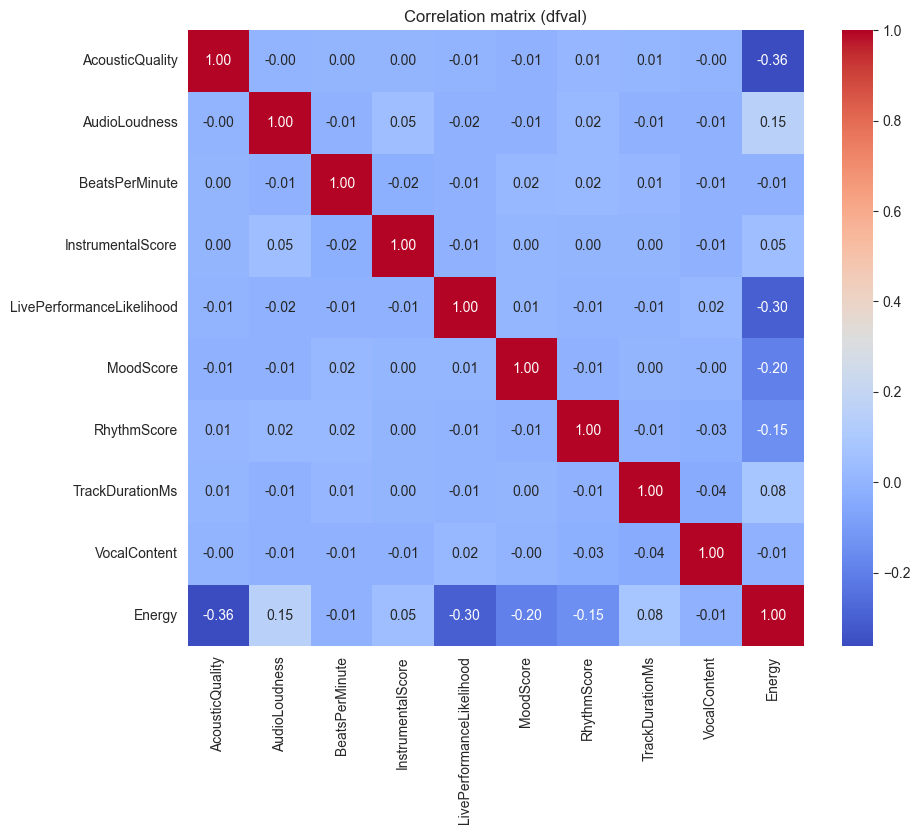

In [10]:
plt.figure(figsize=(10, 8))
corr = dfval[full_feats + [TARGET]].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", square=True)
plt.title("Correlation matrix (dfval)")
plt.show()


MULTIVARIATE SIMILARITY ANALYSIS

1. FEATURE DISTRIBUTION COMPARISONS
--------------------------------------------------
All features found: ['AcousticQuality', 'AudioLoudness', 'BeatsPerMinute', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore', 'TrackDurationMs', 'VocalContent']
df1 features (4): ['AudioLoudness', 'VocalContent', 'InstrumentalScore', 'TrackDurationMs']
df2 features (9): ['AcousticQuality', 'AudioLoudness', 'BeatsPerMinute', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore', 'TrackDurationMs', 'VocalContent']
dfval features (9): ['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs', 'BeatsPerMinute']

Datasets prepared:
  df1: 950 rows, 4 features
  df2: 50 rows, 9 features
  dfval: 4000 rows, 9 features

1.1 Creating individual feature distribution plots...


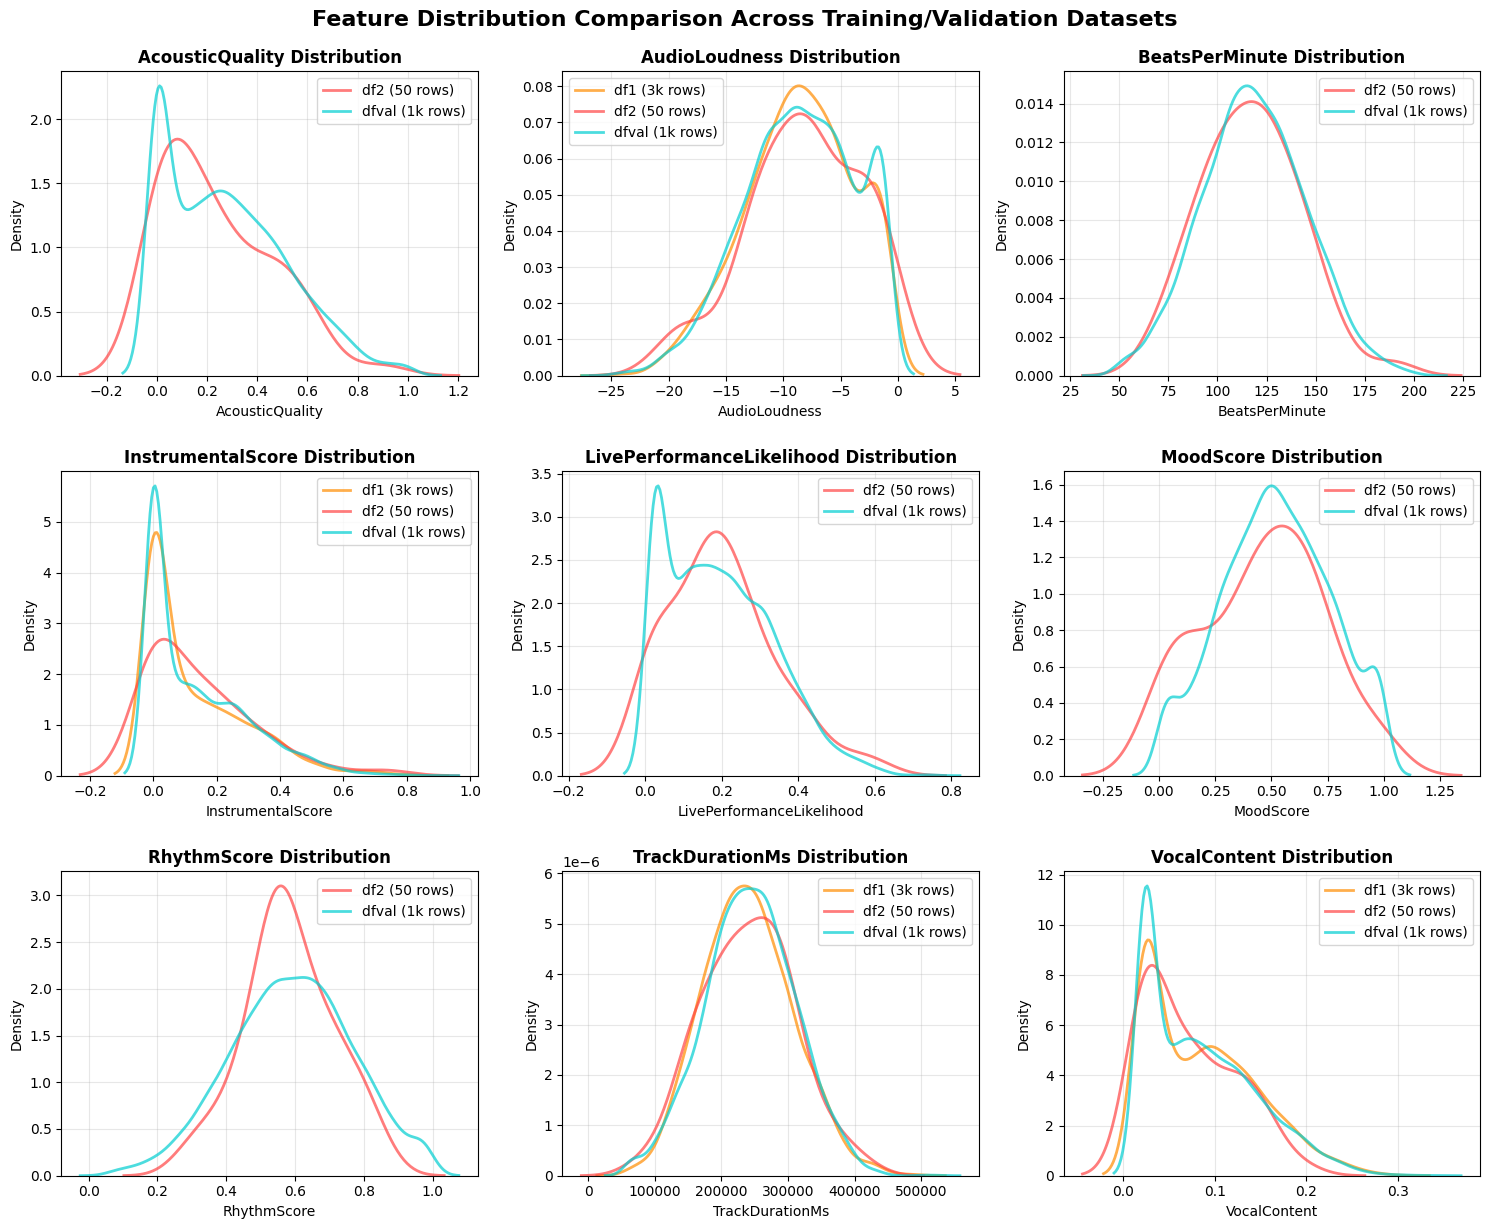


1.2 Creating box plot comparisons...


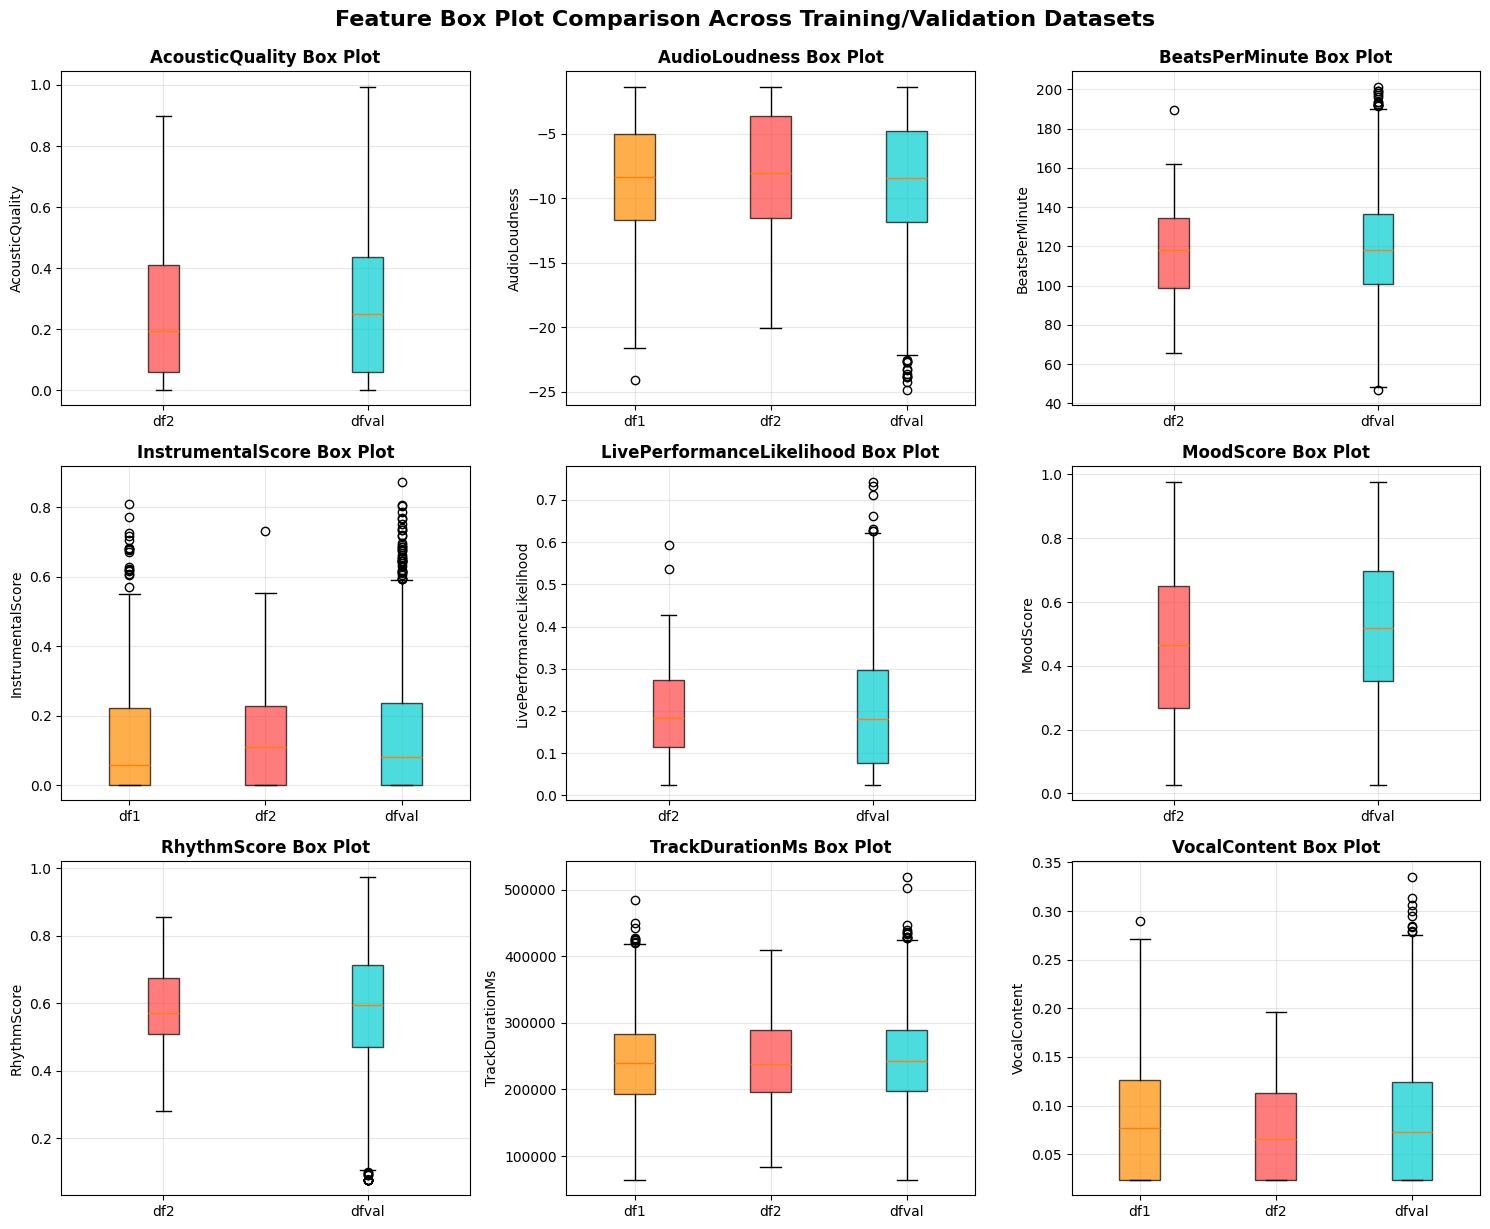


1.3 Statistical summary comparison...

Statistical Summary by Dataset:
                            count        mean        std        min  \
AudioLoudness               950.0      -8.543      4.666    -24.070   
VocalContent                950.0       0.086      0.059      0.024   
InstrumentalScore           950.0       0.129      0.159      0.000   
TrackDurationMs             950.0  240182.204  67242.497  63973.000   
AcousticQuality              50.0       0.240      0.222      0.000   
AudioLoudness                50.0      -8.149      4.941    -20.053   
BeatsPerMinute               50.0     116.979     25.250     65.839   
InstrumentalScore            50.0       0.147      0.168      0.000   
LivePerformanceLikelihood    50.0       0.200      0.139      0.024   
MoodScore                    50.0       0.463      0.266      0.026   
RhythmScore                  50.0       0.584      0.130      0.280   
TrackDurationMs              50.0  240582.474  68552.966  83526.052   
Vocal

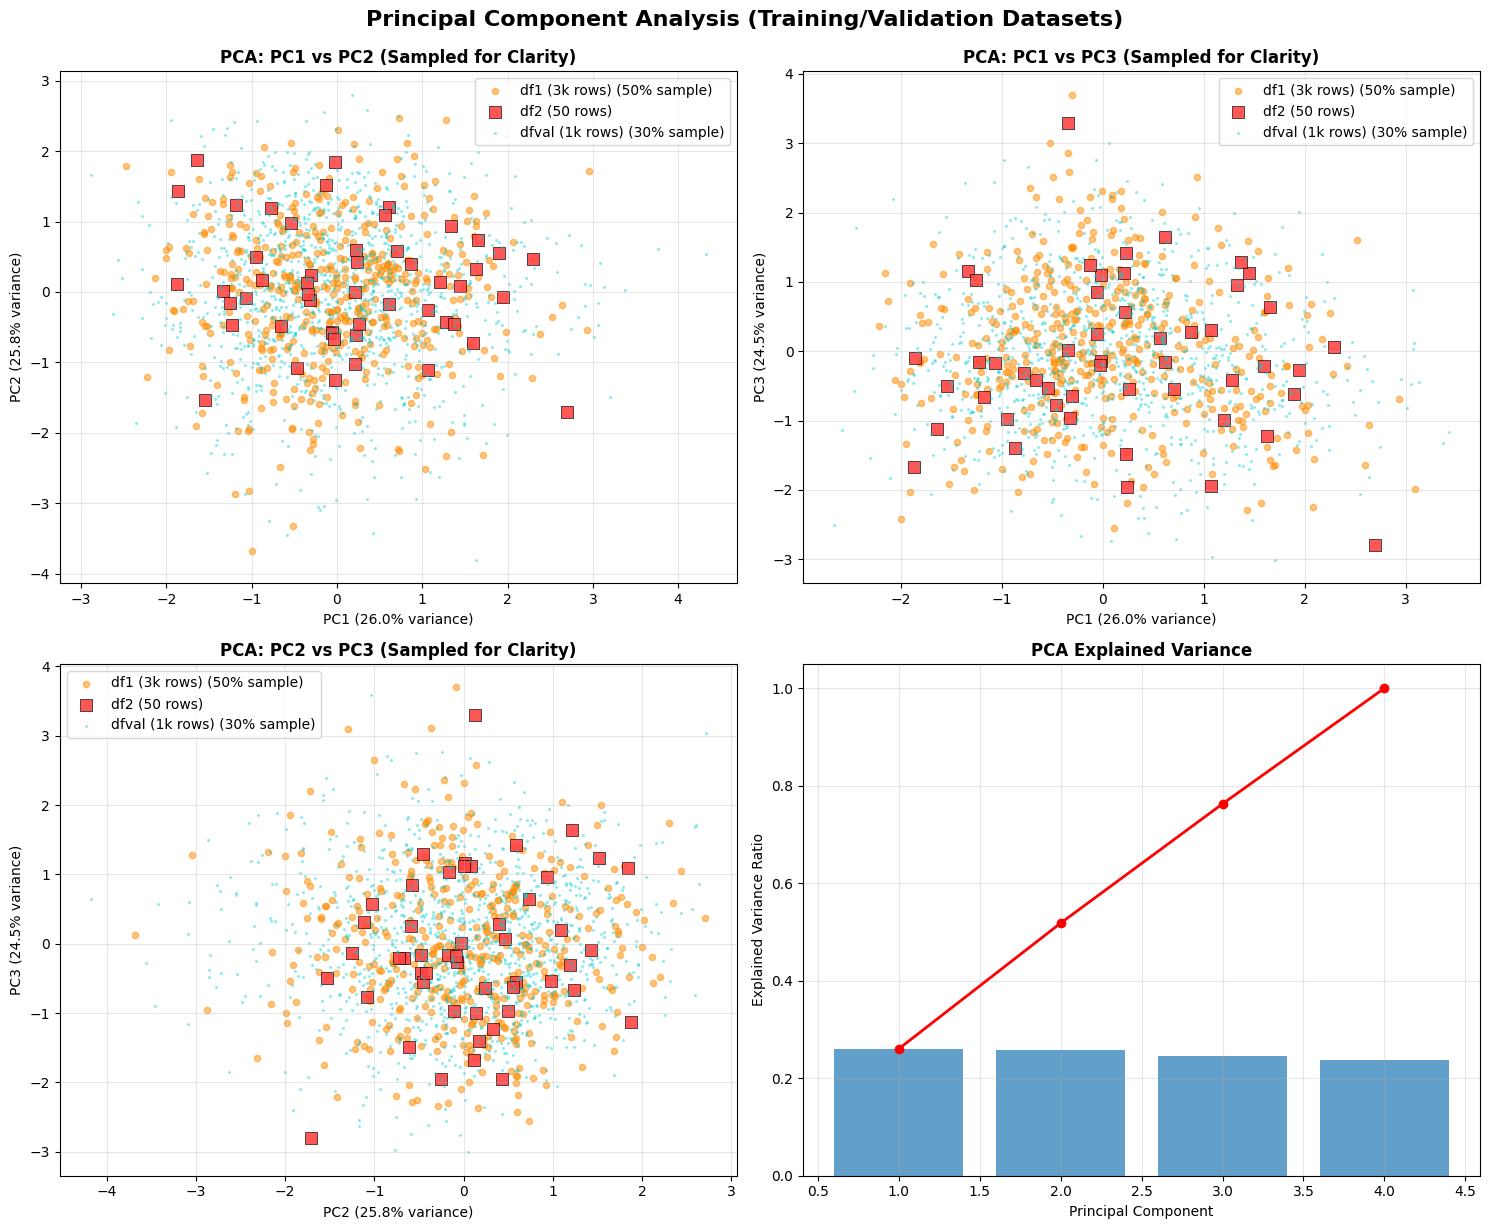



3. t-SNE ANALYSIS
--------------------------------------------------
Running t-SNE (this may take a moment)...
Computing t-SNE with perplexity=10...
Computing t-SNE with perplexity=30...
Computing t-SNE with perplexity=50...


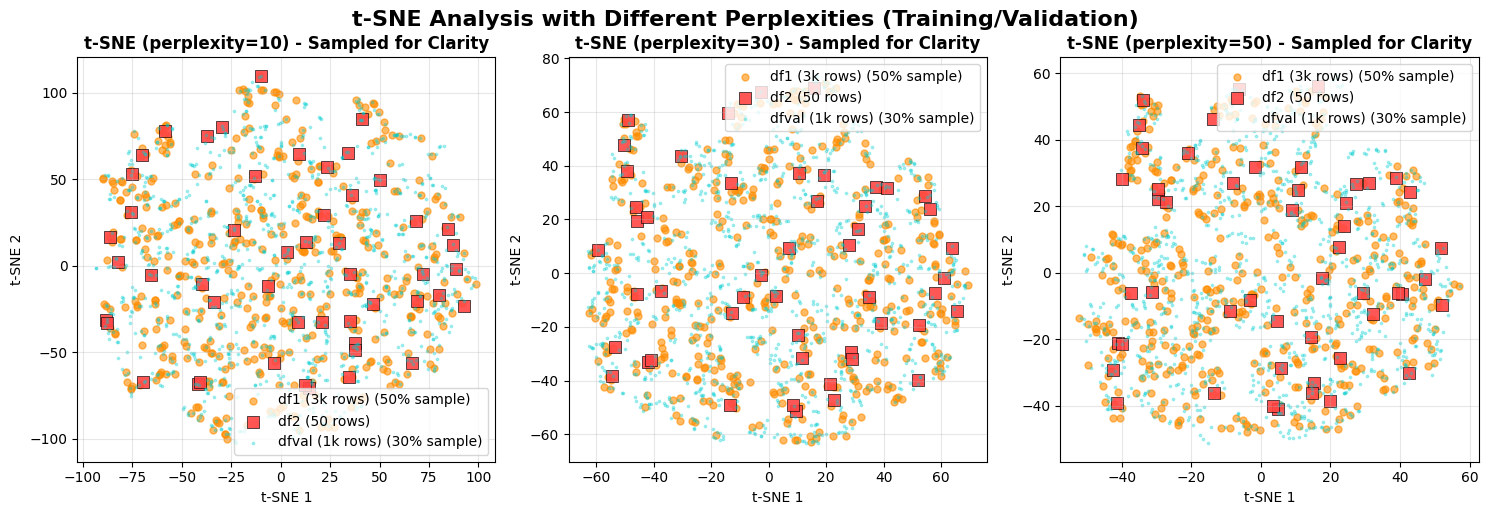



4. CLUSTER ANALYSIS SUMMARY
--------------------------------------------------
Euclidean distances between dataset centroids:
  df1 (3k rows) <-> df2 (50 rows): 0.276
  df1 (3k rows) <-> dfval (1k rows): 0.066
  df2 (50 rows) <-> dfval (1k rows): 0.243

Average feature spread (std dev):
  df1 (3k rows): 0.997
  df2 (50 rows): 0.981
  dfval (1k rows): 1.001


5. ANALYSIS CONCLUSIONS
📊 FEATURE COVERAGE:
   df1 - Average validation coverage: 91.7%
   df2 - Average validation coverage: 72.5%

🔍 TRAINING DATA ASSESSMENT:
   df1 (950 rows, 4 features): ['AudioLoudness', 'VocalContent', 'InstrumentalScore', 'TrackDurationMs']
     ✅ EXCELLENT coverage of validation domain
   df2 (50 rows, 9 features): ['AcousticQuality', 'AudioLoudness', 'BeatsPerMinute', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore', 'TrackDurationMs', 'VocalContent']
     ⚠️  MODERATE coverage given size constraints

💡 STRATEGIC RECOMMENDATIONS:
   • df1: Use for models requiring large sampl

In [11]:
# ==== Multivariate Similarity Analysis ====
print("="*80)
print("MULTIVARIATE SIMILARITY ANALYSIS")
print("="*80)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set up plotting style with more vibrant colors
plt.style.use('default')
palette_datasets = ['#FF8C00', '#FF4444', '#00CED1']  # Orange, Bright Red, Dark Turquoise
colors_dict = {
    'df1 (3k rows)': palette_datasets[0],     # Orange for df1
    'df2 (50 rows)': palette_datasets[1],     # Bright Red for df2
    'dfval (1k rows)': palette_datasets[2]    # Dark Turquoise for dfval
}

# ========================================
# 1. FEATURE DISTRIBUTION COMPARISONS
# ========================================
print("\n1. FEATURE DISTRIBUTION COMPARISONS")
print("-" * 50)

# Get all unique features across all datasets
all_features = sorted(list(set(features_df1 + full_feats + features_val)))
print(f"All features found: {all_features}")
print(f"df1 features ({len(features_df1)}): {features_df1}")
print(f"df2 features ({len(full_feats)}): {full_feats}")
print(f"dfval features ({len(features_val)}): {features_val}")

# Create comparison datasets with all available features
datasets_info = []

# df1 data
if len(features_df1) > 0:
    df1_subset = df1[features_df1].copy()
    df1_subset['dataset'] = 'df1 (3k rows)'
    datasets_info.append(('df1', df1_subset, features_df1))

# df2 data  
if len(full_feats) > 0:
    df2_subset = df2[full_feats].copy()
    df2_subset['dataset'] = 'df2 (50 rows)'
    datasets_info.append(('df2', df2_subset, full_feats))

# dfval data
if len(features_val) > 0:
    dfval_subset = dfval[features_val].copy()
    dfval_subset['dataset'] = 'dfval (1k rows)'
    datasets_info.append(('dfval', dfval_subset, features_val))

print(f"\nDatasets prepared:")
for name, data, feats in datasets_info:
    print(f"  {name}: {data.shape[0]} rows, {len(feats)} features")

# ========================================
# 1.1 Individual Feature Distributions
# ========================================
print("\n1.1 Creating individual feature distribution plots...")

n_features = len(all_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, feature in enumerate(all_features):
    ax = axes[i]
    
    # Plot each dataset that has this feature
    for name, data, feats in datasets_info:
        if feature in feats:
            feature_data = data[feature]
            dataset_name = data['dataset'].iloc[0]
            color = colors_dict[dataset_name]
            
            if len(feature_data) > 0:
                sns.kdeplot(data=feature_data, ax=ax, label=dataset_name, 
                           color=color, alpha=0.7, linewidth=2)
    
    ax.set_title(f'{feature} Distribution', fontweight='bold', fontsize=12)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Feature Distribution Comparison Across Training/Validation Datasets', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# ========================================
# 1.2 Box Plot Comparisons
# ========================================
print("\n1.2 Creating box plot comparisons...")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, feature in enumerate(all_features):
    ax = axes[i]
    
    # Collect data for box plots
    box_data = []
    box_labels = []
    box_colors = []
    
    for name, data, feats in datasets_info:
        if feature in feats:
            box_data.append(data[feature])
            box_labels.append(name)
            dataset_name = data['dataset'].iloc[0]
            box_colors.append(colors_dict[dataset_name])
    
    if box_data:  # Only plot if we have data
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax.set_title(f'{feature} Box Plot', fontweight='bold', fontsize=12)
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Feature Box Plot Comparison Across Training/Validation Datasets', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# ========================================
# 1.3 Statistical Summary Comparison
# ========================================
print("\n1.3 Statistical summary comparison...")

summary_stats = []
for name, data, feats in datasets_info:
    feature_data = data[feats]
    stats = feature_data.describe().T
    dataset_name = data['dataset'].iloc[0]
    stats['dataset'] = dataset_name
    summary_stats.append(stats)

if summary_stats:
    summary_df = pd.concat(summary_stats, axis=0)
    print("\nStatistical Summary by Dataset:")
    print(summary_df.round(3))

# ========================================
# 1.4 Coverage Analysis for Common Features
# ========================================
print("\n1.4 Coverage Analysis: Does training data span the range of validation data?")
print("-" * 60)

# Only analyze features that exist in both training datasets AND validation
analysis_features = [f for f in common_feats if f in dfval.columns]
print(f"Analyzing {len(analysis_features)} common features: {analysis_features}")

coverage_analysis = []
for feature in analysis_features:
    # Get ranges from each dataset
    ranges = {}
    for name, data, feats in datasets_info:
        if feature in feats:
            dataset_name = data['dataset'].iloc[0]
            ranges[dataset_name] = {
                'min': data[feature].min(),
                'max': data[feature].max()
            }
    
    if 'dfval (1k rows)' in ranges:
        val_min = ranges['dfval (1k rows)']['min']
        val_max = ranges['dfval (1k rows)']['max']
        val_range = val_max - val_min
        
        coverage_data = {
            'Feature': feature,
            'dfval_range': f"[{val_min:.3f}, {val_max:.3f}]"
        }
        
        # Calculate coverage for each training dataset
        for dataset_name in ['df1 (3k rows)', 'df2 (50 rows)']:
            if dataset_name in ranges:
                train_min = ranges[dataset_name]['min']
                train_max = ranges[dataset_name]['max']
                coverage_data[f'{dataset_name.split()[0]}_range'] = f"[{train_min:.3f}, {train_max:.3f}]"
                
                # Calculate coverage percentage
                if val_range > 0:
                    overlap = max(0, min(train_max, val_max) - max(train_min, val_min))
                    coverage_pct = min(1.0, overlap / val_range) * 100
                else:
                    coverage_pct = 100.0
                
                coverage_data[f'{dataset_name.split()[0]}_val_coverage_%'] = f"{coverage_pct:.1f}%"
            else:
                coverage_data[f'{dataset_name.split()[0]}_range'] = "N/A"
                coverage_data[f'{dataset_name.split()[0]}_val_coverage_%'] = "N/A"
        
        coverage_analysis.append(coverage_data)

if coverage_analysis:
    coverage_df = pd.DataFrame(coverage_analysis)
    print(coverage_df.to_string(index=False))

# ========================================
# 2. MULTIVARIATE ANALYSIS WITH PCA (Common Features Only)
# ========================================
print("\n\n2. MULTIVARIATE ANALYSIS WITH PCA")
print("-" * 50)

if len(analysis_features) >= 2:
    print(f"Using {len(analysis_features)} common features for PCA: {analysis_features}")
    
    # Prepare data for PCA (only common features)
    pca_datasets = []
    pca_labels = []
    
    for name, data, feats in datasets_info:
        if all(f in feats for f in analysis_features):
            feature_data = data[analysis_features]
            pca_datasets.append(feature_data)
            pca_labels.extend([data['dataset'].iloc[0]] * len(feature_data))
    
    if pca_datasets:
        combined_pca_data = pd.concat(pca_datasets, axis=0, ignore_index=True)
        
        # Standardize features
        scaler = StandardScaler()
        feature_data_scaled = scaler.fit_transform(combined_pca_data)
        
        # Fit PCA
        pca = PCA()
        pca_result = pca.fit_transform(feature_data_scaled)
        
        # Create PCA dataframe
        pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
        pca_df['dataset'] = pca_labels
        
        print(f"PCA explained variance ratio: {pca.explained_variance_ratio_[:5]}")
        print(f"Cumulative variance explained by first 5 PCs: {pca.explained_variance_ratio_[:5].cumsum()}")
        
        # ========================================
        # 2.1 PCA Visualization
        # ========================================
        print("\n2.1 Creating PCA visualizations...")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # PC1 vs PC2
        ax = axes[0, 0]
        for dataset, color in colors_dict.items():
            mask = pca_df['dataset'] == dataset
            if mask.any():
                # Adjust alpha and size for better visibility
                if 'dfval' in dataset:
                    alpha = 0.3
                    size = 8
                    # Sample some points for better visualization
                    sample_mask = mask & (np.random.random(len(pca_df)) < 0.3)  # Show 30% of dfval points
                    if sample_mask.any():
                        ax.scatter(pca_df[sample_mask]['PC1'], pca_df[sample_mask]['PC2'], 
                                  c=color, label=f"{dataset} (30% sample)", alpha=alpha, s=size, marker='.')
                elif 'df2' in dataset:
                    alpha = 0.9
                    size = 80
                    ax.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
                              c=color, label=dataset, alpha=alpha, s=size, marker='s', edgecolors='black', linewidth=0.5)
                else:  # df1
                    alpha = 0.5
                    size = 20
                    # Sample df1 points too since it's large
                    sample_mask = mask & (np.random.random(len(pca_df)) < 0.5)  # Show 50% of df1 points
                    if sample_mask.any():
                        ax.scatter(pca_df[sample_mask]['PC1'], pca_df[sample_mask]['PC2'], 
                                  c=color, label=f"{dataset} (50% sample)", alpha=alpha, s=size, marker='o')
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        ax.set_title('PCA: PC1 vs PC2 (Sampled for Clarity)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # PC1 vs PC3 (if available)
        if pca.explained_variance_ratio_.shape[0] >= 3:
            ax = axes[0, 1]
            for dataset, color in colors_dict.items():
                mask = pca_df['dataset'] == dataset
                if mask.any():
                    if 'dfval' in dataset:
                        alpha = 0.3
                        size = 8
                        sample_mask = mask & (np.random.random(len(pca_df)) < 0.3)
                        if sample_mask.any():
                            ax.scatter(pca_df[sample_mask]['PC1'], pca_df[sample_mask]['PC3'], 
                                      c=color, label=f"{dataset} (30% sample)", alpha=alpha, s=size, marker='.')
                    elif 'df2' in dataset:
                        alpha = 0.9
                        size = 80
                        ax.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC3'], 
                                  c=color, label=dataset, alpha=alpha, s=size, marker='s', edgecolors='black', linewidth=0.5)
                    else:  # df1
                        alpha = 0.5
                        size = 20
                        sample_mask = mask & (np.random.random(len(pca_df)) < 0.5)
                        if sample_mask.any():
                            ax.scatter(pca_df[sample_mask]['PC1'], pca_df[sample_mask]['PC3'], 
                                      c=color, label=f"{dataset} (50% sample)", alpha=alpha, s=size, marker='o')
            
            ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
            ax.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
            ax.set_title('PCA: PC1 vs PC3 (Sampled for Clarity)', fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            axes[0, 1].set_visible(False)
        
        # PC2 vs PC3 (if available)
        if pca.explained_variance_ratio_.shape[0] >= 3:
            ax = axes[1, 0]
            for dataset, color in colors_dict.items():
                mask = pca_df['dataset'] == dataset
                if mask.any():
                    if 'dfval' in dataset:
                        alpha = 0.3
                        size = 8
                        sample_mask = mask & (np.random.random(len(pca_df)) < 0.3)
                        if sample_mask.any():
                            ax.scatter(pca_df[sample_mask]['PC2'], pca_df[sample_mask]['PC3'], 
                                      c=color, label=f"{dataset} (30% sample)", alpha=alpha, s=size, marker='.')
                    elif 'df2' in dataset:
                        alpha = 0.9
                        size = 80
                        ax.scatter(pca_df[mask]['PC2'], pca_df[mask]['PC3'], 
                                  c=color, label=dataset, alpha=alpha, s=size, marker='s', edgecolors='black', linewidth=0.5)
                    else:  # df1
                        alpha = 0.5
                        size = 20
                        sample_mask = mask & (np.random.random(len(pca_df)) < 0.5)
                        if sample_mask.any():
                            ax.scatter(pca_df[sample_mask]['PC2'], pca_df[sample_mask]['PC3'], 
                                      c=color, label=f"{dataset} (50% sample)", alpha=alpha, s=size, marker='o')
            
            ax.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
            ax.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
            ax.set_title('PCA: PC2 vs PC3 (Sampled for Clarity)', fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        else:
            axes[1, 0].set_visible(False)
        
        # Explained variance plot
        ax = axes[1, 1]
        n_components = min(10, len(pca.explained_variance_ratio_))
        ax.bar(range(1, n_components + 1), 
               pca.explained_variance_ratio_[:n_components], alpha=0.7)
        ax.plot(range(1, n_components + 1), 
                pca.explained_variance_ratio_[:n_components].cumsum(), 'ro-', linewidth=2)
        ax.set_xlabel('Principal Component')
        ax.set_ylabel('Explained Variance Ratio')
        ax.set_title('PCA Explained Variance', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Principal Component Analysis (Training/Validation Datasets)', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
        # ========================================
        # 3. t-SNE ANALYSIS
        # ========================================
        print("\n\n3. t-SNE ANALYSIS")
        print("-" * 50)
        
        print("Running t-SNE (this may take a moment)...")
        
        # Run t-SNE with different perplexities
        perplexities = [10, 30, 50]
        fig, axes = plt.subplots(1, len(perplexities), figsize=(15, 5))
        
        for i, perplexity in enumerate(perplexities):
            print(f"Computing t-SNE with perplexity={perplexity}...")
            
            # Adjust perplexity if dataset is too small
            max_perplexity = (len(combined_pca_data) - 1) // 3
            actual_perplexity = min(perplexity, max_perplexity)
            
            if actual_perplexity < 5:
                print(f"Skipping perplexity={perplexity} (dataset too small)")
                axes[i].text(0.5, 0.5, f'Dataset too small\nfor perplexity={perplexity}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f't-SNE (perplexity={perplexity})', fontweight='bold')
                continue
            
            # Fixed: use 'max_iter' instead of 'n_iter'
            tsne = TSNE(n_components=2, perplexity=actual_perplexity, random_state=42, 
                        max_iter=1000, learning_rate=200)
            tsne_result = tsne.fit_transform(feature_data_scaled)
            
            ax = axes[i]
            for dataset, color in colors_dict.items():
                mask = np.array(pca_labels) == dataset
                if mask.any():
                    if 'dfval' in dataset:
                        alpha = 0.3
                        size = 12
                        # Sample 30% of dfval points for better visualization
                        n_points = mask.sum()
                        sample_indices = np.random.choice(
                            np.where(mask)[0], 
                            size=min(int(0.3 * n_points), n_points), 
                            replace=False
                        )
                        sample_mask = np.zeros_like(mask, dtype=bool)
                        sample_mask[sample_indices] = True
                        
                        if sample_mask.any():
                            ax.scatter(tsne_result[sample_mask, 0], tsne_result[sample_mask, 1], 
                                      c=color, label=f"{dataset} (30% sample)", alpha=alpha, s=size, marker='.')
                    elif 'df2' in dataset:
                        alpha = 0.9
                        size = 80
                        ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                                  c=color, label=dataset, alpha=alpha, s=size, marker='s', 
                                  edgecolors='black', linewidth=0.5)
                    else:  # df1
                        alpha = 0.6
                        size = 25
                        # Sample 50% of df1 points for better visualization
                        n_points = mask.sum()
                        sample_indices = np.random.choice(
                            np.where(mask)[0], 
                            size=min(int(0.5 * n_points), n_points), 
                            replace=False
                        )
                        sample_mask = np.zeros_like(mask, dtype=bool)
                        sample_mask[sample_indices] = True
                        
                        if sample_mask.any():
                            ax.scatter(tsne_result[sample_mask, 0], tsne_result[sample_mask, 1], 
                                      c=color, label=f"{dataset} (50% sample)", alpha=alpha, s=size, marker='o')
            
            ax.set_title(f't-SNE (perplexity={actual_perplexity}) - Sampled for Clarity', fontweight='bold')
            ax.set_xlabel('t-SNE 1')
            ax.set_ylabel('t-SNE 2')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('t-SNE Analysis with Different Perplexities (Training/Validation)', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
        # ========================================
        # 4. CLUSTER ANALYSIS SUMMARY
        # ========================================
        print("\n\n4. CLUSTER ANALYSIS SUMMARY")
        print("-" * 50)
        
        # Calculate distances between dataset centroids
        centroids = {}
        spreads = {}
        
        for dataset, color in colors_dict.items():
            mask = np.array(pca_labels) == dataset
            if mask.any():
                data_scaled = feature_data_scaled[mask]
                centroids[dataset] = np.mean(data_scaled, axis=0)
                spreads[dataset] = np.std(data_scaled, axis=0).mean()
        
        # Calculate pairwise distances
        print("Euclidean distances between dataset centroids:")
        for i, (dataset1, centroid1) in enumerate(centroids.items()):
            for j, (dataset2, centroid2) in enumerate(list(centroids.items())[i+1:], i+1):
                distance = np.linalg.norm(centroid1 - centroid2)
                print(f"  {dataset1} <-> {dataset2}: {distance:.3f}")
        
        print(f"\nAverage feature spread (std dev):")
        for dataset, spread in spreads.items():
            print(f"  {dataset}: {spread:.3f}")
        
    else:
        print("No datasets have all common features for PCA analysis")
else:
    print(f"Need at least 2 common features for PCA (found {len(analysis_features)})")

# ========================================
# 5. CONCLUSIONS
# ========================================
print("\n\n5. ANALYSIS CONCLUSIONS")
print("="*50)

if coverage_analysis:
    # Calculate average coverage for training datasets
    df1_coverages = [float(row['df1_val_coverage_%'].rstrip('%')) for row in coverage_analysis if 'df1_val_coverage_%' in row and row['df1_val_coverage_%'] != 'N/A']
    df2_coverages = [float(row['df2_val_coverage_%'].rstrip('%')) for row in coverage_analysis if 'df2_val_coverage_%' in row and row['df2_val_coverage_%'] != 'N/A']
    
    avg_val_coverage_df1 = np.mean(df1_coverages) if df1_coverages else 0
    avg_val_coverage_df2 = np.mean(df2_coverages) if df2_coverages else 0
    
    print(f"📊 FEATURE COVERAGE:")
    if df1_coverages:
        print(f"   df1 - Average validation coverage: {avg_val_coverage_df1:.1f}%")
    if df2_coverages:
        print(f"   df2 - Average validation coverage: {avg_val_coverage_df2:.1f}%")

print(f"\n🔍 TRAINING DATA ASSESSMENT:")
print(f"   df1 ({len(df1)} rows, {len(features_df1)} features): {features_df1}")
if df1_coverages and avg_val_coverage_df1 > 90:
    print(f"     ✅ EXCELLENT coverage of validation domain")
elif df1_coverages and avg_val_coverage_df1 > 70:
    print(f"     ✅ GOOD coverage of validation domain")
elif df1_coverages:
    print(f"     ⚠️  Limited coverage of validation domain")
else:
    print(f"     ❓ Coverage assessment not available")

print(f"   df2 ({len(df2)} rows, {len(full_feats)} features): {full_feats}")
if df2_coverages and avg_val_coverage_df2 > 80:
    print(f"     ✅ GOOD coverage despite small size")
elif df2_coverages and avg_val_coverage_df2 > 60:
    print(f"     ⚠️  MODERATE coverage given size constraints")
elif df2_coverages:
    print(f"     ❌ LIMITED coverage - size constraints affect representation")
else:
    print(f"     ❓ Coverage assessment not available")

print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
print(f"   • df1: Use for models requiring large sample size (limited to {len(features_df1)} features)")
print(f"   • df2: Use for models needing full feature set ({len(full_feats)} features)")
print(f"   • Combined: Leverage both datasets on common features ({len(analysis_features)} features)")
print(f"   • Feature Engineering: Consider imputing missing df1 features using df2")

print("\n" + "="*80)

In [12]:
# ==== Train Lasso with all 2nd-order interactions for Strategies 0, A, B
def lasso_with_interactions(X_train, y_train, X_val, feat_names, label,
                            alpha_grid=[0.001, 0.01, 0.1, 1.0], cv_splits=5):
    """
    Fit a Lasso on polynomial (degree=2) expansion (squares + interactions),
    report coefficient sparsity and top coefficients.
    Returns fitted pipeline, coefficient series, train predictions and validation predictions.
    """
    pipe = Pipeline([
        ("prep", polynomial_preproc(degree=2, interaction_only=False, include_bias=False)),
        ("est", Lasso(random_state=RANDOM_STATE, max_iter=20000))
    ])

    gs = cv_grid_search(pipe, {"est__alpha": alpha_grid}, X_train, y_train, splits=cv_splits)
    best = gs.best_estimator_
    print(f"\nBest params for {label} Lasso (poly2):", gs.best_params_)

    # Fit best estimator on full training data
    best.fit(X_train, y_train)

    # obtain transformed feature names from PolynomialFeatures
    try:
        poly = best.named_steps["prep"].named_steps["poly"]
    except Exception:
        poly = best.named_steps["prep"].__dict__.get("named_steps", {})["poly"]

    try:
        poly_feat_names = poly.get_feature_names_out(feat_names)
    except Exception:
        poly_feat_names = poly.get_feature_names(feat_names)

    coefs = best.named_steps["est"].coef_
    coef_ser = pd.Series(coefs, index=poly_feat_names)

    # Basic diagnostics: identify (near-)zero coefficients
    is_zero = np.isclose(coefs, 0.0)
    zero_feats = [n for n, z in zip(poly_feat_names, is_zero) if z]

    # Format interaction terms: replace spaces or ':' with '*' between feature names.
    def _fmt(name: str) -> str:
        s = name.strip()
        if ":" in s:
            s = s.replace(":", "*")
        if " " in s and "^" not in s:
            parts = s.split()
            return "*".join(parts)
        return s

    formatted_zero = [_fmt(n) for n in zero_feats]

    # Print only the zero-coefficient features as a single space-separated string
    zero_list_str = " ".join(formatted_zero)
    print(f"{label}: zero-coeff features ->")
    print(zero_list_str)

    # Show top positive and negative coefficients
    top_pos = coef_ser.sort_values(ascending=False).head(8)
    top_neg = coef_ser.sort_values().head(8)

    print(f"\nTop positive coefficients ({label}):")
    print(top_pos.to_string(float_format='%.4f'))
    print(f"\nTop negative coefficients ({label}):")
    print(top_neg.to_string(float_format='%.4f'))

    # Predictions
    pred_tr = best.predict(X_train)
    pred_val = best.predict(X_val)

    # Do not auto-append mismatched metrics here; caller should compute metrics with matching y.
    return best, coef_ser, pred_tr, pred_val

In [13]:
def elasticnet_with_interactions(X_train, y_train, X_val, feat_names, label,
                                 alpha_grid=[0.001, 0.01, 0.1, 1.0],
                                 l1_ratio_grid=[0.2, 0.5, 0.8],
                                 cv_splits=5):
    """
    Fit an ElasticNet on polynomial (degree=2) expansion (squares + interactions),
    report coefficient sparsity and top coefficients.
    Returns fitted pipeline, coefficient series, train predictions and validation predictions.
    """
    pipe = Pipeline([
        ("prep", polynomial_preproc(degree=2, interaction_only=False, include_bias=False)),
        ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=20000))
    ])

    gs = cv_grid_search(pipe, {"est__alpha": alpha_grid, "est__l1_ratio": l1_ratio_grid},
                        X_train, y_train, splits=cv_splits)
    best = gs.best_estimator_
    print(f"\nBest params for {label} ElasticNet (poly2):", gs.best_params_)

    # Fit best estimator on full training data
    best.fit(X_train, y_train)

    # obtain transformed feature names from PolynomialFeatures (robust across sklearn versions)
    try:
        poly = best.named_steps["prep"].named_steps["poly"]
    except Exception:
        poly = best.named_steps["prep"].__dict__.get("named_steps", {})["poly"]

    # Prefer the real training DataFrame column names where possible (robust)
    try:
        input_feat_names = list(X_train.columns)
    except Exception:
        input_feat_names = feat_names

    # Ensure provided input names match the transformer's expected input size (n_features_in_ / n_input_features_)
    n_in = getattr(poly, "n_features_in_", None) or getattr(poly, "n_input_features_", None)
    if n_in is not None and len(input_feat_names) != n_in:
        # if the caller's feat_names matches, prefer that
        if feat_names is not None and len(feat_names) == n_in:
            input_feat_names = feat_names
        else:
            # fallback to generic names x0..x{n_in-1}
            input_feat_names = [f"x{i}" for i in range(n_in)]

    # Try sklearn >=1.0 API first, then older API, else fall back to generic output names
    try:
        if hasattr(poly, "get_feature_names_out"):
            poly_feat_names = list(poly.get_feature_names_out(input_feat_names))
        elif hasattr(poly, "get_feature_names"):
            # older sklearn: get_feature_names accepts input_features (may be optional)
            try:
                poly_feat_names = list(poly.get_feature_names(input_feat_names))
            except TypeError:
                poly_feat_names = list(poly.get_feature_names())
        else:
            raise AttributeError("PolynomialFeatures has no feature name API")
    except Exception:
        # Last-resort: build safe generic output names using n_output_features_ or combinatorics
        n_out = getattr(poly, "n_output_features_", None)
        if n_out is None:
            # conservative estimate for degree=2, include_bias flag unknown: use triangular formula
            m = len(input_feat_names)
            n_out = m * (m + 1) // 2
        poly_feat_names = [f"poly_{i}" for i in range(n_out)]

    coefs = best.named_steps["est"].coef_
    coef_ser = pd.Series(coefs, index=poly_feat_names)

    # Basic diagnostics: identify (near-)zero coefficients
    is_zero = np.isclose(coefs, 0.0)
    zero_feats = [n for n, z in zip(poly_feat_names, is_zero) if z]

    # Format interaction terms: replace spaces or ':' with '*' between feature names.
    def _fmt(name: str) -> str:
        s = name.strip()
        if ":" in s:
            s = s.replace(":", "*")
        if " " in s and "^" not in s:
            parts = s.split()
            return "*".join(parts)
        return s

    formatted_zero = [_fmt(n) for n in zero_feats]

    # Print only the zero-coefficient features as a single space-separated string
    zero_list_str = " ".join(formatted_zero)
    print(f"{label}: zero-coeff features ->")
    print(zero_list_str)

    # Show top positive and negative coefficients
    top_pos = coef_ser.sort_values(ascending=False).head(8)
    top_neg = coef_ser.sort_values().head(8)

    print(f"\nTop positive coefficients ({label}):")
    print(top_pos.to_string(float_format='%.4f'))
    print(f"\nTop negative coefficients ({label}):")
    print(top_neg.to_string(float_format='%.4f'))

    # Predictions
    pred_tr = best.predict(X_train)
    pred_val = best.predict(X_val)

    # Do not auto-append mismatched metrics here; caller should compute metrics with matching y.
    return best, coef_ser, pred_tr, pred_val

## Strategy A — only use df1

### A1) Lasso with Interactions and Polynomials of degree 2

In [14]:
# Strategy A (df1 only)
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)


X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)

print("\n--- Strategy A: Lasso with all interactions ---")
lasso0, coef0, pred_tr0, pred0 = lasso_with_interactions(X_0_train_tf, y_0_train, X_0_val_tf, candidate_feats, "0_Lasso_poly2")

# Compute and store proper dfval metrics for Strategy A result (use matching y / preds)
RESULTS = [r for r in RESULTS if r.get("label") not in {"A_Lasso_poly2_interactions | In-sample", "A_Lasso_poly2_interactions | dfval"}]
RESULTS += [
    metrics(y_0_train, pred_tr0, "A_Lasso_poly2_interactions | In-sample"),
    metrics(y_0_val,   pred0,    "A_Lasso_poly2_interactions | dfval"),
]
MODEL_STORE["A_Lasso_poly2_interactions"] = lasso0
VAL_PRED_STORE["A_Lasso_poly2_interactions"] = pred0

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_Lasso_poly2_interactions")],
                    "Lasso with interactions (Strategy A) metrics")


Detected skewed columns (log1p applied): ['InstrumentalScore']

--- Strategy A: Lasso with all interactions ---

Best params for 0_Lasso_poly2 Lasso (poly2): {'est__alpha': 0.01}
0_Lasso_poly2: zero-coeff features ->
InstrumentalScore TrackDurationMs AudioLoudness^2 AudioLoudness*TrackDurationMs AudioLoudness*VocalContent InstrumentalScore*TrackDurationMs InstrumentalScore*VocalContent TrackDurationMs^2 TrackDurationMs*VocalContent VocalContent^2

Top positive coefficients (0_Lasso_poly2):
AudioLoudness                      0.0187
InstrumentalScore^2                0.0107
VocalContent                       0.0038
AudioLoudness InstrumentalScore    0.0006
TrackDurationMs                   -0.0000
InstrumentalScore                  0.0000
AudioLoudness^2                   -0.0000
AudioLoudness TrackDurationMs      0.0000

Top negative coefficients (0_Lasso_poly2):
InstrumentalScore                    0.0000
TrackDurationMs                     -0.0000
AudioLoudness TrackDurationMs        

,RMSE,MAE,R2
label,,,
A_Lasso_poly2_interactions | In-sample,0.280026,0.241637,0.015036
A_Lasso_poly2_interactions | dfval,0.289738,0.251245,0.017541


We can see that the Lasso model sets zero coefficients for a large number of interaction terms, indicating that these terms do not contribute significantly to the prediction of Energy. 
This sparsity is a key feature of Lasso regression, which helps in feature selection by effectively ignoring irrelevant features.

We can see that only few interaction terms have non-zero coefficients, specifically:

- $InstrumentalScore^2$
- $AudioLoudness \times InstrumentalScore$


### A2) Lasso without Interactions and compare

In [15]:
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)


X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"est__alpha": [0.001, 0.01, 0.1, 1.0]}

gs = cv_grid_search(pipe, grid, X_0_train_tf, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_Lasso:", gs.best_params_)

best.fit(X_0_train_tf, y_0_train)
pred_tr = best.predict(X_0_train_tf)
pred_val = best.predict(X_0_val_tf)

RESULTS += [
    metrics(y_0_train, pred_tr, "A_Lasso | In-sample"),
    metrics(y_0_val,   pred_val, "A_Lasso | dfval"),
]
MODEL_STORE["A_Lasso"] = best
VAL_PRED_STORE["A_Lasso"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_Lasso")],
                    "Lasso (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_Lasso_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['InstrumentalScore']
Best params for A_Lasso: {'est__alpha': 0.01}

Lasso (Strategy A) metrics
                                            RMSE       MAE        R2
label                                                               
A_Lasso_poly2_interactions | In-sample  0.280026  0.241637  0.015036
A_Lasso | In-sample                     0.280317  0.241951  0.012984
A_Lasso_poly2_interactions | dfval      0.289738  0.251245  0.017541
A_Lasso | dfval                         0.289826  0.251341  0.016950


,RMSE,MAE,R2
label,,,
A_Lasso_poly2_interactions | In-sample,0.280026,0.241637,0.015036
A_Lasso | In-sample,0.280317,0.241951,0.012984
A_Lasso_poly2_interactions | dfval,0.289738,0.251245,0.017541
A_Lasso | dfval,0.289826,0.251341,0.016950


We can see that the Lasso model with interactions and polynomial features of degree 2 has a minimal improvement in RMSE compared to the Lasso model without these features.

This suggests that while the additional features may capture some non-linear relationships, they do not significantly enhance the model's predictive performance for this particular dataset.

### A3) Ridge Regression

In [16]:
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)


X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_0_train_tf, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_Ridge:", gs.best_params_)

# Fit and evaluate
best.fit(X_0_train_tf, y_0_train)
pred_tr = best.predict(X_0_train_tf)
pred_val = best.predict(X_0_val_tf)

RESULTS += [
    metrics(y_0_train, pred_tr, "A_Ridge | In-sample"),
    metrics(y_0_val,   pred_val, "A_Ridge | dfval"),
]
MODEL_STORE["A_Ridge"] = best
VAL_PRED_STORE["A_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_Ridge")],
                    "Ridge (Strategy A) metrics")

# Optional: write Xtest predictions
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_Ridge_Xtest.csv", index=False)

Detected skewed columns (log1p applied): ['InstrumentalScore']
Best params for A_Ridge: {'est__alpha': 10.0}

Ridge (Strategy A) metrics
                         RMSE       MAE        R2
label                                            
A_Ridge | In-sample  0.279799  0.240976  0.016634
A_Ridge | dfval      0.289212  0.250531  0.021106


,RMSE,MAE,R2
label,,,
A_Ridge | In-sample,0.279799,0.240976,0.016634
A_Ridge | dfval,0.289212,0.250531,0.021106


### A4) ElasticNet Regression with Interactions and Polynomials of degree 2

In [17]:
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)

print("\n--- Strategy A: ElasticNet with all interactions (poly2) ---")
elastic0, coef0_e, pred_tr0_e, pred0_e = elasticnet_with_interactions(
    X_0_train_tf, y_0_train, X_0_val_tf, candidate_feats, "A_ElasticNet_poly2"
)

# Replace any previous A_ElasticNet_poly2 metrics and store new ones
RESULTS = [r for r in RESULTS if r.get("label") not in {"A_ElasticNet_poly2 | In-sample", "A_ElasticNet_poly2 | dfval"}]
RESULTS += [
    metrics(y_0_train, pred_tr0_e, "A_ElasticNet_poly2 | In-sample"),
    metrics(y_0_val,   pred0_e,    "A_ElasticNet_poly2 | dfval"),
]
MODEL_STORE["A_ElasticNet_poly2"] = elastic0
VAL_PRED_STORE["A_ElasticNet_poly2"] = pred0_e

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_ElasticNet_poly2")],
                    "Elastic Net (Strategy A) metrics")

Detected skewed columns (log1p applied): ['InstrumentalScore']

--- Strategy A: ElasticNet with all interactions (poly2) ---

Best params for A_ElasticNet_poly2 ElasticNet (poly2): {'est__alpha': 0.01, 'est__l1_ratio': 0.8}
A_ElasticNet_poly2: zero-coeff features ->
VocalContent InstrumentalScore AudioLoudness^2 AudioLoudness*InstrumentalScore AudioLoudness*TrackDurationMs VocalContent*InstrumentalScore VocalContent*TrackDurationMs InstrumentalScore^2 InstrumentalScore*TrackDurationMs TrackDurationMs^2

Top positive coefficients (A_ElasticNet_poly2):
VocalContent^2                     0.0183
AudioLoudness                      0.0155
AudioLoudness VocalContent         0.0090
TrackDurationMs                    0.0058
InstrumentalScore                 -0.0000
VocalContent                       0.0000
AudioLoudness^2                   -0.0000
AudioLoudness InstrumentalScore    0.0000

Top negative coefficients (A_ElasticNet_poly2):
VocalContent                       0.0000
InstrumentalScor

,RMSE,MAE,R2
label,,,
A_ElasticNet_poly2 | In-sample,0.279551,0.241288,0.018373
A_ElasticNet_poly2 | dfval,0.289098,0.250670,0.021882


### A5) ElasticNet without Interactions and compare

In [18]:
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df1, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)


X_0_train_tf = apply_log1p(X_0_train, SKEWED_COLS)
X_0_val_tf   = apply_log1p(X_0_val, SKEWED_COLS)


pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_0_train_tf, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_ElasticNet:", gs.best_params_)

best.fit(X_0_train_tf, y_0_train)
pred_tr = best.predict(X_0_train_tf)
pred_val = best.predict(X_0_val_tf)

RESULTS += [
    metrics(y_0_train, pred_tr, "A_ElasticNet | In-sample"),
    metrics(y_0_val,   pred_val, "A_ElasticNet | dfval"),
]
MODEL_STORE["A_ElasticNet"] = best
VAL_PRED_STORE["A_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_ElasticNet")],
                    "Elastic Net (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['InstrumentalScore']
Best params for A_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.8}

Elastic Net (Strategy A) metrics
                                    RMSE       MAE        R2
label                                                       
A_ElasticNet_poly2 | In-sample  0.279551  0.241288  0.018373
A_ElasticNet | In-sample        0.280139  0.241709  0.014239
A_ElasticNet_poly2 | dfval      0.289098  0.250670  0.021882
A_ElasticNet | dfval            0.289607  0.251119  0.018432


,RMSE,MAE,R2
label,,,
A_ElasticNet_poly2 | In-sample,0.279551,0.241288,0.018373
A_ElasticNet | In-sample,0.280139,0.241709,0.014239
A_ElasticNet_poly2 | dfval,0.289098,0.250670,0.021882
A_ElasticNet | dfval,0.289607,0.251119,0.018432


### A6) Random Forest Regressor

In [19]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

grid = {
    "est__n_estimators": [200, 500],
    "est__max_depth": [None, 6, 10],
    "est__min_samples_leaf": [2, 3, 5]
}

gs = cv_grid_search(pipe, grid, X_0_train, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_RF:", gs.best_params_)

best.fit(X_0_train, y_0_train)
pred_tr = best.predict(X_0_train)
pred_val = best.predict(X_0_val)

RESULTS += [
    metrics(y_0_train, pred_tr, "A_RF | In-sample"),
    metrics(y_0_val,   pred_val, "A_RF | dfval"),
]
MODEL_STORE["A_RF"] = best
VAL_PRED_STORE["A_RF"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_RF")],
                    "Random Forest (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_RF_Xtest.csv", index=False)


Best params for A_RF: {'est__max_depth': 6, 'est__min_samples_leaf': 2, 'est__n_estimators': 500}

Random Forest (Strategy A) metrics
                      RMSE       MAE        R2
label                                         
A_RF | In-sample  0.235241  0.203262  0.304894
A_RF | dfval      0.285827  0.245386  0.043889


,RMSE,MAE,R2
label,,,
A_RF | In-sample,0.235241,0.203262,0.304894
A_RF | dfval,0.285827,0.245386,0.043889


### A7) Histogram-based Gradient Boosting Regressor

In [20]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 3, 6],
    "est__min_samples_leaf": [5, 20, 50],
    "est__learning_rate": [0.01, 0.05, 0.1]
}

gs = cv_grid_search(pipe, grid, X_0_train, y_0_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for A_HGB:", gs.best_params_)

best.fit(X_0_train, y_0_train)
pred_tr = best.predict(X_0_train)
pred_val = best.predict(X_0_val)

RESULTS += [
    metrics(y_0_train, pred_tr, "A_HGB | In-sample"),
    metrics(y_0_val,   pred_val, "A_HGB | dfval"),
]
MODEL_STORE["A_HGB"] = best
VAL_PRED_STORE["A_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_HGB")],
                    "HistGradientBoosting (Strategy A) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("A_HGB_Xtest.csv", index=False)


Best params for A_HGB: {'est__learning_rate': 0.01, 'est__max_depth': 3, 'est__min_samples_leaf': 50}

HistGradientBoosting (Strategy A) metrics
                       RMSE       MAE        R2
label                                          
A_HGB | In-sample  0.271382  0.234928  0.074908
A_HGB | dfval      0.285361  0.247121  0.047001


,RMSE,MAE,R2
label,,,
A_HGB | In-sample,0.271382,0.234928,0.074908
A_HGB | dfval,0.285361,0.247121,0.047001


### A7) XGBoost Regressor

In [21]:
xgb_base_0 = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

param_grid_a = {
    "learning_rate": [0.02, 0.03],
    "max_depth": [2, 3, 4],
    "min_child_weight": [2, 3],
    "gamma": [0, 0.25],                # was off; add light split penalty
    "subsample": [0.6, 0.7, 0.8],           # let full sampling be an option
    "colsample_bytree": [0.7, 0.8],    # allow full column use (only 4 feats)
    "reg_lambda": [0.1, 1],
    "reg_alpha": [0, 0.1],
}

print("Running GridSearchCV for A_XGB (this may take a while)...")
gs_0 = cv_grid_search(xgb_base_0, param_grid_a, X_0_train, y_0_train, splits=5)
best_xgb_0 = gs_0.best_estimator_
print("Best params (A_XGB):", gs_0.best_params_)

# Ensure fitted and evaluate
best_xgb_0.fit(X_0_train, y_0_train)
pred_tr_0 = best_xgb_0.predict(X_0_train)
pred_val_0 = best_xgb_0.predict(X_0_val)

# Remove any existing A_XGB entries and add new ones
incoming_0 = {"A_XGB | In-sample", "A_XGB | dfval", "A_XGB | In-sample", "A_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_0]
RESULTS += [
    metrics(y_0_train, pred_tr_0, "A_XGB | In-sample"),
    metrics(y_0_val,   pred_val_0, "A_XGB | dfval"),
]
MODEL_STORE["A_XGB"] = best_xgb_0
VAL_PRED_STORE["A_XGB"] = pred_val_0

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_XGB")],
                    "XGBoost (Strategy A) metrics")

Running GridSearchCV for A_XGB (this may take a while)...
Best params (A_XGB): {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7}

XGBoost (Strategy A) metrics
                       RMSE       MAE        R2
label                                          
A_XGB | In-sample  0.261644  0.226602  0.140103
A_XGB | dfval      0.284758  0.245804  0.051030


,RMSE,MAE,R2
label,,,
A_XGB | In-sample,0.261644,0.226602,0.140103
A_XGB | dfval,0.284758,0.245804,0.051030


In [22]:
# If GridSearchCV produced best_xgb_0, reuse it (it's already fitted on X_0_train).
# Otherwise, build an XGBRegressor with the best params discovered and fit it on the transformed data.
if "best_xgb_0" in globals():
    print("Reusing best_xgb_0 from earlier GridSearchCV (assumed fitted).")
    model_0_xgb = best_xgb_0
else:
    print("No GridSearch result found; instantiating XGBRegressor with chosen best params and fitting.")
    model_0_xgb = XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0,
        colsample_bytree=0.8,
        gamma=0,
        learning_rate=0.02,
        max_depth=3,
        min_child_weight=2,
        reg_alpha=0,
        reg_lambda=0.1,
        subsample=0.7,
        n_estimators=700,
    )
    model_0_xgb.fit(X_0_train, y_0_train)

# Predict on train/val (use the same transformed matrices)
pred_tr_0 = model_0_xgb.predict(X_0_train)
pred_val_0 = model_0_xgb.predict(X_0_val)

# Replace any existing A_XGB results and store estimator
incoming_0 = {"A_XGB | In-sample", "A_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_0]
RESULTS += [
    metrics(y_0_train, pred_tr_0, "A_XGB | In-sample"),
    metrics(y_0_val,   pred_val_0, "A_XGB | dfval"),
]
MODEL_STORE["A_XGB"] = model_0_xgb
VAL_PRED_STORE["A_XGB"] = pred_val_0

print("Best params used:", {
    'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02,
    'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0,
    'reg_lambda': 0.1, 'subsample': 0.7, 'n_estimators': 700
})

print_metrics_table([r for r in RESULTS if r["label"].startswith("A_XGB")],
                    "XGBoost (Strategy A) - Best Params")

Reusing best_xgb_0 from earlier GridSearchCV (assumed fitted).
Best params used: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7, 'n_estimators': 700}

XGBoost (Strategy A) - Best Params
                       RMSE       MAE        R2
label                                          
A_XGB | In-sample  0.261644  0.226602  0.140103
A_XGB | dfval      0.284758  0.245804  0.051030


,RMSE,MAE,R2
label,,,
A_XGB | In-sample,0.261644,0.226602,0.140103
A_XGB | dfval,0.284758,0.245804,0.051030


In [23]:
# print all results starting with A_
a = print_metrics_table([r for r in RESULTS if r["label"].startswith("A_")],
                    "All Strategy A results")


All Strategy A results
                                            RMSE       MAE        R2
label                                                               
A_RF | In-sample                        0.235241  0.203262  0.304894
A_XGB | In-sample                       0.261644  0.226602  0.140103
A_HGB | In-sample                       0.271382  0.234928  0.074908
A_ElasticNet_poly2 | In-sample          0.279551  0.241288  0.018373
A_Ridge | In-sample                     0.279799  0.240976  0.016634
A_Lasso_poly2_interactions | In-sample  0.280026  0.241637  0.015036
A_ElasticNet | In-sample                0.280139  0.241709  0.014239
A_Lasso | In-sample                     0.280317  0.241951  0.012984
A_XGB | dfval                           0.284758  0.245804  0.051030
A_HGB | dfval                           0.285361  0.247121  0.047001
A_RF | dfval                            0.285827  0.245386  0.043889
A_ElasticNet_poly2 | dfval              0.289098  0.250670  0.021882
A_Ridge | 

### A8) Ensemble of top 3 models

In [24]:
# === [NEW] Strategy-A Ensemble: Modular Implementation ====

from sklearn.linear_model import LinearRegression

def get_strategyA_candidates(results, top_k=3, rmse_close_abs=0.02, rmse_close_rel=0.05):
    """
    Extract and rank Strategy-A models by dfval RMSE.
    
    Returns:
        list: Selected model names for ensemble
        str: Reason for selection
        list: All candidates with (name, rmse) tuples
    """
    dfval_rows = [r for r in results if r.get("label", "").endswith("| dfval")]
    rows0 = [r for r in dfval_rows if r["label"].startswith("A_")]
    
    if not rows0:
        return [], "No Strategy-A dfval results found", []
    
    # Extract (name, rmse) and sort by RMSE
    rmse_list = []
    for r in rows0:
        name = r["label"].split(" | ")[0]
        rmse = float(r["RMSE"])
        rmse_list.append((name, rmse))
    
    rmse_list = sorted(rmse_list, key=lambda x: x[1])
    top_candidates = rmse_list[:top_k]
    names_top = [n for n, _ in top_candidates]
    rmse_vals = [v for _, v in top_candidates]
    
    # Decide selection strategy
    if len(rmse_vals) >= 3:
        diff = rmse_vals[-1] - rmse_vals[0]
        threshold = max(rmse_close_abs, rmse_close_rel * rmse_vals[0])
        if diff <= threshold:
            keep_names = names_top
            reason = f"kept top {len(names_top)} because diff {diff:.4f} <= threshold {threshold:.4f}"
        else:
            keep_names = [names_top[0]]
            reason = f"kept only best because diff {diff:.4f} > threshold {threshold:.4f}"
    else:
        keep_names = names_top
        reason = f"kept {len(names_top)} available candidate(s)"
    
    return keep_names, reason, rmse_list

def create_strategyA_predictor(model_store, candidate_feats, skewed_cols):
    """
    Create a unified predictor function for Strategy-A models.
    Handles different model types (XGB with transforms, pipelines, etc.)
    """
    def predict_A_on(df, model_name):
        mdl = model_store.get(model_name)
        if mdl is None:
            raise KeyError(f"Model {model_name} not found in MODEL_STORE")
        
        # Special handling for XGB models that need log transformation
        if model_name == "A_XGB" and isinstance(mdl, XGBRegressor):
            X = apply_log1p(df[candidate_feats], skewed_cols)
            return mdl.predict(X)
        else:
            # Standard pipelines/estimators
            return mdl.predict(df[candidate_feats])
    
    return predict_A_on

def build_prediction_matrices(model_names, predictor_fn, dfval, df2, val_pred_store):
    """
    Build prediction matrices for ensemble learning and application.
    
    Returns:
        np.array: Validation predictions (n_val, n_models)
        np.array: df2 predictions (n_df2, n_models)
        list: Valid model names (after filtering NaN columns)
    """
    Z_val_list = []
    Z_df2_list = []
    
    for nm in model_names:
        # Try to reuse cached validation predictions
        val_pred = val_pred_store.get(nm)
        if val_pred is None:
            try:
                val_pred = predictor_fn(dfval, nm)
            except Exception as e:
                print(f"Warning: failed to get dfval preds for {nm}: {e}")
                val_pred = np.full(len(dfval), np.nan)
        Z_val_list.append(val_pred)
        
        # Generate df2 predictions
        try:
            p2 = predictor_fn(df2, nm)
        except Exception as e:
            print(f"Warning: failed to get df2 preds for {nm}: {e}")
            p2 = np.full(len(df2), np.nan)
        Z_df2_list.append(p2)
    
    Z_val = np.vstack(Z_val_list).T  # (n_val, n_models)
    Z_df2 = np.vstack(Z_df2_list).T  # (n_df2, n_models)
    
    # Filter out models with all-NaN predictions
    valid_cols = ~np.all(np.isnan(Z_val), axis=0)
    if not np.all(valid_cols):
        dropped = [nm for nm, ok in zip(model_names, valid_cols) if not ok]
        print(f"Dropping models with invalid dfval predictions: {dropped}")
        Z_val = Z_val[:, valid_cols]
        Z_df2 = Z_df2[:, valid_cols]
        model_names = [nm for nm, ok in zip(model_names, valid_cols) if ok]
    
    return Z_val, Z_df2, model_names

def learn_ensemble_weights(Z_val, y_val):
    """
    Learn non-negative linear weights for ensemble on validation data.
    
    Returns:
        fitted blender model
        dict: weights per model
        float: intercept
    """
    try:
        blender = LinearRegression(positive=True)
    except TypeError:
        blender = LinearRegression()  # fallback for older sklearn
    
    blender.fit(Z_val, y_val)
    
    weights = blender.coef_.tolist()
    intercept = float(getattr(blender, "intercept_", 0.0))
    
    return blender, weights, intercept

def add_ensemble_features_to_df2(df2, Z_df2, model_names, ensemble_preds):
    """
    Add individual model predictions and ensemble prediction as new features to df2.
    
    Returns:
        pd.DataFrame: df2 with new prediction columns
    """
    df2_copy = df2.copy()
    
    # # Add individual model predictions
    # for i, nm in enumerate(model_names):
    #     df2_copy[f"pred_from_{nm}"] = Z_df2[:, i]
    
    # Add ensemble prediction
    df2_copy["pred_from_df1_ensemble"] = ensemble_preds
    
    return df2_copy

def store_ensemble_metadata(model_store, val_pred_store, model_names, blender, 
                          val_ensemble_preds, df2_ensemble_preds):
    """Store ensemble metadata and predictions for later use."""
    # Update validation prediction store
    val_pred_store["A_ENSEMBLE_on_dfval"] = val_ensemble_preds
    val_pred_store["A_ENSEMBLE_on_df2"] = df2_ensemble_preds
    
    # Store ensemble model metadata
    model_store["A_ENSEMBLE"] = {
        "members": model_names,
        "blender": blender,
        "type": "learned_on_dfval"
    }

# === Main execution ===
def create_strategyA_ensemble():
    """Main function to create Strategy-A ensemble and add features to df2."""
    global df2  # Declare global at the very beginning
    
    # Step 1: Get candidate models
    keep_names, reason, rmse_list = get_strategyA_candidates(
        RESULTS, top_k=3, rmse_close_abs=0.02, rmse_close_rel=0.05
    )
    
    if not keep_names:
        print("No Strategy-A dfval results found; nothing to add to df2.")
        return
    
    print(f"Strategy-A candidates (RMSE sorted): {rmse_list}")
    print(f"Selected A_ members: {keep_names} | {reason}")
    
    # Step 2: Set up predictor function
    candidate_feats_0 = features_df1
    skewed_cols_0 = detect_skewed_cols(df1, candidate_feats_0, thresh=0.6)
    predictor_fn = create_strategyA_predictor(MODEL_STORE, candidate_feats_0, skewed_cols_0)
    
    # Step 3: Build prediction matrices
    Z_val, Z_df2, valid_names = build_prediction_matrices(
        keep_names, predictor_fn, dfval, df2, VAL_PRED_STORE
    )
    
    if len(valid_names) == 0:
        print("No valid models remaining after filtering; ensemble creation failed.")
        return
    
    # Step 4: Learn ensemble weights
    y_val = dfval[TARGET].values
    blender, weights, intercept = learn_ensemble_weights(Z_val, y_val)
    
    print(f"Learned (non-negative) weights on dfval for A_ members: {dict(zip(valid_names, weights))}")
    print(f"Intercept: {intercept}")
    
    # Step 5: Generate ensemble predictions
    ensemble_on_df2 = blender.predict(Z_df2)
    ensemble_on_val = blender.predict(Z_val)
    
    # === NEW: Report ensemble validation accuracy ===
    ensemble_val_metrics = metrics(y_val, ensemble_on_val, "A_ENSEMBLE | dfval")
    print(f"\nEnsemble validation accuracy:")
    print(f"  RMSE: {ensemble_val_metrics['RMSE']:.4f}")
    print(f"  MAE:  {ensemble_val_metrics['MAE']:.4f}")
    print(f"  R²:   {ensemble_val_metrics['R2']:.4f}")
    
    # Step 6: Add features to df2
    df2_aug = add_ensemble_features_to_df2(df2, Z_df2, valid_names, ensemble_on_df2)
    
    # Step 7: Store metadata
    store_ensemble_metadata(
        MODEL_STORE, VAL_PRED_STORE, valid_names, blender,
        ensemble_on_val, ensemble_on_df2
    )
    
    print(f"Appended {len(valid_names)} Strategy-A prediction columns + ensemble to df2 (shape {df2_aug.shape}).")
    
    return df2_aug

# Execute the ensemble creation
df2_aug = create_strategyA_ensemble()

Strategy-A candidates (RMSE sorted): [('A_XGB', 0.28475755289071986), ('A_HGB', 0.285361382430832), ('A_RF', 0.2858270075221657), ('A_ElasticNet_poly2', 0.289097763128505), ('A_Ridge', 0.2892124355459285), ('A_ElasticNet', 0.28960707739777736), ('A_Lasso_poly2_interactions', 0.289738467637657), ('A_Lasso', 0.28982572276358853)]
Selected A_ members: ['A_XGB', 'A_HGB', 'A_RF'] | kept top 3 because diff 0.0011 <= threshold 0.0200
Learned (non-negative) weights on dfval for A_ members: {'A_XGB': 0.5463893960079825, 'A_HGB': 1.3508952998308013, 'A_RF': 0.0}
Intercept: -0.44612636359738456

Ensemble validation accuracy:
  RMSE: 0.2828
  MAE:  0.2431
  R²:   0.0643
Appended 3 Strategy-A prediction columns + ensemble to df2 (shape (50, 11)).


Here we add the ensemble predictions of df2 dataset as a new column to df2 to be used in Strategy B.

In [25]:
display(df2_aug.head())

,AudioLoudness,VocalContent,InstrumentalScore,TrackDurationMs,MoodScore,LivePerformanceLikelihood,RhythmScore,BeatsPerMinute,AcousticQuality,Energy,pred_from_df1_ensemble
0,-11.440931,0.023500,0.033187,248690.96540,0.450407,0.175127,0.588774,118.939062,0.000005,1.000000,0.498986
1,-11.615412,0.161318,0.000001,306581.75890,0.226243,0.235302,0.326847,65.839092,0.000005,0.730743,0.459268
2,-1.704469,0.037208,0.000001,348110.23450,0.193083,0.189641,0.642252,144.518693,0.557669,0.745158,0.557456
3,-8.194718,0.071638,0.731908,83526.05152,0.676062,0.277297,0.534640,117.038385,0.159250,0.461324,0.396715
4,-7.979415,0.023500,0.000001,159770.45340,0.881021,0.395619,0.544520,110.438965,0.099547,0.612047,0.410818


## Strategy B — Combine df1 and df2 (on common features only)

### B1) Lasso with Interactions and Polynomials of degree 2

In [26]:
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)

print("\n--- Strategy B: Lasso with all interactions ---")
lassoA, coefA, pred_trA, predA = lasso_with_interactions(
    X_A_train_tf, y_A_train_local, X_A_val_tf, candidate_feats, "B_Lasso_poly2"
)

# Compute and store proper dfval metrics for Strategy B result
RESULTS = [r for r in RESULTS if r.get("label") not in {"B_Lasso_poly2_interactions | In-sample", "B_Lasso_poly2_interactions | dfval"}]
RESULTS += [
    metrics(y_A_train_local, pred_trA, "B_Lasso_poly2_interactions | In-sample"),
    metrics(y_A_val_local,   predA,   "B_Lasso_poly2_interactions | dfval"),
]

MODEL_STORE["B_Lasso_poly2_interactions"] = lassoA
VAL_PRED_STORE["B_Lasso_poly2_interactions"] = predA

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_Lasso_poly2_interactions")],
                    "Lasso with interactions (Strategy B) metrics")

Detected skewed columns (log1p applied): ['InstrumentalScore']

--- Strategy B: Lasso with all interactions ---

Best params for B_Lasso_poly2 Lasso (poly2): {'est__alpha': 0.001}
B_Lasso_poly2: zero-coeff features ->
InstrumentalScore*TrackDurationMs TrackDurationMs^2

Top positive coefficients (B_Lasso_poly2):
AudioLoudness                     0.0794
AudioLoudness^2                   0.0540
VocalContent^2                    0.0486
InstrumentalScore^2               0.0316
AudioLoudness VocalContent        0.0260
TrackDurationMs                   0.0177
VocalContent                      0.0029
AudioLoudness InstrumentalScore   0.0027

Top negative coefficients (B_Lasso_poly2):
InstrumentalScore                   -0.0328
TrackDurationMs VocalContent        -0.0221
AudioLoudness TrackDurationMs       -0.0128
InstrumentalScore TrackDurationMs   -0.0000
TrackDurationMs^2                    0.0000
InstrumentalScore VocalContent       0.0025
AudioLoudness InstrumentalScore      0.0027
VocalC

,RMSE,MAE,R2
label,,,
B_Lasso_poly2_interactions | In-sample,0.278325,0.240551,0.037555
B_Lasso_poly2_interactions | dfval,0.285615,0.247446,0.045307


### B2) Lasso without Interactions and compare

In [27]:
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)


pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"est__alpha": [0.001, 0.01, 0.1, 1.0]}

gs = cv_grid_search(pipe, grid, X_A_train_local, y_A_train_local, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_Lasso:", gs.best_params_)

best.fit(X_A_train_local, y_A_train_local)
pred_tr = best.predict(X_A_train_local)
pred_val = best.predict(X_A_val_local)

RESULTS += [
    metrics(y_A_train_local, pred_tr, "B_Lasso | In-sample"),
    metrics(y_A_val_local,   pred_val, "B_Lasso | dfval"),
]
MODEL_STORE["B_Lasso"] = best
VAL_PRED_STORE["B_Lasso"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_Lasso")],
                    "Lasso (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("B_Lasso_Xtest.csv", index=False)

Detected skewed columns (log1p applied): ['InstrumentalScore']
Best params for B_Lasso: {'est__alpha': 0.001}

Lasso (Strategy B) metrics
                                            RMSE       MAE        R2
label                                                               
B_Lasso_poly2_interactions | In-sample  0.278325  0.240551  0.037555
B_Lasso | In-sample                     0.280844  0.241653  0.020059
B_Lasso_poly2_interactions | dfval      0.285615  0.247446  0.045307
B_Lasso | dfval                         0.288793  0.250230  0.023943


,RMSE,MAE,R2
label,,,
B_Lasso_poly2_interactions | In-sample,0.278325,0.240551,0.037555
B_Lasso | In-sample,0.280844,0.241653,0.020059
B_Lasso_poly2_interactions | dfval,0.285615,0.247446,0.045307
B_Lasso | dfval,0.288793,0.250230,0.023943


### B3) Ridge Regression

In [28]:
candidate_feats = sorted(list(dict.fromkeys(common_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)


pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_A_train_local, y_A_train_local, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_Ridge:", gs.best_params_)

# Fit and evaluate
best.fit(X_A_train_local, y_A_train_local)
pred_tr = best.predict(X_A_train_local)
pred_val = best.predict(X_A_val_local)

RESULTS += [
    metrics(y_A_train_local, pred_tr, "B_Ridge | In-sample"),
    metrics(y_A_val_local,   pred_val, "B_Ridge | dfval"),
]
MODEL_STORE["B_Ridge"] = best
VAL_PRED_STORE["B_Ridge"] = pred_val

a = print_metrics_table([r for r in RESULTS if r["label"].startswith("B_Ridge")],
                    "Ridge (Strategy B) metrics")

# Optional: write Xtest predictions
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("B_Ridge_Xtest.csv", index=False)

Detected skewed columns (log1p applied): ['InstrumentalScore']
Best params for B_Ridge: {'est__alpha': 10.0}

Ridge (Strategy B) metrics
                         RMSE       MAE        R2
label                                            
B_Ridge | In-sample  0.280837  0.241595  0.020102
B_Ridge | dfval      0.288830  0.250225  0.023690


### B4) ElasticNet Regression with Interactions and Polynomials of degree 2

In [29]:
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_B_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_B_val_local   = dfval[common_feats]
y_B_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_B_val_local   = dfval[TARGET]

X_B_train_tf = apply_log1p(X_B_train_local, SKEWED_COLS)
X_B_val_tf   = apply_log1p(X_B_val_local, SKEWED_COLS)


print("\n--- Strategy B: ElasticNet with all interactions (poly2) ---")
elasticB, coefB_e, pred_trB_e, predB_e = elasticnet_with_interactions(
    X_B_train_tf, y_B_train_local, X_B_val_tf, candidate_feats, "B_ElasticNet_poly2"
)

RESULTS += [
    metrics(y_B_train_local, pred_trB_e, "B_ElasticNet | In-sample"),
    metrics(y_B_val_local,   predB_e, "B_ElasticNet | dfval"),
]
MODEL_STORE["B_ElasticNet"] = elasticB
VAL_PRED_STORE["B_ElasticNet"] = predB_e

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_ElasticNet")],
                    "Elastic Net (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("B_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']

--- Strategy B: ElasticNet with all interactions (poly2) ---

Best params for B_ElasticNet_poly2 ElasticNet (poly2): {'est__alpha': 0.001, 'est__l1_ratio': 0.5}
B_ElasticNet_poly2: zero-coeff features ->
TrackDurationMs^2

Top positive coefficients (B_ElasticNet_poly2):
AudioLoudness                    0.0973
AudioLoudness^2                  0.0642
VocalContent^2                   0.0469
InstrumentalScore^2              0.0389
AudioLoudness VocalContent       0.0297
VocalContent                     0.0200
TrackDurationMs                  0.0193
InstrumentalScore VocalContent   0.0047

Top negative coefficients (B_ElasticNet_poly2):
InstrumentalScore                   -0.0406
TrackDurationMs VocalContent        -0.0373
AudioLoudness TrackDurationMs       -0.0237
InstrumentalScore TrackDurationMs   -0.0010
TrackDurationMs^2                    0.0000
AudioLoudness InstrumentalScore      0.0027
InstrumentalS

,RMSE,MAE,R2
label,,,
B_ElasticNet | In-sample,0.278071,0.240371,0.039315
B_ElasticNet | dfval,0.285145,0.246931,0.048444


### B5) ElasticNet without Interactions and compare

In [30]:
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_A_train_tf, y_A_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_ElasticNet", gs.best_params_)

best.fit(X_A_train_tf, y_A_train)
pred_tr = best.predict(X_A_train_tf)
pred_val = best.predict(X_A_val_tf)

RESULTS += [
    metrics(y_A_train, pred_tr, "B_ElasticNe | In-sample"),
    metrics(y_A_val,   pred_val, "B_ElasticNe | dfval"),
]
MODEL_STORE["B_ElasticNe"] = best
VAL_PRED_STORE["B_ElasticNe"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_ElasticNet")],
                    "Elastic Net (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("B_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for B_ElasticNet {'est__alpha': 0.01, 'est__l1_ratio': 0.2}

Elastic Net (Strategy B) metrics
                              RMSE       MAE        R2
label                                                 
B_ElasticNet | In-sample  0.278071  0.240371  0.039315
B_ElasticNet | dfval      0.285145  0.246931  0.048444


,RMSE,MAE,R2
label,,,
B_ElasticNet | In-sample,0.278071,0.240371,0.039315
B_ElasticNet | dfval,0.285145,0.246931,0.048444


### B6) Random Forest Regressor

In [31]:
X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

grid = {
    "est__n_estimators": [200, 500],
    "est__max_depth": [None, 6, 10],
    "est__min_samples_leaf": [2, 3, 5]
}

gs = cv_grid_search(pipe, grid, X_A_train_local, y_A_train_local, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_RF:", gs.best_params_)

best.fit(X_A_train_local, y_A_train_local)
pred_tr = best.predict(X_A_train_local)
pred_val = best.predict(X_A_val_local)

RESULTS += [
    metrics(y_A_train_local, pred_tr, "B_RF | In-sample"),
    metrics(y_A_val,   pred_val, "B_RF | dfval"),
]
MODEL_STORE["B_RF"] = best
VAL_PRED_STORE["B_RF"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_RF")],
                    "Random Forest (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("B_RF_Xtest.csv", index=False)


Best params for B_RF: {'est__max_depth': 6, 'est__min_samples_leaf': 2, 'est__n_estimators': 200}

Random Forest (Strategy B) metrics
                      RMSE       MAE        R2
label                                         
B_RF | In-sample  0.236923  0.204157  0.302593
B_RF | dfval      0.284698  0.244776  0.051427


,RMSE,MAE,R2
label,,,
B_RF | In-sample,0.236923,0.204157,0.302593
B_RF | dfval,0.284698,0.244776,0.051427


### B7) Histogram-based Gradient Boosting Regressor

In [32]:
X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 3, 6],
    "est__min_samples_leaf": [5, 20, 50],
    "est__learning_rate": [0.01, 0.05, 0.1]
}


gs = cv_grid_search(pipe, grid, X_A_train_local, y_A_train_local, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for B_HGB:", gs.best_params_)

best.fit(X_A_train_local, y_A_train_local)
pred_tr = best.predict(X_A_train_local)
pred_val = best.predict(X_A_val_local)

RESULTS += [
    metrics(y_A_train_local, pred_tr, "B_HGB | In-sample"),
    metrics(y_A_val_local,   pred_val, "B_HGB | dfval"),
]
MODEL_STORE["B_HGB"] = best
VAL_PRED_STORE["B_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_HGB")],
                    "HistGradientBoosting (Strategy B) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("B_HGB_Xtest.csv", index=False)


Best params for B_HGB: {'est__learning_rate': 0.01, 'est__max_depth': 3, 'est__min_samples_leaf': 50}

HistGradientBoosting (Strategy B) metrics
                       RMSE       MAE        R2
label                                          
B_HGB | In-sample  0.272652  0.235704  0.076389
B_HGB | dfval      0.284832  0.246771  0.050533


,RMSE,MAE,R2
label,,,
B_HGB | In-sample,0.272652,0.235704,0.076389
B_HGB | dfval,0.284832,0.246771,0.050533


### B8) XGBoost Regressor

In [33]:
# X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
# X_A_val_local   = dfval[common_feats]
# y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
# y_A_val_local   = dfval[TARGET]

# X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
# X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)

# # Grid-search XGBoost hyperparameters for Strategy A
# xgb_base_a = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

# param_grid_a = {
#     "learning_rate": [0.02, 0.03, 0.05],
#     "max_depth": [2, 3, 4],
#     "min_child_weight": [2, 3, 4],
#     "gamma": [0, 0.25, 0.5],                # was off; add light split penalty
#     "subsample": [0.6, 0.7, 0.8],           # let full sampling be an option
#     "colsample_bytree": [0.7, 0.8, 1.0],    # allow full column use (only 4 feats)
#     "reg_lambda": [0.1, 1, 5],
#     "reg_alpha": [0, 0.1, 0.25, 0.5],
# }

# print("Running GridSearchCV for B_XGB (this may take a while)...")
# gs_a = cv_grid_search(xgb_base_a, param_grid_a, X_A_train_tf, y_A_train_local, splits=5)
# best_xgb_a = gs_a.best_estimator_
# print("Best params (B_XGB):", gs_a.best_params_)

# # Ensure fitted and evaluate
# best_xgb_a.fit(X_A_train_tf, y_A_train_local)
# pred_tr_a = best_xgb_a.predict(X_A_train_tf)
# pred_val_a = best_xgb_a.predict(X_A_val_tf)

# # Remove any existing B_XGB entries and add new ones
# incoming_a = {"B_XGB | In-sample", "B_XGB | dfval", "B_XGB | In-sample", "B_XGB | dfval"}
# RESULTS = [r for r in RESULTS if r.get("label") not in incoming_a]
# RESULTS += [
#     metrics(y_A_train_local, pred_tr_a, "B_XGB | In-sample"),
#     metrics(y_A_val_local,   pred_val_a, "B_XGB | dfval"),
# ]
# MODEL_STORE["B_XGB"] = best_xgb_a
# VAL_PRED_STORE["B_XGB"] = pred_val_a

# print_metrics_table([r for r in RESULTS if r["label"].startswith("B_XGB")],
#                     "XGBoost (Strategy A) metrics")

In [34]:
# === XGBoost Strategy A with BEST PARAMS (no grid search) ===
SKEWED_COLS = []

# ----------------- Strategy A: XGB on common_feats with BEST PARAMS -----------------
X_A_train_local = pd.concat([df1[common_feats], df2[common_feats]], axis=0)
X_A_val_local   = dfval[common_feats]
y_A_train_local = pd.concat([df1[TARGET], df2[TARGET]], axis=0)
y_A_val_local   = dfval[TARGET]

X_A_train_tf = apply_log1p(X_A_train_local, SKEWED_COLS)
X_A_val_tf   = apply_log1p(X_A_val_local, SKEWED_COLS)

# Use tree_preproc() (median imputer) in a Pipeline for deterministic NA handling
pipe = Pipeline([
    ("prep", tree_preproc()),   # median impute
    ("est", XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method="hist",
        verbosity=0,
        # Best parameters from your grid-search
        colsample_bytree=1.0,
        gamma=0,
        learning_rate=0.03,
        max_depth=2,
        min_child_weight=3,
        reg_alpha=0,
        reg_lambda=0.1,
        subsample=0.8,
    ))
])

print("Training B_XGB pipeline with best parameters (no grid search)...")
pipe.fit(X_A_train_tf, y_A_train_local)
pred_tr_a = pipe.predict(X_A_train_tf)
pred_val_a = pipe.predict(X_A_val_tf)

# Replace any existing B_XGB results and store pipeline
incoming_a = {"B_XGB | In-sample", "B_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_a]
RESULTS += [
    metrics(y_A_train_local, pred_tr_a, "B_XGB | In-sample"),
    metrics(y_A_val_local,   pred_val_a, "B_XGB | dfval"),
]
MODEL_STORE["B_XGB"] = pipe
VAL_PRED_STORE["B_XGB"] = pred_val_a

print("Best params used:", {
    'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03,
    'max_depth': 2, 'min_child_weight': 3, 'reg_alpha': 0,
    'reg_lambda': 0.1, 'subsample': 0.8, 'n_estimators': 700
})

print_metrics_table([r for r in RESULTS if r["label"].startswith("B_XGB")],
                    "XGBoost (Strategy B) - Best Params")

Training B_XGB pipeline with best parameters (no grid search)...
Best params used: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 3, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8, 'n_estimators': 700}

XGBoost (Strategy B) - Best Params
                       RMSE       MAE        R2
label                                          
B_XGB | In-sample  0.268637  0.232371  0.103392
B_XGB | dfval      0.284514  0.245789  0.052655


,RMSE,MAE,R2
label,,,
B_XGB | In-sample,0.268637,0.232371,0.103392
B_XGB | dfval,0.284514,0.245789,0.052655


In [35]:
# Print all results starting with B_
a = print_metrics_table([r for r in RESULTS if r["label"].startswith("B_")],
                    "All Strategy B results")




All Strategy B results
                                            RMSE       MAE        R2
label                                                               
B_RF | In-sample                        0.236923  0.204157  0.302593
B_XGB | In-sample                       0.268637  0.232371  0.103392
B_HGB | In-sample                       0.272652  0.235704  0.076389
B_ElasticNet | In-sample                0.278071  0.240371  0.039315
B_Lasso_poly2_interactions | In-sample  0.278325  0.240551  0.037555
B_Ridge | In-sample                     0.280837  0.241595  0.020102
B_Lasso | In-sample                     0.280844  0.241653  0.020059
B_ElasticNe | In-sample                 0.280847  0.241719  0.020033
B_XGB | dfval                           0.284514  0.245789  0.052655
B_RF | dfval                            0.284698  0.244776  0.051427
B_HGB | dfval                           0.284832  0.246771  0.050533
B_ElasticNet | dfval                    0.285145  0.246931  0.048444
B_Lasso_po

## Strategy C - Full features on df2

### C1) Lasso with Interactions and Polynomials of degree 2

In [36]:
candidate_feats = sorted(list(dict.fromkeys(full_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_B_train_tf = apply_log1p(X_B_train, SKEWED_COLS)
X_B_val_tf   = apply_log1p(X_B_val, SKEWED_COLS)

print("\n--- Strategy B: Lasso with all interactions ---")
lassoB, coefB, pred_trB, predB = lasso_with_interactions(
    X_B_train_tf, y_B_train, X_B_val_tf, candidate_feats, "B_Lasso_poly2"
)

# Compute and store proper dfval metrics for Strategy 0 result
RESULTS = [r for r in RESULTS if r.get("label") not in {"C_Lasso_poly2_interactions | In-sample", "C_Lasso_poly2_interactions | dfval"}]
RESULTS += [
    metrics(y_B_train, pred_trB, "C_Lasso_poly2_interactions | In-sample"),
    metrics(y_B_val,   predB,   "C_Lasso_poly2_interactions | dfval"),
]

MODEL_STORE["C_Lasso_poly2_interactions"] = lassoB
VAL_PRED_STORE["C_Lasso_poly2_interactions"] = predB

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_Lasso_poly2_interactions")],
                    "Lasso with interactions (Strategy C) metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']

--- Strategy B: Lasso with all interactions ---

Best params for B_Lasso_poly2 Lasso (poly2): {'est__alpha': 0.01}
B_Lasso_poly2: zero-coeff features ->
AcousticQuality AudioLoudness BeatsPerMinute InstrumentalScore LivePerformanceLikelihood MoodScore VocalContent AcousticQuality^2 AcousticQuality*BeatsPerMinute AcousticQuality*InstrumentalScore AcousticQuality*LivePerformanceLikelihood AcousticQuality*TrackDurationMs AudioLoudness^2 AudioLoudness*BeatsPerMinute AudioLoudness*InstrumentalScore AudioLoudness*LivePerformanceLikelihood AudioLoudness*RhythmScore AudioLoudness*TrackDurationMs AudioLoudness*VocalContent BeatsPerMinute*InstrumentalScore BeatsPerMinute*LivePerformanceLikelihood BeatsPerMinute*RhythmScore BeatsPerMinute*TrackDurationMs BeatsPerMinute*VocalContent InstrumentalScore*LivePerformanceLikelihood InstrumentalScore*TrackDurationMs InstrumentalScore*VocalContent LivePerformanceLikelihood^

,RMSE,MAE,R2
label,,,
C_Lasso_poly2_interactions | In-sample,0.202507,0.168912,0.548016
C_Lasso_poly2_interactions | dfval,0.271772,0.221574,0.135606


### C2) Lasso without Interactions and compare

In [37]:
candidate_feats = sorted(list(dict.fromkeys(full_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)


X_C_train_tf = apply_log1p(X_B_train, SKEWED_COLS)
X_C_val_tf   = apply_log1p(X_B_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"est__alpha": [0.001, 0.01, 0.1, 1.0]}

gs = cv_grid_search(pipe, grid, X_C_train_tf, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_Lasso:", gs.best_params_)

best.fit(X_C_train_tf, y_B_train)
pred_tr = best.predict(X_C_train_tf)
pred_val = best.predict(X_C_val_tf)

RESULTS += [
    metrics(y_B_train, pred_tr, "C_Lasso | In-sample"),
    metrics(y_B_val,   pred_val, "C_Lasso | dfval"),
]
MODEL_STORE["C_Lasso"] = best
VAL_PRED_STORE["C_Lasso"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_Lasso")],
                    "Lasso (Strategy C) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[common_feats])}).to_csv("C_Lasso_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']


Best params for C_Lasso: {'est__alpha': 0.01}

Lasso (Strategy C) metrics
                                            RMSE       MAE        R2
label                                                               
C_Lasso_poly2_interactions | In-sample  0.202507  0.168912  0.548016
C_Lasso | In-sample                     0.231292  0.190625  0.410391
C_Lasso | dfval                         0.256718  0.213361  0.228715
C_Lasso_poly2_interactions | dfval      0.271772  0.221574  0.135606


,RMSE,MAE,R2
label,,,
C_Lasso_poly2_interactions | In-sample,0.202507,0.168912,0.548016
C_Lasso | In-sample,0.231292,0.190625,0.410391
C_Lasso | dfval,0.256718,0.213361,0.228715
C_Lasso_poly2_interactions | dfval,0.271772,0.221574,0.135606


### C3) Ridge Regression

In [38]:
candidate_feats = sorted(list(dict.fromkeys(full_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_C_train_tf = apply_log1p(X_B_train, SKEWED_COLS)
X_C_val_tf   = apply_log1p(X_B_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_C_train_tf, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_Ridge:", gs.best_params_)

best.fit(X_C_train_tf, y_B_train)
pred_tr = best.predict(X_C_train_tf)
pred_val = best.predict(X_C_val_tf)

RESULTS += [
    metrics(y_B_train, pred_tr, "C_Ridge | In-sample"),
    metrics(y_B_val,   pred_val, "C_Ridge | dfval"),
]
MODEL_STORE["C_Ridge"] = best
VAL_PRED_STORE["C_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_Ridge")],
                    "Ridge (Strategy C) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[full_feats])}).to_csv("B_Ridge_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for C_Ridge: {'est__alpha': 10.0}

Ridge (Strategy C) metrics
                         RMSE       MAE        R2
label                                            
C_Ridge | In-sample  0.232687  0.193240  0.403257
C_Ridge | dfval      0.256299  0.214304  0.231229


,RMSE,MAE,R2
label,,,
C_Ridge | In-sample,0.232687,0.193240,0.403257
C_Ridge | dfval,0.256299,0.214304,0.231229


### C4) ElasticNet Regression with Interactions and Polynomials of degree 2

In [39]:
candidate_feats = sorted(list(dict.fromkeys(full_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_C_train_tf = apply_log1p(X_B_train, SKEWED_COLS)
X_C_val_tf   = apply_log1p(X_B_val, SKEWED_COLS)

print("\n--- Strategy C: ElasticNet with all interactions (poly2) ---")
elasticC, coefC_e, pred_trC_e, predC_e = elasticnet_with_interactions(
    X_C_train_tf, y_B_train, X_C_val_tf, candidate_feats, "C_ElasticNet_poly2"
)

RESULTS += [
    metrics(y_B_train, pred_trC_e, "C_ElasticNet_poly2 | In-sample"),
    metrics(y_B_val,   predC_e, "C_ElasticNet_poly2 | dfval"),
]
MODEL_STORE["C_ElasticNet_poly2"] = elasticC
VAL_PRED_STORE["C_ElasticNet_poly2"] = predC_e

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_ElasticNet_poly2")],
                    "Elastic Net (Strategy C) metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']

--- Strategy C: ElasticNet with all interactions (poly2) ---

Best params for C_ElasticNet_poly2 ElasticNet (poly2): {'est__alpha': 0.1, 'est__l1_ratio': 0.2}
C_ElasticNet_poly2: zero-coeff features ->
AcousticQuality AudioLoudness BeatsPerMinute InstrumentalScore LivePerformanceLikelihood MoodScore TrackDurationMs VocalContent AcousticQuality^2 AcousticQuality*BeatsPerMinute AcousticQuality*InstrumentalScore AcousticQuality*LivePerformanceLikelihood AcousticQuality*TrackDurationMs AudioLoudness^2 AudioLoudness*BeatsPerMinute AudioLoudness*InstrumentalScore AudioLoudness*RhythmScore AudioLoudness*TrackDurationMs AudioLoudness*VocalContent BeatsPerMinute*InstrumentalScore BeatsPerMinute*LivePerformanceLikelihood BeatsPerMinute*MoodScore BeatsPerMinute*RhythmScore BeatsPerMinute*VocalContent InstrumentalScore^2 InstrumentalScore*LivePerformanceLikelihood InstrumentalScore*RhythmScore InstrumentalScore*Trac

,RMSE,MAE,R2
label,,,
C_ElasticNet_poly2 | In-sample,0.220783,0.185132,0.462756
C_ElasticNet_poly2 | dfval,0.256645,0.215187,0.229153


### C5) ElasticNet without Interactions and compare

In [40]:
candidate_feats = sorted(list(dict.fromkeys(full_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_C_train_tf = apply_log1p(X_C_train_tf, SKEWED_COLS)
X_C_val_tf   = apply_log1p(X_B_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_C_train_tf, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_ElasticNet:", gs.best_params_)

best.fit(X_C_train_tf, y_B_train)
pred_tr = best.predict(X_C_train_tf)
pred_val = best.predict(X_C_val_tf)

RESULTS += [
    metrics(y_B_train, pred_tr, "C_ElasticNet | In-sample"),
    metrics(y_B_val,   pred_val, "C_ElasticNet | dfval"),
]
MODEL_STORE["C_ElasticNet"] = best
VAL_PRED_STORE["C_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_ElasticNet")],
                    "Elastic Net (Strategy C) metrics")

# Optional export:
# pd.DataFrame({"Energy": best.predict(Xtest[full_feats])}).to_csv("C_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for C_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.8}

Elastic Net (Strategy C) metrics
                                    RMSE       MAE        R2
label                                                       
C_ElasticNet_poly2 | In-sample  0.220783  0.185132  0.462756
C_ElasticNet | In-sample        0.230399  0.190085  0.414939
C_ElasticNet_poly2 | dfval      0.256645  0.215187  0.229153
C_ElasticNet | dfval            0.257340  0.211011  0.224972


,RMSE,MAE,R2
label,,,
C_ElasticNet_poly2 | In-sample,0.220783,0.185132,0.462756
C_ElasticNet | In-sample,0.230399,0.190085,0.414939
C_ElasticNet_poly2 | dfval,0.256645,0.215187,0.229153
C_ElasticNet | dfval,0.257340,0.211011,0.224972


### C6) Random Forest Regressor

In [41]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

grid = {
    "est__n_estimators": [200, 500],
    "est__max_depth": [None, 6, 10],
    "est__min_samples_leaf": [2, 3, 5]
}

gs = cv_grid_search(pipe, grid, X_B_train, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_RF:", gs.best_params_)

best.fit(X_B_train, y_B_train)
pred_tr = best.predict(X_B_train)
pred_val = best.predict(X_B_val)

RESULTS += [
    metrics(y_B_train, pred_tr, "C_RF | In-sample"),
    metrics(y_B_val,   pred_val, "C_RF | dfval"),
]
MODEL_STORE["C_RF"] = best
VAL_PRED_STORE["C_RF"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_RF")],
                    "Random Forest (Strategy C) metrics")

Best params for C_RF: {'est__max_depth': None, 'est__min_samples_leaf': 2, 'est__n_estimators': 200}

Random Forest (Strategy C) metrics
                      RMSE       MAE        R2
label                                         
C_RF | In-sample  0.122482  0.094789  0.834657
C_RF | dfval      0.271833  0.230549  0.135220


,RMSE,MAE,R2
label,,,
C_RF | In-sample,0.122482,0.094789,0.834657
C_RF | dfval,0.271833,0.230549,0.135220


### C7) Histogram-based Gradient Boosting Regressor

In [42]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 3, 6],
    "est__min_samples_leaf": [5, 20, 50],
    "est__learning_rate": [0.01, 0.05, 0.1]
}

gs = cv_grid_search(pipe, grid, X_B_train, y_B_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for C_HGB:", gs.best_params_)

best.fit(X_B_train, y_B_train)
pred_tr = best.predict(X_B_train)
pred_val = best.predict(X_B_val)

RESULTS += [
    metrics(y_B_train, pred_tr, "C_HGB | In-sample"),
    metrics(y_B_val,   pred_val, "C_HGB | dfval"),
]
MODEL_STORE["C_HGB"] = best
VAL_PRED_STORE["C_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_HGB")],
                    "HistGradientBoosting (Strategy C) metrics")

Best params for C_HGB: {'est__learning_rate': 0.1, 'est__max_depth': None, 'est__min_samples_leaf': 20}

HistGradientBoosting (Strategy C) metrics
                       RMSE       MAE        R2
label                                          
C_HGB | In-sample  0.209634  0.171864  0.515644
C_HGB | dfval      0.266118  0.224043  0.171200


,RMSE,MAE,R2
label,,,
C_HGB | In-sample,0.209634,0.171864,0.515644
C_HGB | dfval,0.266118,0.224043,0.171200


### C7) XGBoost Regressor

In [43]:
# ----------------- Strategy B: XGB on full_feats (df2 only) with GridSearch -----------------
X_B_train_local = df2[full_feats]
X_B_val_local   = dfval[full_feats]
y_B_train_local = df2[TARGET]
y_B_val_local   = dfval[TARGET]

X_B_train_tf = apply_log1p(X_B_train_local, SKEWED_COLS)
X_B_val_tf   = apply_log1p(X_B_val_local, SKEWED_COLS)

# Grid-search XGBoost hyperparameters for Strategy B
xgb_base_b = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

param_grid_b = {
    "learning_rate":      [0.02, 0.03, 0.04, 0.05], # center at 0.05
    "max_depth":          [3],                      # center at 4
    "min_child_weight":   [2, 3],                   # center at 3
    "subsample":          [0.5, 0.6, 0.7],          # center at 0.6
    "colsample_bytree":   [0.7, 0.8, 0.9],          # center at 0.8
    "reg_lambda":         [1, 1.2, 1.4],            # center at 1
    "reg_alpha":          [0, 0.2],                 # center at 0
    "gamma":              [0, 0.5]                  # mild split penalty
}

print("Running GridSearchCV for C_XGB (this may take a while)...")
gs_b = cv_grid_search(xgb_base_b, param_grid_b, X_B_train_tf, y_B_train_local, splits=5)
best_xgb_b = gs_b.best_estimator_
print("Best params (C_XGB):", gs_b.best_params_)

# Ensure fitted and evaluate
best_xgb_b.fit(X_B_train_tf, y_B_train_local)
pred_tr_b = best_xgb_b.predict(X_B_train_tf)
pred_val_b = best_xgb_b.predict(X_B_val_tf)

# Remove any existing C_XGB entries and add new ones
incoming_b = {"C_XGB | In-sample", "C_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_b]
RESULTS += [
    metrics(y_B_train_local, pred_tr_b, "C_XGB | In-sample"),
    metrics(y_B_val_local,   pred_val_b, "C_XGB | dfval"),
]
MODEL_STORE["C_XGB"] = best_xgb_b
VAL_PRED_STORE["C_XGB"] = pred_val_b

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_XGB")],
                    "XGBoost (Strategy C) metrics")

Running GridSearchCV for C_XGB (this may take a while)...
Best params (C_XGB): {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}

XGBoost (Strategy C) metrics
                       RMSE       MAE        R2
label                                          
C_XGB | In-sample  0.087722  0.068346  0.915188
C_XGB | dfval      0.263192  0.221088  0.189326


,RMSE,MAE,R2
label,,,
C_XGB | In-sample,0.087722,0.068346,0.915188
C_XGB | dfval,0.263192,0.221088,0.189326


In [44]:
def xgboost_with_interactions(X_train, y_train, X_val, y_val, feat_names, label,
                             param_grid=None, cv_splits=5, apply_transforms=True):
    """
    Train XGBoost on polynomial (degree=2) expansion (squares + interactions),
    with optional log transforms and GridSearchCV.
    Returns fitted pipeline, feature importance, train predictions and validation predictions.
    """
    
    # Default parameter grid if none provided
    if param_grid is None:
        param_grid = {
            "est__learning_rate": [0.04, 0.05, 0.06],
            "est__max_depth": [3, 4],
            "est__min_child_weight": [2, 3],
            "est__subsample": [0.7, 0.8],
            "est__colsample_bytree": [0.8, 0.9],
            "est__reg_lambda": [0.5, 1.0],
            "est__reg_alpha": [0.1, 0.2],
            "est__gamma": [0.25, 0.5],
            "est__n_estimators": [500, 700, 900]
        }
    
    # Create pipeline with polynomial features + XGBoost
    pipe = Pipeline([
        ("prep", polynomial_preproc(degree=2, interaction_only=False, include_bias=False)),
        ("est", XGBRegressor(
            random_state=RANDOM_STATE,
            tree_method="hist",
            verbosity=0
        ))
    ])
    
    print(f"\nRunning GridSearchCV for {label} XGBoost (poly2)...")
    gs = cv_grid_search(pipe, param_grid, X_train, y_train, splits=cv_splits)
    best = gs.best_estimator_
    print(f"Best params for {label} XGBoost (poly2):", gs.best_params_)
    
    # Fit best estimator on full training data
    best.fit(X_train, y_train)
    
    # Get transformed feature names from PolynomialFeatures
    try:
        poly = best.named_steps["prep"].named_steps["poly"]
    except Exception:
        poly = best.named_steps["prep"].__dict__.get("named_steps", {})["poly"]
    
    try:
        poly_feat_names = poly.get_feature_names_out(feat_names)
    except Exception:
        poly_feat_names = poly.get_feature_names(feat_names)
    
    # Get feature importance from XGBoost
    feature_importance = best.named_steps["est"].feature_importances_
    importance_ser = pd.Series(feature_importance, index=poly_feat_names)
    
    # Show top important features
    top_important = importance_ser.sort_values(ascending=False).head(10)
    print(f"\nTop 10 most important features ({label}):")
    print(top_important.to_string(float_format='%.4f'))
    
    # Show which interaction terms are most important
    interaction_terms = [name for name in poly_feat_names if ' ' in name and '^' not in name]
    if interaction_terms:
        interaction_importance = importance_ser[interaction_terms].sort_values(ascending=False).head(5)
        print(f"\nTop 5 interaction terms ({label}):")
        print(interaction_importance.to_string(float_format='%.4f'))
    
    # Predictions
    pred_tr = best.predict(X_train)
    pred_val = best.predict(X_val)
    
    return best, importance_ser, pred_tr, pred_val

# Apply this to Strategy C (full features on df2 with interactions)
candidate_feats = sorted(list(dict.fromkeys(full_feats)))
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

# Transform data if using skewed columns
X_B_train_tf = apply_log1p(X_B_train, SKEWED_COLS)
X_B_val_tf   = apply_log1p(X_B_val, SKEWED_COLS)

print("\n--- Strategy C: XGBoost with polynomial features and interactions ---")
xgb_poly_c, importance_c, pred_tr_c_poly, pred_val_c_poly = xgboost_with_interactions(
    X_B_train_tf, y_B_train, X_B_val_tf, y_B_val, candidate_feats, "C_XGB_poly2"
)

# Store results
RESULTS = [r for r in RESULTS if r.get("label") not in {"C_XGB_poly2 | In-sample", "C_XGB_poly2 | dfval"}]
RESULTS += [
    metrics(y_B_train, pred_tr_c_poly, "C_XGB_poly2 | In-sample"),
    metrics(y_B_val, pred_val_c_poly, "C_XGB_poly2 | dfval"),
]

MODEL_STORE["C_XGB_poly2"] = xgb_poly_c
VAL_PRED_STORE["C_XGB_poly2"] = pred_val_c_poly

print_metrics_table([r for r in RESULTS if r["label"].startswith("C_XGB_poly2")],
                    "XGBoost with polynomial features (Strategy C) metrics")

# Compare with regular XGBoost
comparison_results = [r for r in RESULTS if r["label"].startswith("C_XGB")]
if comparison_results:
    print_metrics_table(comparison_results, "XGBoost Comparison: Regular vs Polynomial")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']

--- Strategy C: XGBoost with polynomial features and interactions ---

Running GridSearchCV for C_XGB_poly2 XGBoost (poly2)...
Best params for C_XGB_poly2 XGBoost (poly2): {'est__colsample_bytree': 0.8, 'est__gamma': 0.25, 'est__learning_rate': 0.05, 'est__max_depth': 3, 'est__min_child_weight': 2, 'est__n_estimators': 500, 'est__reg_alpha': 0.1, 'est__reg_lambda': 0.5, 'est__subsample': 0.7}

Top 10 most important features (C_XGB_poly2):
AudioLoudness                                 0.0835
AudioLoudness MoodScore                       0.0732
LivePerformanceLikelihood VocalContent        0.0632
MoodScore RhythmScore                         0.0598
AcousticQuality MoodScore                     0.0571
BeatsPerMinute MoodScore                      0.0488
AcousticQuality AudioLoudness                 0.0458
AudioLoudness LivePerformanceLikelihood       0.0445
InstrumentalScore LivePerformanceLikelihood   0.04

In [45]:
# print all results starting with C_
print_metrics_table([r for r in RESULTS if r["label"].startswith("C_")],
                    "All Strategy C results")


All Strategy C results
                                            RMSE       MAE        R2
label                                                               
C_XGB | In-sample                       0.087722  0.068346  0.915188
C_RF | In-sample                        0.122482  0.094789  0.834657
C_XGB_poly2 | In-sample                 0.169314  0.140944  0.684043
C_Lasso_poly2_interactions | In-sample  0.202507  0.168912  0.548016
C_HGB | In-sample                       0.209634  0.171864  0.515644
C_ElasticNet_poly2 | In-sample          0.220783  0.185132  0.462756
C_ElasticNet | In-sample                0.230399  0.190085  0.414939
C_Lasso | In-sample                     0.231292  0.190625  0.410391
C_Ridge | In-sample                     0.232687  0.193240  0.403257
C_Ridge | dfval                         0.256299  0.214304  0.231229
C_ElasticNet_poly2 | dfval              0.256645  0.215187  0.229153
C_Lasso | dfval                         0.256718  0.213361  0.228715
C_ElasticN

,RMSE,MAE,R2
label,,,
C_XGB | In-sample,0.087722,0.068346,0.915188
C_RF | In-sample,0.122482,0.094789,0.834657
C_XGB_poly2 | In-sample,0.169314,0.140944,0.684043
C_Lasso_poly2_interactions | In-sample,0.202507,0.168912,0.548016
C_HGB | In-sample,0.209634,0.171864,0.515644
C_ElasticNet_poly2 | In-sample,0.220783,0.185132,0.462756
C_ElasticNet | In-sample,0.230399,0.190085,0.414939
C_Lasso | In-sample,0.231292,0.190625,0.410391
C_Ridge | In-sample,0.232687,0.193240,0.403257


## Strategy C' - Full features on df2 plus ensemble from df1

In [46]:
# Ensure df2_aug exists from the ensemble creation
if 'df2_aug' not in globals() or df2_aug is None:
    print("Error: df2_aug not found. Run the Strategy-0 ensemble creation first.")
    raise RuntimeError("df2_aug is required for Strategy B' models")

print(f"df2_aug shape: {df2_aug.shape}")
print(f"New columns in df2_aug: {[col for col in df2_aug.columns if col not in df2.columns]}")

# Define feature sets for Strategy B'
full_feats_aug = [col for col in df2_aug.columns if col in full_feats or col.startswith('pred_from_')]
X_Bp_train = df2_aug[full_feats_aug]
y_Bp_train = df2_aug[TARGET]

df2_aug shape: (50, 11)
New columns in df2_aug: ['pred_from_df1_ensemble']


In [47]:
# ==== Strategy B' — Full features on df2_aug (includes df1 ensemble prediction) ====
# For validation, we need to add the ensemble prediction to dfval
# Get the ensemble metadata to make predictions on dfval
ensemble_meta = MODEL_STORE.get("A_ENSEMBLE")
if ensemble_meta is None:
    print("Error: No ensemble metadata found")
    raise RuntimeError("Ensemble must be created before Strategy B' models")

# Create ensemble prediction for dfval
blender = ensemble_meta["blender"]
members = ensemble_meta["members"]

# Build prediction matrix for dfval using ensemble members
Z_val_ens = []
for member in members:
    if member in VAL_PRED_STORE:
        Z_val_ens.append(VAL_PRED_STORE[member])
    else:
        print(f"Warning: {member} predictions not found in VAL_PRED_STORE")

if Z_val_ens:
    Z_val_ens = np.vstack(Z_val_ens).T
    dfval_ensemble_pred = blender.predict(Z_val_ens)
    
    # Create augmented validation set
    dfval_aug = dfval.copy()
    dfval_aug["pred_from_df1_ensemble"] = dfval_ensemble_pred
    X_Bp_val = dfval_aug[full_feats_aug]
    y_Bp_val = dfval_aug[TARGET]
else:
    print("Error: Could not create ensemble predictions for validation set")
    raise RuntimeError("Failed to create validation ensemble predictions")

print(f"Strategy C' training features: {full_feats_aug}")
print(f"Training set shape: {X_Bp_train.shape}")
print(f"Validation set shape: {X_Bp_val.shape}")

Strategy C' training features: ['AudioLoudness', 'VocalContent', 'InstrumentalScore', 'TrackDurationMs', 'MoodScore', 'LivePerformanceLikelihood', 'RhythmScore', 'BeatsPerMinute', 'AcousticQuality', 'pred_from_df1_ensemble']
Training set shape: (50, 10)
Validation set shape: (4000, 10)


### C'1) Lasso with Interactions and Polynomials of degree 2

In [48]:
candidate_feats = sorted(list(dict.fromkeys(full_feats_aug)))
SKEWED_COLS = detect_skewed_cols(df2_aug, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_Cp_train_tf = apply_log1p(X_Bp_train, SKEWED_COLS)
X_Cp_val_tf   = apply_log1p(X_Bp_val, SKEWED_COLS)

print("\n--- Strategy B': Lasso with all interactions ---")
lassoBp, coefBp, pred_trBp, predBp = lasso_with_interactions(
    X_Cp_train_tf, y_Bp_train, X_Cp_val_tf, candidate_feats, "Cp_Lasso_poly2"
)

# Compute and store proper dfval metrics for Strategy B' result
RESULTS = [r for r in RESULTS if r.get("label") not in {"Cp_Lasso_poly2_interactions | In-sample", "Cp_Lasso_poly2_interactions | dfval"}]
RESULTS += [
    metrics(y_Bp_train, pred_trBp, "Cp_Lasso_poly2_interactions | In-sample"),
    metrics(y_Bp_val,   predBp,   "Cp_Lasso_poly2_interactions | dfval"),
]

MODEL_STORE["Cp_Lasso_poly2_interactions"] = lassoBp
VAL_PRED_STORE["Cp_Lasso_poly2_interactions"] = predBp

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_Lasso_poly2_interactions")],
                    "Lasso with interactions (Strategy C') metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']

--- Strategy B': Lasso with all interactions ---

Best params for Cp_Lasso_poly2 Lasso (poly2): {'est__alpha': 0.1}
Cp_Lasso_poly2: zero-coeff features ->
AcousticQuality AudioLoudness BeatsPerMinute InstrumentalScore LivePerformanceLikelihood MoodScore RhythmScore TrackDurationMs VocalContent pred_from_df1_ensemble AcousticQuality^2 AcousticQuality*AudioLoudness AcousticQuality*BeatsPerMinute AcousticQuality*InstrumentalScore AcousticQuality*MoodScore AcousticQuality*RhythmScore AcousticQuality*TrackDurationMs AcousticQuality*VocalContent AcousticQuality*pred_from_df1_ensemble AudioLoudness^2 AudioLoudness*BeatsPerMinute AudioLoudness*InstrumentalScore AudioLoudness*LivePerformanceLikelihood AudioLoudness*MoodScore AudioLoudness*RhythmScore AudioLoudness*TrackDurationMs AudioLoudness*VocalContent AudioLoudness*pred_from_df1_ensemble BeatsPerMinute^2 BeatsPerMinute*InstrumentalScore BeatsPerMinute*LivePe

,RMSE,MAE,R2
label,,,
Cp_Lasso_poly2_interactions | In-sample,0.276344,0.228939,0.158332
Cp_Lasso_poly2_interactions | dfval,0.289480,0.249963,0.019291


### C'2) Lasso without Interactions and compare

In [49]:
candidate_feats = sorted(list(dict.fromkeys(full_feats_aug)))
SKEWED_COLS = detect_skewed_cols(df2_aug, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_Cp_train_tf = apply_log1p(X_Bp_train, SKEWED_COLS)
X_Cp_val_tf   = apply_log1p(X_Bp_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Lasso(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {"est__alpha": [0.001, 0.01, 0.1, 1.0]}

gs = cv_grid_search(pipe, grid, X_Cp_train_tf, y_Bp_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for Cp_Lasso:", gs.best_params_)

best.fit(X_Cp_train_tf, y_Bp_train)
pred_tr = best.predict(X_Cp_train_tf)
pred_val = best.predict(X_Cp_val_tf)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Cp_Lasso | In-sample"),
    metrics(y_Bp_val, pred_val, "Cp_Lasso | dfval"),
]

MODEL_STORE["Cp_Lasso"] = best
VAL_PRED_STORE["Cp_Lasso"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_Lasso")],
                    "Lasso (Strategy C') metrics")


Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for Cp_Lasso: {'est__alpha': 0.01}

Lasso (Strategy C') metrics
                                             RMSE       MAE        R2
label                                                                
Cp_Lasso | In-sample                     0.231019  0.191360  0.411785
Cp_Lasso | dfval                         0.254858  0.211716  0.239850
Cp_Lasso_poly2_interactions | In-sample  0.276344  0.228939  0.158332
Cp_Lasso_poly2_interactions | dfval      0.289480  0.249963  0.019291


,RMSE,MAE,R2
label,,,
Cp_Lasso | In-sample,0.231019,0.191360,0.411785
Cp_Lasso | dfval,0.254858,0.211716,0.239850
Cp_Lasso_poly2_interactions | In-sample,0.276344,0.228939,0.158332
Cp_Lasso_poly2_interactions | dfval,0.289480,0.249963,0.019291


### C'3) Ridge Regression

In [50]:
candidate_feats = sorted(list(dict.fromkeys(full_feats_aug)))
SKEWED_COLS = detect_skewed_cols(df2_aug, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_Cp_train_tf = apply_log1p(X_Bp_train, SKEWED_COLS)
X_Cp_val_tf   = apply_log1p(X_Cp_val_tf, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])

grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_Cp_train_tf, y_Bp_train, splits=5)
best = gs.best_estimator_

print("Best params for Cp_Ridge:", gs.best_params_)

best.fit(X_Cp_train_tf, y_Bp_train)
pred_tr = best.predict(X_Cp_train_tf)
pred_val = best.predict(X_Cp_val_tf)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Cp_Ridge | In-sample"),
    metrics(y_Bp_val,   pred_val, "Cp_Ridge | dfval"),
]
MODEL_STORE["Cp_Ridge"] = best
VAL_PRED_STORE["Cp_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_Ridge")],
                    "Ridge (Strategy B') metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for Cp_Ridge: {'est__alpha': 10.0}

Ridge (Strategy B') metrics
                         RMSE       MAE        R2
label                                            
Cp_Ridge | In-sample  0.23248  0.195186  0.404318
Cp_Ridge | dfval      0.25877  0.217168  0.216336


,RMSE,MAE,R2
label,,,
Cp_Ridge | In-sample,0.23248,0.195186,0.404318
Cp_Ridge | dfval,0.25877,0.217168,0.216336


### C'4) ElasticNet Regression with Interactions and Polynomials of degree 2

In [51]:
candidate_feats = sorted(list(dict.fromkeys(full_feats_aug)))
SKEWED_COLS = detect_skewed_cols(df2_aug, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_Cp_train_tf = apply_log1p(X_Bp_train, SKEWED_COLS)
X_Cp_val_tf   = apply_log1p(X_Bp_val, SKEWED_COLS)

print("\n--- Strategy C': ElasticNet with all interactions (poly2) ---")
elasticCp, coefCp_e, pred_trCp_e, predCp_e = elasticnet_with_interactions(
    X_Cp_train_tf, y_Bp_train, X_Cp_val_tf, candidate_feats, "Cp_ElasticNet_poly2"
)

RESULTS += [
    metrics(y_Bp_train, pred_trCp_e, "Cp_ElasticNet_poly2 | In-sample"),
    metrics(y_Bp_val,   predCp_e, "Cp_ElasticNet_poly2 | dfval"),
]

MODEL_STORE["Cp_ElasticNet_poly2"] = elasticCp
VAL_PRED_STORE["Cp_ElasticNet_poly2"] = predCp_e

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_ElasticNet_poly2")],
                    "Elastic Net (Strategy C') metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']

--- Strategy C': ElasticNet with all interactions (poly2) ---

Best params for Cp_ElasticNet_poly2 ElasticNet (poly2): {'est__alpha': 0.1, 'est__l1_ratio': 0.2}
Cp_ElasticNet_poly2: zero-coeff features ->
AudioLoudness VocalContent InstrumentalScore TrackDurationMs MoodScore LivePerformanceLikelihood BeatsPerMinute AcousticQuality pred_from_df1_ensemble AudioLoudness^2 AudioLoudness*VocalContent AudioLoudness*InstrumentalScore AudioLoudness*TrackDurationMs AudioLoudness*RhythmScore AudioLoudness*BeatsPerMinute AudioLoudness*pred_from_df1_ensemble VocalContent^2 VocalContent*InstrumentalScore VocalContent*TrackDurationMs VocalContent*RhythmScore VocalContent*BeatsPerMinute VocalContent*pred_from_df1_ensemble InstrumentalScore^2 InstrumentalScore*TrackDurationMs InstrumentalScore*LivePerformanceLikelihood InstrumentalScore*RhythmScore InstrumentalScore*BeatsPerMinute InstrumentalScore*AcousticQuality Instr

,RMSE,MAE,R2
label,,,
Cp_ElasticNet_poly2 | In-sample,0.219669,0.184796,0.468163
Cp_ElasticNet_poly2 | dfval,0.254697,0.213307,0.240814


### C'5) ElasticNet without Interactions and compare

In [52]:
candidate_feats = sorted(list(dict.fromkeys(full_feats_aug)))
SKEWED_COLS = detect_skewed_cols(df2_aug, candidate_feats, thresh=0.8)
print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_Cp_train_tf = apply_log1p(X_Bp_train, SKEWED_COLS)
X_Cp_val_tf   = apply_log1p(X_Bp_val, SKEWED_COLS)

pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_Cp_train_tf, y_Bp_train, splits=5)
best = gs.best_estimator_

print("Best params for Cp_ElasticNet:", gs.best_params_)

best.fit(X_Cp_train_tf, y_Bp_train)
pred_tr = best.predict(X_Cp_train_tf)
pred_val = best.predict(X_Cp_val_tf)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Cp_ElasticNet | In-sample"),
    metrics(y_Bp_val,   pred_val, "Cp_ElasticNet | dfval"),
]
MODEL_STORE["Cp_ElasticNet"] = best
VAL_PRED_STORE["Cp_ElasticNet"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_ElasticNet")],
                    "ElasticNet (Strategy C') metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'InstrumentalScore']
Best params for Cp_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.8}

ElasticNet (Strategy C') metrics
                                     RMSE       MAE        R2
label                                                        
Cp_ElasticNet_poly2 | In-sample  0.219669  0.184796  0.468163
Cp_ElasticNet | In-sample        0.230219  0.190318  0.415851
Cp_ElasticNet_poly2 | dfval      0.254697  0.213307  0.240814
Cp_ElasticNet | dfval            0.256409  0.212247  0.230570


,RMSE,MAE,R2
label,,,
Cp_ElasticNet_poly2 | In-sample,0.219669,0.184796,0.468163
Cp_ElasticNet | In-sample,0.230219,0.190318,0.415851
Cp_ElasticNet_poly2 | dfval,0.254697,0.213307,0.240814
Cp_ElasticNet | dfval,0.256409,0.212247,0.230570


### C'6) Random Forest Regressor

In [53]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

grid = {
    "est__n_estimators": [200, 500],
    "est__max_depth": [None, 6, 10],
    "est__min_samples_leaf": [2, 3, 5]
}

gs = cv_grid_search(pipe, grid, X_Bp_train, y_Bp_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for Bp_RF:", gs.best_params_)

best.fit(X_Bp_train, y_Bp_train)
pred_tr = best.predict(X_Bp_train)
pred_val = best.predict(X_Bp_val)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Cp_RF | In-sample"),
    metrics(y_Bp_val,   pred_val, "Cp_RF | dfval"),
]

MODEL_STORE["Cp_RF"] = best
VAL_PRED_STORE["Cp_RF"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_RF")],
                    "Random Forest (Strategy C') metrics")

Best params for Bp_RF: {'est__max_depth': 6, 'est__min_samples_leaf': 2, 'est__n_estimators': 200}

Random Forest (Strategy C') metrics
                       RMSE       MAE        R2
label                                          
Cp_RF | In-sample  0.123318  0.096254  0.832391
Cp_RF | dfval      0.271126  0.230183  0.139713


,RMSE,MAE,R2
label,,,
Cp_RF | In-sample,0.123318,0.096254,0.832391
Cp_RF | dfval,0.271126,0.230183,0.139713


### C'7) Histogram-based Gradient Boosting Regressor

In [54]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 6],
    "est__min_samples_leaf": [5, 20, 50],
    "est__learning_rate": [0.05, 0.1],
}

gs = cv_grid_search(pipe, grid, X_Bp_train, y_Bp_train, splits=5)
best = gs.best_estimator_

print("Best params for Cp_HGB:", gs.best_params_)

best.fit(X_Bp_train, y_Bp_train)
pred_tr = best.predict(X_Bp_train)
pred_val = best.predict(X_Bp_val)

RESULTS += [
    metrics(y_Bp_train, pred_tr, "Cp_HGB | In-sample"),
    metrics(y_Bp_val,   pred_val, "Cp_HGB | dfval"),
]
MODEL_STORE["Cp_HGB"] = best
VAL_PRED_STORE["Cp_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_HGB")],
                    "HistGradientBoosting (Strategy C') metrics")

Best params for Cp_HGB: {'est__learning_rate': 0.1, 'est__max_depth': None, 'est__min_samples_leaf': 20}

HistGradientBoosting (Strategy C') metrics
                        RMSE       MAE        R2
label                                           
Cp_HGB | In-sample  0.208098  0.172822  0.522717
Cp_HGB | dfval      0.266149  0.224496  0.171004


,RMSE,MAE,R2
label,,,
Cp_HGB | In-sample,0.208098,0.172822,0.522717
Cp_HGB | dfval,0.266149,0.224496,0.171004


### C'7) XGBoost Regressor

In [55]:
# Grid-search XGBoost hyperparameters for Strategy C'
xgb_base_cp = XGBRegressor(random_state=RANDOM_STATE, tree_method="hist", verbosity=0)

# Use similar parameter grid as Strategy B but potentially explore more values
# since we have an additional feature (ensemble prediction)
param_grid_cp = {
    "learning_rate":      [0.02, 0.03, 0.05],     # center at 0.03
    "max_depth":          [3, 4],                        # slightly deeper due to more features
    "min_child_weight":   [2, 3, 4],                     # center at 3
    "subsample":          [0.6, 0.7, 0.8],              # center at 0.7
    "colsample_bytree":   [0.7, 0.8, 0.9],              # center at 0.8
    "reg_lambda":         [0.8, 1.0, 1.2],         # center at 1.0
    "reg_alpha":          [0, 0.1, 0.2],                # center at 0.1
    "gamma":              [0, 0.25, 0.5]                # mild split penalty
}

print("Running GridSearchCV for Cp_XGB (this may take a while)...")
gs_cp = cv_grid_search(xgb_base_cp, param_grid_cp, X_Bp_train, y_Bp_train, splits=5)
best_xgb_cp = gs_cp.best_estimator_
print("Best params (Cp_XGB):", gs_cp.best_params_)

# Ensure fitted and evaluate
best_xgb_cp.fit(X_Bp_train, y_Bp_train)
pred_tr_bp = best_xgb_cp.predict(X_Bp_train)
pred_val_bp = best_xgb_cp.predict(X_Bp_val)

# Remove any existing Cp_XGB entries and add new ones
incoming_bp = {"Cp_XGB | In-sample", "Cp_XGB | dfval"}
RESULTS = [r for r in RESULTS if r.get("label") not in incoming_bp]
RESULTS += [
    metrics(y_Bp_train, pred_tr_bp, "Cp_XGB | In-sample"),
    metrics(y_Bp_val,   pred_val_bp, "Cp_XGB | dfval"),
]
MODEL_STORE["Cp_XGB"] = best_xgb_cp
VAL_PRED_STORE["Cp_XGB"] = pred_val_bp

print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_XGB")],
                    "XGBoost (Strategy C') metrics")

Running GridSearchCV for Cp_XGB (this may take a while)...
Best params (Cp_XGB): {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.2, 'reg_lambda': 1.0, 'subsample': 0.7}

XGBoost (Strategy C') metrics
                        RMSE       MAE        R2
label                                           
Cp_XGB | In-sample  0.078662  0.061958  0.931802
Cp_XGB | dfval      0.262762  0.220095  0.191972


,RMSE,MAE,R2
label,,,
Cp_XGB | In-sample,0.078662,0.061958,0.931802
Cp_XGB | dfval,0.262762,0.220095,0.191972


In [56]:
# print all results starting with Cp_
a = print_metrics_table([r for r in RESULTS if r["label"].startswith("Cp_")],
                    "All Strategy C' results")


All Strategy C' results
                                             RMSE       MAE        R2
label                                                                
Cp_XGB | In-sample                       0.078662  0.061958  0.931802
Cp_RF | In-sample                        0.123318  0.096254  0.832391
Cp_HGB | In-sample                       0.208098  0.172822  0.522717
Cp_ElasticNet_poly2 | In-sample          0.219669  0.184796  0.468163
Cp_ElasticNet | In-sample                0.230219  0.190318  0.415851
Cp_Lasso | In-sample                     0.231019  0.191360  0.411785
Cp_Ridge | In-sample                     0.232480  0.195186  0.404318
Cp_ElasticNet_poly2 | dfval              0.254697  0.213307  0.240814
Cp_Lasso | dfval                         0.254858  0.211716  0.239850
Cp_ElasticNet | dfval                    0.256409  0.212247  0.230570
Cp_Ridge | dfval                         0.258770  0.217168  0.216336
Cp_XGB | dfval                           0.262762  0.220095  0.19

In [57]:
# ==== Enhanced Comparison: Strategy C vs Strategy Cp ====
def compare_strategies_enhanced(results, strategy_c_prefix="C_", strategy_cp_prefix="Cp_"):
    """Enhanced comparison between Strategy C (df2 only) vs Strategy Cp (df2 + df1 ensemble)"""
    
    # Get validation results for both strategies
    c_results = [r for r in results if r["label"].startswith(strategy_c_prefix) and "dfval" in r["label"]]
    cp_results = [r for r in results if r["label"].startswith(strategy_cp_prefix) and "dfval" in r["label"]]

    if not c_results:
        print("No Strategy C results found")
        return None, None
    if not cp_results:
        print("No Strategy C' results found")
        return None, None
    
    print("\n" + "="*70)
    print("ENHANCED STRATEGY COMPARISON: C (df2 only) vs C' (df2 + df1 ensemble)")
    print("="*70)
    
    # Create comparison DataFrame
    comparison_data = []
    
    # Add Strategy C results
    for r in c_results:
        model_name = r["label"].split(" | ")[0].replace("C_", "")
        comparison_data.append({
            "Model": model_name,
            "Strategy": "C (df2 only)",
            "RMSE": r["RMSE"],
            "MAE": r["MAE"],
            "R2": r["R2"]
        })
    
    # Add Strategy C' results
    for r in cp_results:
        model_name = r["label"].split(" | ")[0].replace("Cp_", "")
        comparison_data.append({
            "Model": model_name,
            "Strategy": "C' (df2 + df1)",
            "RMSE": r["RMSE"],
            "MAE": r["MAE"],
            "R2": r["R2"]
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Pivot for easier comparison
    pivot_df = comparison_df.pivot(index="Model", columns="Strategy", values=["RMSE", "MAE", "R2"])
    
    print("\nDetailed Comparison:")
    print(pivot_df)
    
    # Calculate improvements
    print("\n" + "-"*60)
    print("IMPROVEMENT ANALYSIS (C' vs C)")
    print("-"*60)
    
    models_compared = []
    for model in pivot_df.index:
        try:
            c_rmse = pivot_df.loc[model, ("RMSE", "C (df2 only)")]
            cp_rmse = pivot_df.loc[model, ("RMSE", "C' (df2 + df1)")]
            
            c_r2 = pivot_df.loc[model, ("R2", "C (df2 only)")]
            cp_r2 = pivot_df.loc[model, ("R2", "C' (df2 + df1)")]
            
            rmse_improvement = ((c_rmse - cp_rmse) / c_rmse) * 100
            r2_improvement = cp_r2 - c_r2
            
            print(f"{model}:")
            print(f"  RMSE improvement: {rmse_improvement:+.2f}% ({cp_rmse:.4f} vs {c_rmse:.4f})")
            print(f"  R² improvement: {r2_improvement:+.4f} ({cp_r2:.4f} vs {c_r2:.4f})")

            if rmse_improvement > 0:
                print(f"  ✓ C' is BETTER (lower RMSE)")
                status = "✓ C' Better"
            else:
                print(f"  ✗ C is better (lower RMSE)")
                status = "✗ C Better"
            print()
            
            models_compared.append({
                "Model": model,
                "RMSE_Improvement_%": rmse_improvement,
                "R2_Improvement": r2_improvement,
                "Better": "C'" if rmse_improvement > 0 else "C",
                "Status": status
            })
            
        except (KeyError, TypeError) as e:
            print(f"Could not compare {model}: {e}")
    
    # Summary
    if models_compared:
        improvement_df = pd.DataFrame(models_compared)
        better_count = (improvement_df["Better"] == "C'").sum()
        total_count = len(improvement_df)
        
        print("-"*60)
        print("SUMMARY:")
        print(f"Models where C' > C: {better_count}/{total_count}")
        
        # Show improvement table
        print(f"\nImprovement Summary:")
        summary_table = improvement_df[["Model", "RMSE_Improvement_%", "R2_Improvement", "Status"]]
        summary_table = summary_table.sort_values("RMSE_Improvement_%", ascending=False)
        print(summary_table.to_string(index=False, float_format='%.3f'))
        
        if better_count > total_count / 2:
            print(f"\n🎯 CONCLUSION: df1 ensemble adds significant signal!")
            print(f"   Recommendation: Use Strategy C' (df2 + df1 ensemble)")
        else:
            print(f"\n📊 CONCLUSION: df1 ensemble provides limited benefit")
            print(f"   Recommendation: Consider using Strategy C (df2 only)")

        print(f"\nAverage RMSE improvement: {improvement_df['RMSE_Improvement_%'].mean():+.2f}%")
        print(f"Average R² improvement: {improvement_df['R2_Improvement'].mean():+.4f}")
        
        # Highlight XGBoost performance if available
        xgb_results = improvement_df[improvement_df["Model"] == "XGB"]
        if not xgb_results.empty:
            xgb_rmse_imp = xgb_results.iloc[0]["RMSE_Improvement_%"]
            xgb_r2_imp = xgb_results.iloc[0]["R2_Improvement"]
            print(f"\n🚀 XGBoost-specific results:")
            print(f"   RMSE improvement: {xgb_rmse_imp:+.2f}%")
            print(f"   R² improvement: {xgb_r2_imp:+.4f}")
    
    return comparison_df, pivot_df

# Run the enhanced comparison
comparison_df, pivot_df = compare_strategies_enhanced(RESULTS)


ENHANCED STRATEGY COMPARISON: C (df2 only) vs C' (df2 + df1 ensemble)

Detailed Comparison:
                                 RMSE                         MAE  \
Strategy                 C (df2 only) C' (df2 + df1) C (df2 only)   
Model                                                               
ElasticNet                   0.257340       0.256409     0.211011   
ElasticNet_poly2             0.256645       0.254697     0.215187   
HGB                          0.266118       0.266149     0.224043   
Lasso                        0.256718       0.254858     0.213361   
Lasso_poly2_interactions     0.271772       0.289480     0.221574   
RF                           0.271833       0.271126     0.230549   
Ridge                        0.256299       0.258770     0.214304   
XGB                          0.263192       0.262762     0.221088   
XGB_poly2                    0.259052            NaN     0.217876   

                                                  R2                 
Strategy

## Strategy D - Augment df1 by imputing missing features then train on augmented 9D

### Imputation of missing features in df1

In [58]:
# ==== Impute (4->5) + 
if len(missing_from_df1) == 0:
    raise RuntimeError("No missing features in df1 relative to full_feats; Strategy C not required.")

# 1) Fit imputer on df2: map common_feats -> missing_from_df1
imputer = Pipeline([
    ("prep", linear_preproc()),
    ("est", MultiOutputRegressor(Ridge(alpha=1.0, random_state=RANDOM_STATE)))
])
imputer.fit(X_C_df2_common, Y_C_df2_missing)

# 2) Impute df1’s missing 5, build augmented 9D training set
imputed_missing = imputer.predict(df1[common_feats])
imputed_missing_df = pd.DataFrame(imputed_missing, columns=missing_from_df1, index=df1.index)
df1_aug = pd.concat([df1[common_feats], imputed_missing_df, df1[[TARGET]]], axis=1)
df1_aug = df1_aug[full_feats + [TARGET]]  # order

train_aug = pd.concat([df2[full_feats + [TARGET]], df1_aug], axis=0)
X_D_train = train_aug[full_feats].copy()
y_D_train = train_aug[TARGET].copy()

# weights: down-weight imputed rows (those after df2)
w = np.ones(len(train_aug))
w[len(df2):] = 0.5

### D3) Ridge Regression

In [59]:
pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", Ridge(random_state=RANDOM_STATE))
])
grid = {"est__alpha": [0.1, 1.0, 3.0, 10.0]}

gs = cv_grid_search(pipe, grid, X_D_train, y_D_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for D_Ridge:", gs.best_params_)

best.fit(X_D_train, y_D_train, **{"est__sample_weight": w} if "est__sample_weight" in best.get_params() else {})

# Evaluate on dfval (no leakage)
pred_tr = best.predict(X_D_train)
pred_val = best.predict(dfval[full_feats])

RESULTS += [
    metrics(y_D_train, pred_tr, "D_Ridge | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val, "D_Ridge | dfval"),
]
MODEL_STORE["D_Ridge"] = (best, imputer)  # store imputer too
VAL_PRED_STORE["D_Ridge"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("D_Ridge")],
                    "Ridge (Strategy D) metrics")

# Optional export for Xtest (need to impute Xtest missing 5 from its common 4)
Xtest_missing = imputer.predict(Xtest[common_feats])
Xtest_full = pd.concat([Xtest[common_feats],
                        pd.DataFrame(Xtest_missing, columns=missing_from_df1, index=Xtest.index)], axis=1)[full_feats]
# pd.DataFrame({"Energy": best.predict(Xtest_full)}).to_csv("D_Ridge_Xtest.csv", index=False)

Best params for D_Ridge: {'est__alpha': 10.0}

Ridge (Strategy D) metrics
                                     RMSE       MAE        R2
label                                                        
D_Ridge | dfval                  0.266845  0.218232  0.166664
D_Ridge | In-sample (augmented)  0.278971  0.240076  0.033085


### D4) ElasticNet Regression with Interactions and Polynomials of degree 2

In [60]:
candidate_feats = sorted(list(dict.fromkeys(full_feats_aug)))
SKEWED_COLS = detect_skewed_cols(train_aug, candidate_feats, thresh=0.8)

print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_D_train_tf = apply_log1p(X_D_train, SKEWED_COLS)
X_D_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)

print("\n--- Strategy D: ElasticNet with all interactions ---")
elasticD, coefD_e, pred_trD_e, predD_e = elasticnet_with_interactions(
    X_D_train_tf, y_D_train, X_D_val_tf, candidate_feats, "D_ElasticNet_poly2"
)

RESULTS += [
    metrics(y_D_train, pred_trD_e, "D_ElasticNet_poly2 | In-sample (augmented)"),
    metrics(dfval[TARGET],   predD_e, "D_ElasticNet_poly2 | dfval"),
]

MODEL_STORE["D_ElasticNet_poly2"] = elasticD
VAL_PRED_STORE["D_ElasticNet_poly2"] = predD_e

print_metrics_table([r for r in RESULTS if r["label"].startswith("D_ElasticNet_poly2")],
                    "Elastic Net (Strategy D) metrics")

Detected skewed columns (log1p applied): ['AcousticQuality', 'BeatsPerMinute', 'InstrumentalScore', 'LivePerformanceLikelihood']

--- Strategy D: ElasticNet with all interactions ---

Best params for D_ElasticNet_poly2 ElasticNet (poly2): {'est__alpha': 0.01, 'est__l1_ratio': 0.2}
D_ElasticNet_poly2: zero-coeff features ->
AcousticQuality AudioLoudness BeatsPerMinute InstrumentalScore LivePerformanceLikelihood MoodScore TrackDurationMs VocalContent AcousticQuality*AudioLoudness AcousticQuality*BeatsPerMinute AcousticQuality*InstrumentalScore AcousticQuality*RhythmScore AcousticQuality*TrackDurationMs AcousticQuality*VocalContent AudioLoudness*BeatsPerMinute AudioLoudness*InstrumentalScore AudioLoudness*LivePerformanceLikelihood AudioLoudness*MoodScore AudioLoudness*TrackDurationMs BeatsPerMinute*InstrumentalScore BeatsPerMinute*LivePerformanceLikelihood BeatsPerMinute*MoodScore BeatsPerMinute*RhythmScore BeatsPerMinute*TrackDurationMs BeatsPerMinute*VocalContent InstrumentalScore*LiveP

,RMSE,MAE,R2
label,,,
D_ElasticNet_poly2 | dfval,0.259652,0.210880,0.210983
D_ElasticNet_poly2 | In-sample (augmented),0.275959,0.238149,0.053849


### D5) ElasticNet without Interactions and compare

In [61]:
candidate_feats = sorted(list(dict.fromkeys(full_feats_aug)))
SKEWED_COLS = detect_skewed_cols(train_aug, candidate_feats, thresh=0.8)

print("Detected skewed columns (log1p applied):", SKEWED_COLS)

X_D_train_tf = apply_log1p(X_D_train, SKEWED_COLS)
X_D_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)


pipe = Pipeline([
    ("prep", linear_preproc()),
    ("est", ElasticNet(random_state=RANDOM_STATE, max_iter=10000))
])

grid = {
    "est__alpha": [0.01, 0.1, 1.0],
    "est__l1_ratio": [0.2, 0.5, 0.8]
}

gs = cv_grid_search(pipe, grid, X_D_train_tf, y_D_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for D_ElasticNet:", gs.best_params_)

best.fit(X_D_train_tf, y_D_train, **{"est__sample_weight": w} if "est__sample_weight" in best.get_params() else {})

pred_tr = best.predict(X_D_train_tf)
pred_val = best.predict(X_D_val_tf)

RESULTS += [
    metrics(y_D_train, pred_tr, "D_ElasticNet | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val, "D_ElasticNet | dfval"),
]
MODEL_STORE["D_ElasticNet"] = (best, imputer)

print_metrics_table([r for r in RESULTS if r["label"].startswith("D_ElasticNet")],
                    "Elastic Net (Strategy D) metrics")

# Optional export:
# Xtest_missing = imputer.predict(Xtest[common_feats])
# Xtest_full = pd.concat([Xtest[common_feats],
#                         pd.DataFrame(Xtest_missing, columns=missing_from_df1, index=Xtest.index)], axis=1)[full_feats]
# pd.DataFrame({"Energy": best.predict(Xtest_full)}).to_csv("D_ElasticNet_Xtest.csv", index=False)


Detected skewed columns (log1p applied): ['AcousticQuality', 'BeatsPerMinute', 'InstrumentalScore', 'LivePerformanceLikelihood']
Best params for D_ElasticNet: {'est__alpha': 0.01, 'est__l1_ratio': 0.2}

Elastic Net (Strategy D) metrics
                                                RMSE       MAE        R2
label                                                                   
D_ElasticNet | dfval                        0.247599  0.208696  0.282539
D_ElasticNet_poly2 | dfval                  0.259652  0.210880  0.210983
D_ElasticNet_poly2 | In-sample (augmented)  0.275959  0.238149  0.053849
D_ElasticNet | In-sample (augmented)        0.279129  0.240385  0.031985


,RMSE,MAE,R2
label,,,
D_ElasticNet | dfval,0.247599,0.208696,0.282539
D_ElasticNet_poly2 | dfval,0.259652,0.210880,0.210983
D_ElasticNet_poly2 | In-sample (augmented),0.275959,0.238149,0.053849
D_ElasticNet | In-sample (augmented),0.279129,0.240385,0.031985


### D6) Random Forest Regressor

In [62]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

grid = {
    "est__n_estimators": [200, 500],
    "est__max_depth": [None, 6, 10],
    "est__min_samples_leaf": [2, 3, 5]
}

gs = cv_grid_search(pipe, grid, X_D_train, y_D_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for D_RF:", gs.best_params_)
best.fit(X_D_train, y_D_train)
pred_tr = best.predict(X_D_train)
pred_val = best.predict(dfval[full_feats])

RESULTS += [
    metrics(y_D_train, pred_tr, "D_RF | In-sample (augmented)"),
    metrics(dfval[TARGET],   pred_val, "D_RF | dfval"),
]
MODEL_STORE["D_RF"] = best
VAL_PRED_STORE["D_RF"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("D_RF")],
                    "Random Forest (Strategy D) metrics")


Best params for D_RF: {'est__max_depth': 6, 'est__min_samples_leaf': 3, 'est__n_estimators': 500}

Random Forest (Strategy D) metrics
                                  RMSE       MAE        R2
label                                                     
D_RF | In-sample (augmented)  0.237304  0.204113  0.300352
D_RF | dfval                  0.259731  0.223687  0.210505


,RMSE,MAE,R2
label,,,
D_RF | In-sample (augmented),0.237304,0.204113,0.300352
D_RF | dfval,0.259731,0.223687,0.210505


### D7) Histogram-based Gradient Boosting Regressor

In [63]:
pipe = Pipeline([
    ("prep", tree_preproc()),
    ("est", HistGradientBoostingRegressor(random_state=RANDOM_STATE))
])

grid = {
    "est__max_depth": [None, 6],
    "est__min_samples_leaf": [20, 50],
    "est__learning_rate": [0.05, 0.1],
}

gs = cv_grid_search(pipe, grid, X_D_train, y_D_train, splits=5)
best = gs.best_estimator_

# print best params
print("Best params for D_HGB:", gs.best_params_)

best.fit(X_D_train, y_D_train, **{"est__sample_weight": w} if "est__sample_weight" in best.get_params() else {})

pred_tr = best.predict(X_D_train)
pred_val = best.predict(dfval[full_feats])

RESULTS += [
    metrics(y_D_train, pred_tr, "D_HGB | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val, "D_HGB | dfval"),
]
MODEL_STORE["D_HGB"] = (best, imputer)
VAL_PRED_STORE["D_HGB"] = pred_val

print_metrics_table([r for r in RESULTS if r["label"].startswith("D_HGB")],
                    "HistGradientBoosting (Strategy D) metrics")

# Optional export:
# Xtest_missing = imputer.predict(Xtest[common_feats])
# Xtest_full = pd.concat([Xtest[common_feats],
#                         pd.DataFrame(Xtest_missing, columns=missing_from_df1, index=Xtest.index)], axis=1)[full_feats]
# pd.DataFrame({"Energy": best.predict(Xtest_full)}).to_csv("D_HGB_Xtest.csv", index=False)


Best params for D_HGB: {'est__learning_rate': 0.05, 'est__max_depth': 6, 'est__min_samples_leaf': 50}

HistGradientBoosting (Strategy D) metrics
                                   RMSE       MAE        R2
label                                                      
D_HGB | In-sample (augmented)  0.234765  0.200893  0.315239
D_HGB | dfval                  0.263276  0.226940  0.188804


,RMSE,MAE,R2
label,,,
D_HGB | In-sample (augmented),0.234765,0.200893,0.315239
D_HGB | dfval,0.263276,0.226940,0.188804


### D8) XGBoost Regressor

In [64]:
# ==== [14] Transform helpers ====
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))  # preserve unique order
SKEWED_COLS = detect_skewed_cols(df2, candidate_feats, thresh=0.6)
print("Detected skewed columns:", SKEWED_COLS)

# Transformed matrices for each strategy
X_A_train_tf = apply_log1p(pd.concat([df1[common_feats], df2[common_feats]], axis=0), SKEWED_COLS)
X_A_val_tf   = apply_log1p(dfval[common_feats], SKEWED_COLS)

X_B_train_tf = apply_log1p(df2[full_feats], SKEWED_COLS)
X_B_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)

# For C: imputer learns mapping from COMMON (transformed) -> MISSING (raw)
X_C_df2_common_tf = apply_log1p(df2[common_feats], SKEWED_COLS)

Detected skewed columns: ['AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'VocalContent']


In [65]:
# ==== [15] C_XGB: augmented 9D (impute df1’s missing 5, then train on df2 + imputed-df1) ----------
# 1) Imputer: common(tf) -> missing(raw) using df2 only
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

imputer_c = Pipeline([
    ("prep", linear_preproc()),  # median + scale on common
    ("est", MultiOutputRegressor(Ridge(alpha=1.0, random_state=RANDOM_STATE)))
])
imputer_c.fit(X_C_df2_common_tf, df2[missing_from_df1])  # note: targets are raw (not log-transformed)

# 2) Impute df1's missing 5
X1_common_tf = apply_log1p(df1[common_feats], SKEWED_COLS)
imputed_missing = imputer_c.predict(X1_common_tf)
imputed_df = pd.DataFrame(imputed_missing, columns=missing_from_df1, index=df1.index)

# 3) Build augmented 9D training set
train_aug_c = pd.concat(
    [df2[full_feats + [TARGET]], pd.concat([df1[common_feats], imputed_df, df1[[TARGET]]], axis=1)[full_feats + [TARGET]]],
    axis=0
)
X_C_train_tf = apply_log1p(train_aug_c[full_feats], SKEWED_COLS)
y_C_train    = train_aug_c[TARGET]
X_C_val_tf   = apply_log1p(dfval[full_feats], SKEWED_COLS)

# down-weight imputed rows
w_c = np.ones(len(train_aug_c))
w_c[len(df2):] = 0.5

xgb_c = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    tree_method="hist",
    n_estimators=900,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    learning_rate=0.01,
    reg_alpha=0.0,
    reg_lambda=2.0,
    min_child_weight=3,
)


# NOTE: xgboost supports sample_weight directly; HGBR also supports sample_weight.
xgb_c.fit(X_C_train_tf, y_C_train, sample_weight=w_c)
pred_tr_c = xgb_c.predict(X_C_train_tf)
pred_val_c = xgb_c.predict(X_C_val_tf)

RESULTS += [
    metrics(y_C_train, pred_tr_c, "D_XGB | In-sample (augmented)"),
    metrics(dfval[TARGET], pred_val_c, "D_XGB | dfval"),
]
MODEL_STORE["D_XGB"] = (xgb_c, imputer_c)
VAL_PRED_STORE["D_XGB"] = pred_val_c

print_metrics_table([r for r in RESULTS if r["label"].startswith("D_XGB")],
                    "XGBoost (Strategy D) metrics")



XGBoost (Strategy D) metrics
                                   RMSE       MAE        R2
label                                                      
D_XGB | In-sample (augmented)  0.233327  0.198926  0.323605
D_XGB | dfval                  0.247270  0.208437  0.284444


,RMSE,MAE,R2
label,,,
D_XGB | In-sample (augmented),0.233327,0.198926,0.323605
D_XGB | dfval,0.247270,0.208437,0.284444


In [66]:
# print all results starting with D_
print_metrics_table([r for r in RESULTS if r["label"].startswith("D_")],
                    "All Strategy D results")


All Strategy D results
                                                RMSE       MAE        R2
label                                                                   
D_XGB | In-sample (augmented)               0.233327  0.198926  0.323605
D_HGB | In-sample (augmented)               0.234765  0.200893  0.315239
D_RF | In-sample (augmented)                0.237304  0.204113  0.300352
D_XGB | dfval                               0.247270  0.208437  0.284444
D_ElasticNet | dfval                        0.247599  0.208696  0.282539
D_ElasticNet_poly2 | dfval                  0.259652  0.210880  0.210983
D_RF | dfval                                0.259731  0.223687  0.210505
D_HGB | dfval                               0.263276  0.226940  0.188804
D_Ridge | dfval                             0.266845  0.218232  0.166664
D_ElasticNet_poly2 | In-sample (augmented)  0.275959  0.238149  0.053849
D_Ridge | In-sample (augmented)             0.278971  0.240076  0.033085
D_ElasticNet | In-sample (a

,RMSE,MAE,R2
label,,,
D_XGB | In-sample (augmented),0.233327,0.198926,0.323605
D_HGB | In-sample (augmented),0.234765,0.200893,0.315239
D_RF | In-sample (augmented),0.237304,0.204113,0.300352
D_XGB | dfval,0.247270,0.208437,0.284444
D_ElasticNet | dfval,0.247599,0.208696,0.282539
D_ElasticNet_poly2 | dfval,0.259652,0.210880,0.210983
D_RF | dfval,0.259731,0.223687,0.210505
D_HGB | dfval,0.263276,0.226940,0.188804
D_Ridge | dfval,0.266845,0.218232,0.166664


## Strategy E - Simple blend of best A and best B

In [67]:
# Helper: list the dfval rows we actually have (debug aid)
def _dfval_rows(prefix=None):
    rows = [r for r in RESULTS if r.get("label","").endswith("| dfval")]
    if prefix:
        rows = [r for r in rows if r["label"].startswith(prefix)]
    return pd.DataFrame(rows)

# Pick the best (lowest dfval RMSE) model by prefix
def best_by_prefix(prefix: str):
    dfm = _dfval_rows(prefix)
    if dfm.empty:
        return None
    # Coerce RMSE to numeric and drop NaNs if any
    dfm = dfm.copy()
    dfm["RMSE"] = pd.to_numeric(dfm["RMSE"], errors="coerce")
    dfm = dfm.dropna(subset=["RMSE"])
    if dfm.empty:
        return None
    winner_row = dfm.loc[dfm["RMSE"].idxmin()]
    return winner_row["label"].split(" | ")[0]  # strip the " | dfval"

best_A = best_by_prefix("B_")
best_B = best_by_prefix("C_")

print("Best A:", best_A)
print("Best B:", best_B)

if best_A is None or best_B is None:
    print("\nNo eligible models found to blend.")
    print("Make sure you ran at least one Strategy A cell AND one Strategy B cell that produced dfval metrics.")
    print("Current dfval entries:\n", _dfval_rows())
    raise RuntimeError("Run Strategy A and Strategy B training cells before blending.")

A_model = MODEL_STORE[best_A]
B_model = MODEL_STORE[best_B]

# 2) Train blender on df2 using predictions from A (common feats) and B (full feats)
from sklearn.linear_model import Ridge as RidgeBlender
A_on_df2 = A_model.predict(df2[common_feats])
B_on_df2 = B_model.predict(df2[full_feats])
Z_train = np.vstack([A_on_df2, B_on_df2]).T
y_train_blend = df2[TARGET].values

blender = RidgeBlender(alpha=0.1, random_state=RANDOM_STATE)
blender.fit(Z_train, y_train_blend)

# 3) Evaluate on dfval
A_on_val = A_model.predict(dfval[common_feats])
B_on_val = B_model.predict(dfval[full_feats])
Z_val = np.vstack([A_on_val, B_on_val]).T
pred_val = blender.predict(Z_val)

RESULTS += [
    metrics(y_train_blend, blender.predict(Z_train), "E_Blend(B,C) | In-sample (df2)"),
    metrics(dfval[TARGET], pred_val,                "E_Blend(B,C) | dfval"),
]
MODEL_STORE["E_Blend(B,C)"] = (A_model, B_model, blender)
VAL_PRED_STORE["E_Blend(B,C)"] = pred_val

print("\nBlend (Strategy D) metrics:")
display(pd.DataFrame([r for r in RESULTS if r["label"].startswith("E_Blend")]).set_index("label"))


Best A: B_XGB
Best B: C_Ridge

Blend (Strategy D) metrics:


,RMSE,MAE,R2
label,,,
"E_Blend(B,C) | In-sample (df2)",0.229007,0.189000,0.421986
"E_Blend(B,C) | dfval",0.255469,0.211863,0.236203


## Strategy F -  Stacking best models from A, B, C, C'and D

In [68]:

# ==== [16] Stacking / multi-model blend on df2 predictions ====
from sklearn.linear_model import Ridge as RidgeBlender

# --- Ensure required base models are trained (skip missing ones gracefully)
base_models = []
skipped_bases = []

# Helper: safely fetch model and a predictor function
def _add_base(name, use_feats):
    if name not in MODEL_STORE:
        print(f"[stack] Skipping {name} (not found in MODEL_STORE).")
        skipped_bases.append(name)
        return
    mdl = MODEL_STORE[name]
    
    if name.startswith("D_") and isinstance(mdl, tuple):
        # (estimator, imputer)
        est, imp = mdl
        def pred_fn_df2(df):
            # df has all 9; for C_* we don't need to re-impute df2 to predict
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
        def pred_fn_any(df):
            # for dfval/Xtest: just transformed 9D
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
    elif name.startswith("Cp_"):
        # Strategy B' models need df1 ensemble prediction as additional feature
        est = mdl
        def pred_fn_df2(df):
            # For df2: use df2_aug which already has ensemble prediction
            if 'df2_aug' in globals() and df2_aug is not None:
                X = apply_log1p(df2_aug[full_feats_aug], SKEWED_COLS)
                return est.predict(X)
            else:
                raise RuntimeError(f"df2_aug not available for {name} prediction")
        
        def pred_fn_any(df):
            # For dfval/Xtest: need to add ensemble prediction
            # Get ensemble metadata to create predictions
            ensemble_meta = MODEL_STORE.get("A_ENSEMBLE")
            if ensemble_meta is None:
                raise RuntimeError(f"Ensemble metadata not found for {name} prediction")
            
            blender_ens = ensemble_meta["blender"]
            members = ensemble_meta["members"]
            
            # Build prediction matrix using ensemble members
            Z_pred = []
            for member in members:
                member_model = MODEL_STORE.get(member)
                if member_model is not None:
                    if member == "A_XGB" and isinstance(member_model, XGBRegressor):
                        # Special handling for XGB with log transform
                        skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.6)
                        X_member = apply_log1p(df[features_df1], skewed_cols_0)
                    else:
                        X_member = df[features_df1]
                    Z_pred.append(member_model.predict(X_member))
                else:
                    raise RuntimeError(f"Member model {member} not found")
            
            if Z_pred:
                Z_pred = np.vstack(Z_pred).T
                ensemble_pred = blender_ens.predict(Z_pred)
                
                # Create augmented dataframe
                df_aug = df.copy()
                df_aug["pred_from_df1_ensemble"] = ensemble_pred
                X = apply_log1p(df_aug[full_feats_aug], SKEWED_COLS)
                return est.predict(X)
            else:
                raise RuntimeError(f"No ensemble predictions available for {name}")
    elif name.startswith("C_"):
        est = mdl
        def pred_fn_df2(df):
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
        def pred_fn_any(df):
            X = apply_log1p(df[full_feats], SKEWED_COLS)
            return est.predict(X)
    elif name.startswith("B_"):
        est = mdl
        def pred_fn_df2(df):
            X = apply_log1p(df[common_feats], SKEWED_COLS)
            return est.predict(X)
        def pred_fn_any(df):
            X = apply_log1p(df[common_feats], SKEWED_COLS)
            return est.predict(X)
    elif name.startswith("A_"):
        # NEW: Support Strategy 0 models (trained on df1 feature set)
        est = mdl
        def _maybe_transform_for_0(df_in):
            X_base = df_in[features_df1]
            # A_XGB and A_ElasticNet(*) were trained on log1p-transformed inputs
            if ("XGB" in name):
                skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.6)
                return apply_log1p(X_base, skewed_cols_0)
            if ("ElasticNet" in name):
                skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.8)
                return apply_log1p(X_base, skewed_cols_0)
            # Others (Ridge/Lasso/RF/HGB) were trained on raw inputs
            return X_base
        
        def pred_fn_df2(df):
            X = _maybe_transform_for_0(df)
            return est.predict(X)
        def pred_fn_any(df):
            X = _maybe_transform_for_0(df)
            return est.predict(X)
    else:
        print(f"[stack] Unrecognized base '{name}', skipping.")
        skipped_bases.append(name)
        return
    base_models.append((name, pred_fn_df2, pred_fn_any))

# Add candidates you have trained (names must match your earlier sections)
cand_list = [
    "A_RF",
    "B_HGB", "B_RF",
    "D_XGB"
]
for cand in cand_list:
    _add_base(cand, full_feats)

# Report which models were selected for stacking
selected = [nm for (nm, _, _) in base_models]
print(f"[stack] Selected {len(selected)} base model(s) for stacking: {selected}")
if skipped_bases:
    print(f"[stack] Skipped {len(skipped_bases)} candidate(s): {skipped_bases}")

if len(base_models) < 2:
    raise RuntimeError("Need at least 2 base models for stacking. Train more bases first.")

# --- Build Z_train from df2 predictions (no leakage) with error tracking
Z_train = []
successful_models = []
for (nm, pred_df2, pred_any) in base_models:
    try:
        pred = pred_df2(df2)
        Z_train.append(pred)
        successful_models.append((nm, pred_df2, pred_any))
        print(f"[stack] Successfully added {nm} to training matrix")
    except Exception as e:
        print(f"[stack] Failed to get df2 predictions for {nm}: {e}")
        skipped_bases.append(nm)

# Update base_models to only include successful ones
base_models = successful_models

if len(base_models) < 2:
    raise RuntimeError("Need at least 2 base models for stacking after filtering.")

Z_train = np.vstack(Z_train).T  # shape (len(df2), n_models)
y_train_blend = df2[TARGET].values

# --- Fit small ridge blender
blender = RidgeBlender(alpha=0.1, random_state=RANDOM_STATE)
blender.fit(Z_train, y_train_blend)

print(f"[stack] Blender weights: {dict(zip([nm for (nm, _, _) in base_models], blender.coef_))}")

# --- Evaluate on dfval (out-of-sample) with same models that succeeded in training
Z_val = []
final_successful_models = []
for (nm, _, pred_any) in base_models:
    try:
        pred = pred_any(dfval)
        Z_val.append(pred)
        final_successful_models.append((nm, _, pred_any))
        print(f"[stack] Successfully added {nm} to validation matrix")
    except Exception as e:
        print(f"[stack] Failed to get dfval predictions for {nm}: {e}")

# Ensure we have the same number of models for training and validation
if len(Z_val) != len(Z_train.T):
    print(f"[stack] Warning: Training used {len(Z_train.T)} models but validation only has {len(Z_val)} models")
    print(f"[stack] Training models: {[nm for (nm, _, _) in base_models]}")
    print(f"[stack] Validation models: {[nm for (nm, _, _) in final_successful_models]}")
    
    # Rebuild training matrix with only the models that also work for validation
    common_models = final_successful_models
    Z_train_filtered = []
    for (nm, pred_df2, _) in common_models:
        pred = pred_df2(df2)
        Z_train_filtered.append(pred)
    
    Z_train = np.vstack(Z_train_filtered).T
    
    # Refit blender with filtered training data
    blender = RidgeBlender(alpha=0.1, random_state=RANDOM_STATE)
    blender.fit(Z_train, y_train_blend)
    base_models = common_models
    
    print(f"[stack] Rebuilt blender with {len(common_models)} consistent models")
    print(f"[stack] Final blender weights: {dict(zip([nm for (nm, _, _) in base_models], blender.coef_))}")

Z_val = np.vstack(Z_val).T
pred_val_blend = blender.predict(Z_val)

RESULTS += [
    metrics(y_train_blend, blender.predict(Z_train), "E_Stack | In-sample (df2)"),
    metrics(dfval[TARGET], pred_val_blend,          "E_Stack | dfval"),
]
MODEL_STORE["E_Stack"] = (base_models, blender)
VAL_PRED_STORE["E_Stack"] = pred_val_blend

a = print_metrics_table([r for r in RESULTS if r["label"].startswith("E_Stack")],
                    "Stacking (Strategy E) metrics")


# display the most recent 2 results from a
print("\nMost recent 2 results from Stacking:")
display(pd.DataFrame(RESULTS[-2:]).set_index("label"))

# Optional export:
pd.DataFrame({"Energy": best.predict(Xtest_full)}).to_csv("F_Stack_Xtest.csv", index=False)

[stack] Selected 4 base model(s) for stacking: ['A_RF', 'B_HGB', 'B_RF', 'D_XGB']
[stack] Successfully added A_RF to training matrix
[stack] Successfully added B_HGB to training matrix
[stack] Successfully added B_RF to training matrix
[stack] Successfully added D_XGB to training matrix
[stack] Blender weights: {'A_RF': np.float64(-0.382824741449716), 'B_HGB': np.float64(0.016414178080575596), 'B_RF': np.float64(0.4564786796945078), 'D_XGB': np.float64(1.3149407913384898)}
[stack] Successfully added A_RF to validation matrix
[stack] Successfully added B_HGB to validation matrix
[stack] Successfully added B_RF to validation matrix
[stack] Successfully added D_XGB to validation matrix

Stacking (Strategy E) metrics
                               RMSE       MAE        R2
label                                                  
E_Stack | In-sample (df2)  0.087450  0.064623  0.915712
E_Stack | dfval            0.245135  0.200572  0.296747

Most recent 2 results from Stacking:


,RMSE,MAE,R2
label,,,
E_Stack | In-sample (df2),0.087450,0.064623,0.915712
E_Stack | dfval,0.245135,0.200572,0.296747


In [69]:
# Generate predictions on Xtest using the stacking ensemble
print("\n=== Generating predictions on Xtest using stacking ensemble ===")

# Build prediction matrix for Xtest using the same base models
Z_test = []
for (nm, _, pred_any) in base_models:
    try:
        pred = pred_any(Xtest)
        Z_test.append(pred)
        print(f"[stack] Successfully generated Xtest predictions for {nm}")
    except Exception as e:
        print(f"[stack] Failed to get Xtest predictions for {nm}: {e}")

if len(Z_test) != len(base_models):
    print("Warning: Some models failed to generate Xtest predictions")
    print(f"Expected {len(base_models)} predictions, got {len(Z_test)}")

Z_test = np.vstack(Z_test).T  # shape (len(Xtest), n_models)

# Generate final ensemble predictions
final_predictions = blender.predict(Z_test)

# Save predictions to CSV
prediction_df = pd.DataFrame({"Energy": final_predictions})
prediction_df.to_csv("Final_Stacking_Ensemble_Xtest.csv", index=False)

print(f"Predictions saved to Final_Stacking_Ensemble_Xtest.csv")
print(f"Shape: {prediction_df.shape}")
print(f"Sample predictions:\n{prediction_df.head()}")

# Also store in MODEL_STORE for reference
VAL_PRED_STORE["E_Stack_Xtest"] = final_predictions


=== Generating predictions on Xtest using stacking ensemble ===
[stack] Successfully generated Xtest predictions for A_RF
[stack] Successfully generated Xtest predictions for B_HGB
[stack] Successfully generated Xtest predictions for B_RF
[stack] Successfully generated Xtest predictions for D_XGB
Predictions saved to Final_Stacking_Ensemble_Xtest.csv
Shape: (9633, 1)
Sample predictions:
     Energy
0  0.490779
1  0.559297
2  0.153708
3  0.570821
4  0.478870


## Strategy G - Multiple Imputation to carry uncertainty

In [70]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
import warnings
warnings.filterwarnings("ignore")

# Storage for imputation results
IMPUTATION_RESULTS = {}
IMPUTATION_MODELS = {}

def evaluate_imputation_with_xgb(X_train, y_train, X_val, y_val, weights, 
                                 imputation_name, param_grid=None, apply_transforms=True):
    """
    Evaluate an imputation technique by training XGBoost with GridSearch
    """
    if param_grid is None:
        param_grid = {
            # Learning rate: all best results were 0.02-0.03, focus around this range
            'learning_rate': [0.015, 0.02, 0.025, 0.03],
            'max_depth': [3, 4, 5],
            'min_child_weight': [2, 3],
            'subsample': [0.8],
            'colsample_bytree': [0.8, 0.85, 0.9],
            'gamma': [0.25],
            'reg_lambda': [1.0, 1.5, 2.0],
            'reg_alpha': [0, 0.05, 0.1],
            'n_estimators': [700, 900]
        }
    
    # Apply log transformation if requested (like the simple approach)
    if apply_transforms:
        candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
        SKEWED_COLS_LOCAL = detect_skewed_cols(df2, candidate_feats, thresh=0.6)
        X_train_tf = apply_log1p(X_train, SKEWED_COLS_LOCAL)
        X_val_tf = apply_log1p(X_val, SKEWED_COLS_LOCAL)
    else:
        X_train_tf = X_train.copy()
        X_val_tf = X_val.copy()
    
    # Pipeline with tree preprocessing and XGBoost
    pipe = Pipeline([
        ("prep", tree_preproc()),
        ("est", XGBRegressor(
            random_state=RANDOM_STATE,
            tree_method="hist",
            verbosity=0,
            n_estimators=700
        ))
    ])
    
    print(f"Running GridSearchCV for {imputation_name}_XGB...")
    gs = cv_grid_search(pipe, {"est__" + k: v for k, v in param_grid.items()}, 
                       X_train_tf, y_train, splits=5)
    best_xgb = gs.best_estimator_
    
    print(f"Best params for {imputation_name}_XGB:", gs.best_params_)
    
    # Fit with sample weights if supported
    try:
        best_xgb.fit(X_train_tf, y_train, est__sample_weight=weights)
    except:
        best_xgb.fit(X_train_tf, y_train)
    
    # Predictions
    pred_train = best_xgb.predict(X_train_tf)
    pred_val = best_xgb.predict(X_val_tf)
    
    # Metrics
    train_metrics = metrics(y_train, pred_train, f"{imputation_name}_XGB | In-sample")
    val_metrics = metrics(y_val, pred_val, f"{imputation_name}_XGB | dfval")
    
    return best_xgb, train_metrics, val_metrics, gs.best_params_

# Base setup for all imputations
if len(missing_from_df1) == 0:
    raise RuntimeError("No missing features in df1 relative to full_feats; Strategy D not required.")

print("Testing multiple imputation techniques with XGBoost...")
print(f"Missing features to impute: {missing_from_df1}")
print(f"Common features for imputation: {common_feats}")

# ========================================
# 1. Ridge Regression Imputation (baseline)
# ========================================
print("\n" + "="*60)
print("1. RIDGE REGRESSION IMPUTATION (with log transforms)")
print("="*60)

# Apply log transform to common features before imputation (like simple approach)
candidate_feats = sorted(list(dict.fromkeys(full_feats + common_feats)))
SKEWED_COLS_IMP = detect_skewed_cols(df2, candidate_feats, thresh=0.6)

X_C_df2_common_tf = apply_log1p(df2[common_feats], SKEWED_COLS_IMP)

imputer_ridge = Pipeline([
    ("prep", linear_preproc()),
    ("est", MultiOutputRegressor(Ridge(alpha=1.0, random_state=RANDOM_STATE)))
])
imputer_ridge.fit(X_C_df2_common_tf, df2[missing_from_df1])

# Impute df1's missing features using transformed common features
X1_common_tf = apply_log1p(df1[common_feats], SKEWED_COLS_IMP)
imputed_missing_ridge = imputer_ridge.predict(X1_common_tf)
imputed_missing_df_ridge = pd.DataFrame(imputed_missing_ridge, columns=missing_from_df1, index=df1.index)

# Build augmented dataset
df1_aug_ridge = pd.concat([df1[common_feats], imputed_missing_df_ridge, df1[[TARGET]]], axis=1)
df1_aug_ridge = df1_aug_ridge[full_feats + [TARGET]]

train_aug_ridge = pd.concat([df2[full_feats + [TARGET]], df1_aug_ridge], axis=0)
X_D_train_ridge = train_aug_ridge[full_feats].copy()
y_D_train_ridge = train_aug_ridge[TARGET].copy()
w_ridge = np.ones(len(train_aug_ridge))
w_ridge[len(df2):] = 0.5

# Evaluate with XGBoost (with transforms applied)
xgb_ridge, train_met_ridge, val_met_ridge, params_ridge = evaluate_imputation_with_xgb(
    X_D_train_ridge, y_D_train_ridge, dfval[full_feats], dfval[TARGET], 
    w_ridge, "D_Ridge_Impute", apply_transforms=True
)

IMPUTATION_RESULTS["Ridge"] = {
    "train_metrics": train_met_ridge,
    "val_metrics": val_met_ridge,
    "best_params": params_ridge,
    "model": xgb_ridge,
    "imputer": imputer_ridge,
    "augmented_data": (X_D_train_ridge, y_D_train_ridge, w_ridge)
}

# ========================================
# 2. Random Forest Imputation (with log transforms)
# ========================================
print("\n" + "="*60)
print("2. RANDOM FOREST IMPUTATION (with log transforms)")
print("="*60)

X_C_df2_common_tf = apply_log1p(df2[common_feats], SKEWED_COLS_IMP)

imputer_rf = Pipeline([
    ("prep", tree_preproc()),
    ("est", MultiOutputRegressor(RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=RANDOM_STATE,
        n_jobs=-1
    )))
])
imputer_rf.fit(X_C_df2_common_tf, df2[missing_from_df1])

# Impute df1's missing features using transformed common features
X1_common_tf = apply_log1p(df1[common_feats], SKEWED_COLS_IMP)
imputed_missing_rf = imputer_rf.predict(X1_common_tf)
imputed_missing_df_rf = pd.DataFrame(imputed_missing_rf, columns=missing_from_df1, index=df1.index)

# Build augmented dataset
df1_aug_rf = pd.concat([df1[common_feats], imputed_missing_df_rf, df1[[TARGET]]], axis=1)
df1_aug_rf = df1_aug_rf[full_feats + [TARGET]]

train_aug_rf = pd.concat([df2[full_feats + [TARGET]], df1_aug_rf], axis=0)
X_D_train_rf = train_aug_rf[full_feats].copy()
y_D_train_rf = train_aug_rf[TARGET].copy()
w_rf = np.ones(len(train_aug_rf))
w_rf[len(df2):] = 0.5

# Evaluate with XGBoost (with transforms applied)
xgb_rf, train_met_rf, val_met_rf, params_rf = evaluate_imputation_with_xgb(
    X_D_train_rf, y_D_train_rf, dfval[full_feats], dfval[TARGET], 
    w_rf, "D_RF_Impute", apply_transforms=True
)

IMPUTATION_RESULTS["RandomForest"] = {
    "train_metrics": train_met_rf,
    "val_metrics": val_met_rf,
    "best_params": params_rf,
    "model": xgb_rf,
    "imputer": imputer_rf,
    "augmented_data": (X_D_train_rf, y_D_train_rf, w_rf)
}

# ========================================
# 3. KNN Imputation (with log transforms)
# ========================================
print("\n" + "="*60)
print("3. KNN IMPUTATION (with log transforms)")
print("="*60)

# For KNN, transform the full dataset before imputation
df1_full = df1.reindex(columns=full_feats)  # adds missing cols as NaN
df2_tf = apply_log1p(df2[full_feats], SKEWED_COLS_IMP)
df1_full_tf = apply_log1p(df1_full, SKEWED_COLS_IMP)

combined_knn_tf = pd.concat([df2_tf, df1_full_tf], axis=0)

imputer_knn = Pipeline([
    ("prep", StandardScaler()),
    ("est", KNNImputer(n_neighbors=5))
])
combined_imputed = imputer_knn.fit_transform(combined_knn_tf)

# Extract imputed df1 portion
df1_imputed_knn = pd.DataFrame(
    combined_imputed[len(df2):, :], 
    columns=full_feats, 
    index=df1.index
)
df1_aug_knn = pd.concat([df1_imputed_knn, df1[[TARGET]]], axis=1)

train_aug_knn = pd.concat([df2[full_feats + [TARGET]], df1_aug_knn], axis=0)
X_D_train_knn = train_aug_knn[full_feats].copy()
y_D_train_knn = train_aug_knn[TARGET].copy()
w_knn = np.ones(len(train_aug_knn))
w_knn[len(df2):] = 0.5

# Evaluate with XGBoost (with transforms applied)
xgb_knn, train_met_knn, val_met_knn, params_knn = evaluate_imputation_with_xgb(
    X_D_train_knn, y_D_train_knn, dfval[full_feats], dfval[TARGET], 
    w_knn, "D_KNN_Impute", apply_transforms=True
)

IMPUTATION_RESULTS["KNN"] = {
    "train_metrics": train_met_knn,
    "val_metrics": val_met_knn,
    "best_params": params_knn,
    "model": xgb_knn,
    "imputer": imputer_knn,
    "augmented_data": (X_D_train_knn, y_D_train_knn, w_knn)
}

# ========================================
# 4. Iterative Imputation (MICE-like) (with log transforms)
# ========================================
print("\n" + "="*60)
print("4. ITERATIVE IMPUTATION (MICE-like) (with log transforms)")
print("="*60)

# Use the same log-transformed combined data as KNN
imputer_iter = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=RANDOM_STATE,
    initial_strategy="median"
)
combined_iter_imputed = imputer_iter.fit_transform(combined_knn_tf)

# Extract imputed df1 portion
df1_imputed_iter = pd.DataFrame(
    combined_iter_imputed[len(df2):, :], 
    columns=full_feats, 
    index=df1.index
)
df1_aug_iter = pd.concat([df1_imputed_iter, df1[[TARGET]]], axis=1)

train_aug_iter = pd.concat([df2[full_feats + [TARGET]], df1_aug_iter], axis=0)
X_D_train_iter = train_aug_iter[full_feats].copy()
y_D_train_iter = train_aug_iter[TARGET].copy()
w_iter = np.ones(len(train_aug_iter))
w_iter[len(df2):] = 0.5

# Evaluate with XGBoost (with transforms applied)
xgb_iter, train_met_iter, val_met_iter, params_iter = evaluate_imputation_with_xgb(
    X_D_train_iter, y_D_train_iter, dfval[full_feats], dfval[TARGET], 
    w_iter, "D_Iterative_Impute", apply_transforms=True
)

IMPUTATION_RESULTS["Iterative"] = {
    "train_metrics": train_met_iter,
    "val_metrics": val_met_iter,
    "best_params": params_iter,
    "model": xgb_iter,
    "imputer": imputer_iter,
    "augmented_data": (X_D_train_iter, y_D_train_iter, w_iter)
}

# ========================================
# 5. ElasticNet Imputation (with log transforms)
# ========================================
print("\n" + "="*60)
print("5. ELASTICNET IMPUTATION (with log transforms)")
print("="*60)

X_C_df2_common_tf = apply_log1p(df2[common_feats], SKEWED_COLS_IMP)

imputer_elastic = Pipeline([
    ("prep", linear_preproc()),
    ("est", MultiOutputRegressor(ElasticNet(
        alpha=0.1, 
        l1_ratio=0.5, 
        random_state=RANDOM_STATE,
        max_iter=10000
    )))
])
imputer_elastic.fit(X_C_df2_common_tf, df2[missing_from_df1])

# Impute df1's missing features using transformed common features
X1_common_tf = apply_log1p(df1[common_feats], SKEWED_COLS_IMP)
imputed_missing_elastic = imputer_elastic.predict(X1_common_tf)
imputed_missing_df_elastic = pd.DataFrame(imputed_missing_elastic, columns=missing_from_df1, index=df1.index)

# Build augmented dataset
df1_aug_elastic = pd.concat([df1[common_feats], imputed_missing_df_elastic, df1[[TARGET]]], axis=1)
df1_aug_elastic = df1_aug_elastic[full_feats + [TARGET]]

train_aug_elastic = pd.concat([df2[full_feats + [TARGET]], df1_aug_elastic], axis=0)
X_D_train_elastic = train_aug_elastic[full_feats].copy()
y_D_train_elastic = train_aug_elastic[TARGET].copy()
w_elastic = np.ones(len(train_aug_elastic))
w_elastic[len(df2):] = 0.5

# Evaluate with XGBoost (with transforms applied)
xgb_elastic, train_met_elastic, val_met_elastic, params_elastic = evaluate_imputation_with_xgb(
    X_D_train_elastic, y_D_train_elastic, dfval[full_feats], dfval[TARGET], 
    w_elastic, "D_ElasticNet_Impute", apply_transforms=True
)

IMPUTATION_RESULTS["ElasticNet"] = {
    "train_metrics": train_met_elastic,
    "val_metrics": val_met_elastic,
    "best_params": params_elastic,
    "model": xgb_elastic,
    "imputer": imputer_elastic,
    "augmented_data": (X_D_train_elastic, y_D_train_elastic, w_elastic)
}

# ========================================
# RESULTS COMPARISON
# ========================================
print("\n" + "="*80)
print("IMPUTATION TECHNIQUE COMPARISON")
print("="*80)

# Collect all results for comparison
all_imputation_results = []
for method, results in IMPUTATION_RESULTS.items():
    all_imputation_results.extend([results["train_metrics"], results["val_metrics"]])

# Add to global RESULTS
RESULTS.extend(all_imputation_results)

# Print comparison table
imputation_comparison = print_metrics_table(
    [r for r in RESULTS if any(x in r["label"] for x in ["D_Ridge_Impute", "D_RF_Impute", "D_KNN_Impute", "D_Iterative_Impute", "D_ElasticNet_Impute"])],
    "Imputation Techniques Comparison (XGBoost)"
)

# Find best two methods by validation RMSE
val_results = [(method, results["val_metrics"]["RMSE"]) for method, results in IMPUTATION_RESULTS.items()]
val_results_sorted = sorted(val_results, key=lambda x: x[1])
best_two_methods = [method for method, rmse in val_results_sorted[:2]]

print(f"\n🏆 BEST TWO IMPUTATION METHODS:")
print(f"1. {val_results_sorted[0][0]} (RMSE: {val_results_sorted[0][1]:.4f})")
print(f"2. {val_results_sorted[1][0]} (RMSE: {val_results_sorted[1][1]:.4f})")

Testing multiple imputation techniques with XGBoost...
Missing features to impute: ['AcousticQuality', 'BeatsPerMinute', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore']
Common features for imputation: ['AudioLoudness', 'InstrumentalScore', 'TrackDurationMs', 'VocalContent']

1. RIDGE REGRESSION IMPUTATION (with log transforms)
Running GridSearchCV for D_Ridge_Impute_XGB...
Best params for D_Ridge_Impute_XGB: {'est__colsample_bytree': 0.9, 'est__gamma': 0.25, 'est__learning_rate': 0.02, 'est__max_depth': 4, 'est__min_child_weight': 2, 'est__n_estimators': 700, 'est__reg_alpha': 0.1, 'est__reg_lambda': 1.0, 'est__subsample': 0.8}

2. RANDOM FOREST IMPUTATION (with log transforms)
Running GridSearchCV for D_RF_Impute_XGB...
Best params for D_RF_Impute_XGB: {'est__colsample_bytree': 0.9, 'est__gamma': 0.25, 'est__learning_rate': 0.03, 'est__max_depth': 3, 'est__min_child_weight': 3, 'est__n_estimators': 700, 'est__reg_alpha': 0.1, 'est__reg_lambda': 2.0, 'est__subsample': 0.8}

3.

## Strategy E - Ensemble of berst imputers and XGBoost

In [71]:
# ========================================
# ENSEMBLE OF BEST TWO IMPUTATION METHODS
# ========================================
print("\n" + "="*80)
print("ENSEMBLE OF BEST TWO IMPUTATION METHODS")
print("="*80)

method1, method2 = best_two_methods[0], best_two_methods[1]
print(f"Creating ensemble of: {method1} + {method2}")

# Get the augmented datasets from best two methods
X_train_1, y_train_1, w_1 = IMPUTATION_RESULTS[method1]["augmented_data"]
X_train_2, y_train_2, w_2 = IMPUTATION_RESULTS[method2]["augmented_data"]

# Average the imputed features for df1 portion
# df2 portion should be identical, so we only need to average df1 imputed values
n_df2 = len(df2)

# Extract df2 portion (should be identical)
X_df2_portion = X_train_1.iloc[:n_df2].copy()
y_df2_portion = y_train_1.iloc[:n_df2].copy()

# Extract and average df1 portions
X_df1_portion_1 = X_train_1.iloc[n_df2:].copy()
X_df1_portion_2 = X_train_2.iloc[n_df2:].copy()
y_df1_portion = y_train_1.iloc[n_df2:].copy()  # target should be identical

# Average the imputed features (only the missing ones, keep common ones from original)
X_df1_averaged = X_df1_portion_1.copy()
for col in missing_from_df1:
    X_df1_averaged[col] = (X_df1_portion_1[col] + X_df1_portion_2[col]) / 2

print(f"Averaged imputed features: {missing_from_df1}")
print(f"Common features kept from original: {common_feats}")

# Combine df2 + averaged df1
X_train_ensemble = pd.concat([X_df2_portion, X_df1_averaged], axis=0)
y_train_ensemble = pd.concat([y_df2_portion, y_df1_portion], axis=0)
w_ensemble = np.ones(len(X_train_ensemble))
w_ensemble[n_df2:] = 0.5

print(f"Ensemble training set shape: {X_train_ensemble.shape}")

param_grid_ensemble = {
    'learning_rate': [0.015, 0.02, 0.025],
    'max_depth': [3, 4],
    'min_child_weight': [2, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 0.85, 0.9],
    'gamma': [0.25],
    'reg_lambda': [1.0, 1.5, 2.0],
    'reg_alpha': [0, 0.05, 0.1],
    'n_estimators': [700, 900]
}

print(f"Training ensemble XGBoost with GridSearch...")
xgb_ensemble, train_met_ensemble, val_met_ensemble, params_ensemble = evaluate_imputation_with_xgb(
    X_train_ensemble, y_train_ensemble, dfval[full_feats], dfval[TARGET], 
    w_ensemble, f"D_Ensemble_{method1}_{method2}"
)

# Store ensemble results
IMPUTATION_RESULTS["Ensemble"] = {
    "train_metrics": train_met_ensemble,
    "val_metrics": val_met_ensemble,
    "best_params": params_ensemble,
    "model": xgb_ensemble,
    "method1": method1,
    "method2": method2,
    "augmented_data": (X_train_ensemble, y_train_ensemble, w_ensemble)
}

# Add ensemble results to global RESULTS
RESULTS.extend([train_met_ensemble, val_met_ensemble])

# Store in MODEL_STORE and VAL_PRED_STORE
MODEL_STORE[f"D_Ensemble_{method1}_{method2}"] = xgb_ensemble
VAL_PRED_STORE[f"D_Ensemble_{method1}_{method2}"] = xgb_ensemble.predict(dfval[full_feats])

print("\n" + "="*60)
print("FINAL COMPARISON: Individual vs Ensemble")
print("="*60)

# Compare all imputation methods including ensemble
final_comparison_results = []
for method, results in IMPUTATION_RESULTS.items():
    final_comparison_results.extend([results["train_metrics"], results["val_metrics"]])

final_comparison = print_metrics_table(
    [r for r in RESULTS if any(x in r["label"] for x in [
        "D_Ridge_Impute", "D_RF_Impute", "D_KNN_Impute", 
        "D_Iterative_Impute", "D_ElasticNet_Impute", 
        f"D_Ensemble_{method1}_{method2}"
    ])],
    "Final Imputation Comparison (Including Ensemble)"
)

# Summary
ensemble_rmse = val_met_ensemble["RMSE"]
best_individual_rmse = min([results["val_metrics"]["RMSE"] for method, results in IMPUTATION_RESULTS.items() if method != "Ensemble"])

print(f"\n📊 SUMMARY:")
print(f"Best individual method RMSE: {best_individual_rmse:.4f}")
print(f"Ensemble method RMSE: {ensemble_rmse:.4f}")
improvement = ((best_individual_rmse - ensemble_rmse) / best_individual_rmse) * 100
print(f"Improvement: {improvement:+.2f}%")

if improvement > 0:
    print(f"🎯 Ensemble improves upon best individual method!")
else:
    print(f"📈 Best individual method still performs better")

print(f"\n🏆 WINNER: {'Ensemble' if ensemble_rmse < best_individual_rmse else 'Best Individual'} method")


ENSEMBLE OF BEST TWO IMPUTATION METHODS
Creating ensemble of: Ridge + Iterative
Averaged imputed features: ['AcousticQuality', 'BeatsPerMinute', 'LivePerformanceLikelihood', 'MoodScore', 'RhythmScore']
Common features kept from original: ['AudioLoudness', 'InstrumentalScore', 'TrackDurationMs', 'VocalContent']
Ensemble training set shape: (1000, 9)
Training ensemble XGBoost with GridSearch...
Running GridSearchCV for D_Ensemble_Ridge_Iterative_XGB...
Best params for D_Ensemble_Ridge_Iterative_XGB: {'est__colsample_bytree': 0.8, 'est__gamma': 0.25, 'est__learning_rate': 0.015, 'est__max_depth': 5, 'est__min_child_weight': 2, 'est__n_estimators': 700, 'est__reg_alpha': 0.05, 'est__reg_lambda': 1.5, 'est__subsample': 0.8}

FINAL COMPARISON: Individual vs Ensemble

Final Imputation Comparison (Including Ensemble)
                                                RMSE       MAE        R2
label                                                                   
D_Ridge_Impute_XGB | dfval      

## Strategy F - Meta-modeling with CART

In [72]:
from sklearn.tree import DecisionTreeRegressor
def _get_pred_fns_for(name):
    """
    Return (pred_on_df2, pred_on_any_df) for a model name stored in MODEL_STORE.
    Uses the same transform / ensemble conventions already used in the notebook.
    Assumes globals: MODEL_STORE, VAL_PRED_STORE, df2, dfval, df2_aug, full_feats, full_feats_aug,
                     common_feats, features_df1, SKEWED_COLS, detect_skewed_cols, apply_log1p, TARGET
    """
    if name not in MODEL_STORE:
        raise KeyError(f"{name} not found in MODEL_STORE")

    mdl = MODEL_STORE[name]

    # unwrap (estimator, imputer) tuples used for Strategy C / C_XGB, etc.
    if isinstance(mdl, (list, tuple)) and len(mdl) == 2 and hasattr(mdl[0], "predict"):
        est, aux = mdl[0], mdl[1]
    else:
        est = mdl
        aux = None

    # Strategy C stored as (estimator, imputer)
    if name.startswith("D_") and aux is not None:
        def pred_df2(df): return est.predict(apply_log1p(df[full_feats], SKEWED_COLS))
        def pred_any(df): return est.predict(apply_log1p(df[full_feats], SKEWED_COLS))
        return pred_df2, pred_any

    # Strategy B' uses df2_aug for df2 predictions and needs to create ensemble prediction for dfval/Xtest
    if name.startswith("Cp_"):
        def pred_df2(df):
            if 'df2_aug' in globals() and df2_aug is not None:
                return est.predict(apply_log1p(df2_aug[full_feats_aug], SKEWED_COLS))
            raise RuntimeError("df2_aug required for Bp_ prediction")

        def pred_any(df):
            ensemble_meta = MODEL_STORE.get("A_ENSEMBLE")
            if ensemble_meta is None:
                raise RuntimeError("A_ENSEMBLE metadata required for Bp_ prediction")
            blender_ens = ensemble_meta["blender"]
            members = ensemble_meta["members"]
            Z_pred = []
            for member in members:
                mmdl = MODEL_STORE.get(member)
                if mmdl is None:
                    raise RuntimeError(f"Member {member} not found")
                # try to reuse cached dfval preds when available
                if member in VAL_PRED_STORE and len(VAL_PRED_STORE[member]) == len(df):
                    Z_pred.append(VAL_PRED_STORE[member])
                else:
                    # special-case A_XGB (trained on df1 with log1p)
                    if member == "A_XGB" and isinstance(mmdl, XGBRegressor):
                        skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.6)
                        Xm = apply_log1p(df[features_df1], skewed_cols_0)
                        Z_pred.append(mmdl.predict(Xm))
                    else:
                        # many A_ models are pipelines expecting features_df1
                        Z_pred.append(mmdl.predict(df[features_df1]))
            if not Z_pred:
                raise RuntimeError("No ensemble member preds")
            Z_pred = np.vstack(Z_pred).T
            ens_pred = blender_ens.predict(Z_pred)
            df_aug = df.copy()
            df_aug["pred_from_df1_ensemble"] = ens_pred
            return est.predict(apply_log1p(df_aug[full_feats_aug], SKEWED_COLS))
        return pred_df2, pred_any

    # Strategy B: df2 full_feats (apply log1p)
    if name.startswith("C_"):
        def pred_df2(df): return est.predict(apply_log1p(df[full_feats], SKEWED_COLS))
        def pred_any(df): return est.predict(apply_log1p(df[full_feats], SKEWED_COLS))
        return pred_df2, pred_any

    # Strategy A: common_feats (apply log1p)
    if name.startswith("B_"):
        def pred_df2(df): return est.predict(apply_log1p(df[common_feats], SKEWED_COLS))
        def pred_any(df): return est.predict(apply_log1p(df[common_feats], SKEWED_COLS))
        return pred_df2, pred_any

    # Strategy 0: models trained on df1 feature set; handle XGB/ElasticNet transforms
    if name.startswith("A_"):
        def _maybe_transform_for_0(df_in):
            X_base = df_in[features_df1]
            if "XGB" in name:
                skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.6)
                return apply_log1p(X_base, skewed_cols_0)
            if "ElasticNet" in name:
                skewed_cols_0 = detect_skewed_cols(df1, features_df1, thresh=0.8)
                return apply_log1p(X_base, skewed_cols_0)
            return X_base
        def pred_df2(df): return est.predict(_maybe_transform_for_0(df))
        def pred_any(df): return est.predict(_maybe_transform_for_0(df))
        return pred_df2, pred_any

    # Fallback: attempt to predict on full_feats with transform
    def fallback(df): return est.predict(apply_log1p(df[full_feats], SKEWED_COLS))
    return fallback, fallback

def train_cart_meta(left_list, right_list, max_depth=4, random_state=RANDOM_STATE,
                    prefix="CART_meta", use_grid=True, param_grid=None, cv_splits=5):
    """
    Train CART meta-learners for every pair in left_list x right_list.
    - If use_grid=True and param_grid provided, runs GridSearchCV to tune the DecisionTreeRegressor.
    - Stores model metadata in MODEL_STORE and dfval predictions in VAL_PRED_STORE.
    - Appends in-sample (df2) and dfval metrics to RESULTS.
    - Returns list of trained combo names.
    Assumes globals: MODEL_STORE, VAL_PRED_STORE, RESULTS, df2, dfval, TARGET
    and that _get_pred_fns_for(...) is available in the notebook.
    """
    trained = []
    for L in left_list:
        for R in right_list:
            combo = f"{prefix}__{L}__{R}"
            try:
                predL_df2, predL_any = _get_pred_fns_for(L)
                predR_df2, predR_any = _get_pred_fns_for(R)
            except Exception as e:
                print(f"[CART] Skipping {L}+{R}: {e}")
                continue

            # build training matrix (predictions on df2)
            try:
                pL = np.asarray(predL_df2(df2)).ravel()
                pR = np.asarray(predR_df2(df2)).ravel()
            except Exception as e:
                print(f"[CART] Failed df2 preds for {L}+{R}: {e}")
                continue

            if len(pL) != len(df2) or len(pR) != len(df2):
                print(f"[CART] Skipping {combo}: prediction length mismatch")
                continue

            Z_train = np.vstack([pL, pR]).T
            y_train = df2[TARGET].values

            # ensure safe cv folds
            n_samples = len(Z_train)
            n_splits = min(max(2, cv_splits), max(2, n_samples))
            cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

            # default grid if requested but none provided
            if use_grid and param_grid is None:
                param_grid = {
                    "max_depth": [2, 3, 4, 5],
                    "min_samples_leaf": [1, 2, 4],
                    "ccp_alpha": [0.0, 1e-4, 1e-3],
                    "max_features": [1, 2],
                    "min_samples_split": [2, 5, 10]
                }

            best_tree = None
            gs = None
            if use_grid:
                try:
                    tree = DecisionTreeRegressor(random_state=random_state)
                    gs = GridSearchCV(tree, param_grid=param_grid, cv=cv,
                                      scoring="neg_root_mean_squared_error", n_jobs=-1, refit=True)
                    gs.fit(Z_train, y_train)
                    best_tree = gs.best_estimator_
                    best_params = gs.best_params_
                except Exception as e:
                    print(f"[CART] GridSearch failed for {combo}: {e} -- falling back to default tree")
                    best_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
                    best_tree.fit(Z_train, y_train)
                    best_params = best_tree.get_params()
            else:
                best_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
                best_tree.fit(Z_train, y_train)
                best_params = best_tree.get_params()

            # dfval prediction (use pred_any helpers so we correctly construct ensemble features when needed)
            try:
                vL = np.asarray(predL_any(dfval)).ravel()
                vR = np.asarray(predR_any(dfval)).ravel()
                if len(vL) != len(dfval) or len(vR) != len(dfval):
                    raise RuntimeError("dfval prediction length mismatch")
                Z_val = np.vstack([vL, vR]).T
                pred_val = best_tree.predict(Z_val)
            except Exception as e:
                print(f"[CART] Warning: failed dfval preds for {combo}: {e}")
                pred_val = np.full(len(dfval), np.nan)

            # store metadata + preds + metrics
            MODEL_STORE[combo] = {
                "left": L,
                "right": R,
                "meta": best_tree,
                "type": "CART_meta",
                "best_params": best_params,
                "grid_search": gs  # may be None if not used or failed
            }
            VAL_PRED_STORE[combo] = pred_val

            RESULTS.append(metrics(y_train, best_tree.predict(Z_train), f"{combo} | In-sample (df2)"))
            RESULTS.append(metrics(dfval[TARGET], pred_val, f"{combo} | dfval"))

            trained.append(combo)
            print(f"[CART] Trained {combo} (grid_used={use_grid}, params={best_params})")

    if trained:
        print("\nCART meta learners trained:")
        for t in trained: print(" -", t)
    else:
        print("No CART meta learners trained (check MODEL_STORE entries and candidate lists).")
    return trained

In [73]:
# Choose left/right candidates that exist in MODEL_STORE
left_cands  = ["D_ElasticNet"]     # adapt to what you trained
right_cands = ["D_XGB"]            # adapt to what you trained

trained = train_cart_meta(left_cands, right_cands, max_depth=3)
print("Trained CART meta models:", trained)

# Inspect metrics for the newly trained CART meta models
tt = print_metrics_table([r for r in RESULTS if r["label"].startswith("CART_meta")], "CART Meta-Learner results")

# print only the most recent 2 results from tt
print("\nMost recent 2 results from CART Meta-Learners:")
display(pd.DataFrame(RESULTS[-2:]).set_index("label"))

[CART] Trained CART_meta__D_ElasticNet__D_XGB (grid_used=True, params={'ccp_alpha': 0.0, 'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 2})

CART meta learners trained:
 - CART_meta__D_ElasticNet__D_XGB
Trained CART meta models: ['CART_meta__D_ElasticNet__D_XGB']

CART Meta-Learner results
                                                      RMSE       MAE        R2
label                                                                         
CART_meta__D_ElasticNet__D_XGB | In-sample (df2)  0.069166  0.055249  0.947274
CART_meta__D_ElasticNet__D_XGB | dfval            0.261015  0.209003  0.202677

Most recent 2 results from CART Meta-Learners:


,RMSE,MAE,R2
label,,,
CART_meta__D_ElasticNet__D_XGB | In-sample (df2),0.069166,0.055249,0.947274
CART_meta__D_ElasticNet__D_XGB | dfval,0.261015,0.209003,0.202677


In [74]:
def train_linear_meta(left_list, right_list, meta_type="ridge", random_state=RANDOM_STATE,
                      prefix="Linear_meta", use_grid=True, alpha_grid=None, l1_ratio_grid=None,
                      cv_splits=5):
    """
    Train simple linear meta-learners (Ridge or ElasticNet) on [pL, pR] using df2 (OOF) and evaluate on dfval.
    Stores model metadata in MODEL_STORE and dfval preds in VAL_PRED_STORE. Appends metrics to RESULTS.
    """
    trained = []
    for L in left_list:
        for R in right_list:
            combo = f"{prefix}__{L}__{R}"
            try:
                predL_df2, predL_any = _get_pred_fns_for(L)
                predR_df2, predR_any = _get_pred_fns_for(R)
            except Exception as e:
                print(f"[Linear] Skipping {L}+{R}: {e}")
                continue

            try:
                pL = np.asarray(predL_df2(df2)).ravel()
                pR = np.asarray(predR_df2(df2)).ravel()
            except Exception as e:
                print(f"[Linear] Failed df2 preds for {L}+{R}: {e}")
                continue

            if len(pL) != len(df2) or len(pR) != len(df2):
                print(f"[Linear] Skipping {combo}: prediction length mismatch")
                continue

            Z_train = np.vstack([pL, pR]).T
            y_train = df2[TARGET].values

            # safe cv folds
            n_samples = len(Z_train)
            n_splits = min(max(2, cv_splits), max(2, n_samples))
            cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

            # defaults
            if alpha_grid is None:
                alpha_grid = [0.01, 0.1, 1.0, 10.0]
            if l1_ratio_grid is None:
                l1_ratio_grid = [0.2, 0.5, 0.8]

            gs = None
            best_meta = None
            best_params = None

            if use_grid:
                try:
                    if meta_type.lower() == "ridge":
                        est = Ridge(random_state=random_state)
                        param_grid = {"alpha": alpha_grid}
                    elif meta_type.lower() == "elasticnet":
                        est = ElasticNet(random_state=random_state, max_iter=20000)
                        param_grid = {"alpha": alpha_grid, "l1_ratio": l1_ratio_grid}
                    else:
                        raise ValueError("meta_type must be 'ridge' or 'elasticnet'")

                    gs = GridSearchCV(est, param_grid=param_grid, cv=cv,
                                      scoring="neg_root_mean_squared_error", n_jobs=-1, refit=True)
                    gs.fit(Z_train, y_train)
                    best_meta = gs.best_estimator_
                    best_params = gs.best_params_
                except Exception as e:
                    print(f"[Linear] GridSearch failed for {combo}: {e} -- falling back to default estimator")
                    if meta_type.lower() == "ridge":
                        best_meta = Ridge(alpha=1.0, random_state=random_state)
                    else:
                        best_meta = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=random_state, max_iter=20000)
                    best_meta.fit(Z_train, y_train)
                    best_params = best_meta.get_params()
            else:
                if meta_type.lower() == "ridge":
                    best_meta = Ridge(alpha=1.0, random_state=random_state)
                else:
                    best_meta = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=random_state, max_iter=20000)
                best_meta.fit(Z_train, y_train)
                best_params = best_meta.get_params()

            # dfval preds (use pred_any helpers for correct transforms / ensemble handling)
            try:
                vL = np.asarray(predL_any(dfval)).ravel()
                vR = np.asarray(predR_any(dfval)).ravel()
                if len(vL) != len(dfval) or len(vR) != len(dfval):
                    raise RuntimeError("dfval prediction length mismatch")
                Z_val = np.vstack([vL, vR]).T
                pred_val = best_meta.predict(Z_val)
            except Exception as e:
                print(f"[Linear] Warning: failed dfval preds for {combo}: {e}")
                pred_val = np.full(len(dfval), np.nan)

            # store metadata + preds + metrics
            MODEL_STORE[combo] = {
                "left": L,
                "right": R,
                "meta": best_meta,
                "type": f"{prefix}_{meta_type}",
                "best_params": best_params,
                "grid_search": gs
            }
            VAL_PRED_STORE[combo] = pred_val

            RESULTS.append(metrics(y_train, best_meta.predict(Z_train), f"{combo} | In-sample (df2)"))
            RESULTS.append(metrics(dfval[TARGET], pred_val, f"{combo} | dfval"))

            trained.append(combo)
            print(f"[Linear] Trained {combo} (grid_used={use_grid}, params={best_params})")

    if trained:
        print("\nLinear meta learners trained:")
        for t in trained: print(" -", t)
    else:
        print("No Linear meta learners trained (check MODEL_STORE entries and candidate lists).")
    return trained

In [75]:
# Choose left/right candidates that exist in MODEL_STORE
left_cands  = ["A_Ridge_poly2", "0_Ridge_poly2", "B_XGB"]     # adapt to what you trained
right_cands = ["C_XGB"]            # adapt to what you trained

In [76]:
trained_linear = train_linear_meta(left_cands, right_cands, meta_type="ridge", use_grid=True)
print("Trained linear meta models:", trained_linear)
# quick comparison table: CART_meta vs Linear_meta on dfval
cart_rows = [r for r in RESULTS if r["label"].startswith("CART_meta")]
lin_rows  = [r for r in RESULTS if r["label"].startswith("Linear_meta")]
cmp_rows = cart_rows + lin_rows
if cmp_rows:
    print_metrics_table(cmp_rows, "Compare CART_meta vs Linear_meta (dfval + in-sample shown)")

[Linear] Skipping A_Ridge_poly2+C_XGB: 'A_Ridge_poly2 not found in MODEL_STORE'
[Linear] Skipping 0_Ridge_poly2+C_XGB: '0_Ridge_poly2 not found in MODEL_STORE'
[Linear] Trained Linear_meta__B_XGB__C_XGB (grid_used=True, params={'alpha': 0.1})

Linear meta learners trained:
 - Linear_meta__B_XGB__C_XGB
Trained linear meta models: ['Linear_meta__B_XGB__C_XGB']

Compare CART_meta vs Linear_meta (dfval + in-sample shown)
                                                      RMSE       MAE        R2
label                                                                         
CART_meta__D_ElasticNet__D_XGB | In-sample (df2)  0.069166  0.055249  0.947274
Linear_meta__B_XGB__C_XGB | In-sample (df2)       0.081299  0.061085  0.927152
CART_meta__D_ElasticNet__D_XGB | dfval            0.261015  0.209003  0.202677
Linear_meta__B_XGB__C_XGB | dfval                 0.266039  0.219987  0.171692


In [77]:
# print the whole result table
print_metrics_table(RESULTS, "ALL RESULTS SO FAR")

# export it as CSV
results_df = pd.DataFrame(RESULTS).set_index("label")
results_df.to_csv("model_results_summary.csv")


ALL RESULTS SO FAR
                                                      RMSE       MAE        R2
label                                                                         
CART_meta__D_ElasticNet__D_XGB | In-sample (df2)  0.069166  0.055249  0.947274
Cp_XGB | In-sample                                0.078662  0.061958  0.931802
Linear_meta__B_XGB__C_XGB | In-sample (df2)       0.081299  0.061085  0.927152
E_Stack | In-sample (df2)                         0.087450  0.064623  0.915712
C_XGB | In-sample                                 0.087722  0.068346  0.915188
...                                                    ...       ...       ...
Cp_Lasso_poly2_interactions | dfval               0.289480  0.249963  0.019291
A_ElasticNet | dfval                              0.289607  0.251119  0.018432
A_Lasso_poly2_interactions | dfval                0.289738  0.251245  0.017541
A_Lasso | dfval                                   0.289826  0.251341  0.016950
D_KNN_Impute_XGB | dfval        

In [78]:
# save all results to csv
results_df = pd.DataFrame(RESULTS).set_index("label")
results_df.to_csv("model_results_summary.csv")